In [1]:
%pylab inline
import time
from collections import defaultdict
import json
import pandas as pd
import os
import sys
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout


import numpy as np
import requests
import json 

from datetime import datetime

import urllib

from textblob import TextBlob
#import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


# Articles about scientists

In [2]:
def load_simple_json(filename):
    print filename
    with open(filename, 'r') as f:
        return json.load(f)

def read_txt(filename,scientists_dir):
    scientist_dict = load_simple_json(filename)

    attention_dict = {}
    for scientist in scientist_dict:
        time_list=[]
        scientist = scientist.rstrip().split('/')[-1]
        txtname = os.path.join(scientists_dir + '\\' + scientist + '.txt') 
        try:
            f = open(txtname)
            for line in f:
                time_list = map(float, line.split(','))
                len_time_list=len(time_list)
                if len_time_list<3074:
                    temp=[np.nan]*(3074-len(time_list))
                    temp.extend(time_list)
                    time_list=temp
            f.close()
            attention_dict.update({scientist:time_list})
        except IOError:
            print txtname
            continue
    return attention_dict


seed = read_txt('seed_creation_date.json',"data\\awarded_scientists_full_views")
base = read_txt('baseline_creation_date.json',"data\\non-awarded_scientists_full_views")

seed_creation_date.json
baseline_creation_date.json
data\non-awarded_scientists_full_views\Julian_Birkinshaw.txt


In [3]:
df_s=pd.DataFrame.from_dict(seed)
df_b=pd.DataFrame.from_dict(base)
df_s.info()
df_b.info()

df_s.set_index(pd.DatetimeIndex(start=datetime(2008,1,1),freq="D",periods=3074),inplace=True)
df_s=df_s.resample('W').sum()
df_s_m=df_s.resample('M').sum()
df_s=df_s.T
df_s_m=df_s_m.T

df_b.set_index(pd.DatetimeIndex(start=datetime(2008,1,1),freq="D",periods=3074),inplace=True)
df_b=df_b.resample('W').sum()
df_b_m=df_b.resample('M').sum()
df_b=df_b.T
df_b_m=df_b_m.T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3074 entries, 0 to 3073
Columns: 262 entries, Ada_Yonath to Zhong_Lin_Wang
dtypes: float64(262)
memory usage: 6.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3074 entries, 0 to 3073
Columns: 275 entries, %C4%90%C3%A0m_Thanh_S%C6%A1n to Zolt%C3%A1n_Szab%C3%B3_(mathematician)
dtypes: float64(275)
memory usage: 6.4 MB


In [4]:
with open("seed_creation_date.json","r") as f:
    sci_aw_dict=json.load(f,encoding="utf-8")
df_sci_aw=pd.DataFrame.from_dict(sci_aw_dict,orient="index")
df_sci_aw.index=df_sci_aw.apply(lambda x: x.name.split("/")[-1],axis=1)
df_sci_aw.Award_date=pd.to_datetime(df_sci_aw.Award_date)
df_sci_aw.Award_date=df_sci_aw.Award_date.apply(lambda x: x.date() )
df_sci_aw.Page_created=pd.to_datetime(df_sci_aw.Page_created)
df_sci_aw.Page_created=df_sci_aw.Page_created.apply(lambda x: x.date() )
#print df_sci_aw.loc["Ada_Yonath"]["Page_created"]

with open("baseline_creation_date.json","r") as f:
    sci_naw_dict=json.load(f,encoding="utf-8")
df_sci_naw=pd.DataFrame.from_dict(sci_naw_dict,orient="index")
df_sci_naw.index=df_sci_naw.apply(lambda x: x.name.split("/")[-1],axis=1)
print df_sci_naw.columns
df_sci_naw.Page_created=pd.to_datetime(df_sci_naw.Page_created)
df_sci_naw.Page_created=df_sci_naw.Page_created.apply(lambda x: x.date() )
#print df_sci_naw.loc["Alan_Aderem"]["Page_created"]

Index([u'Page_created', u'Field', u'Name'], dtype='object')


In [5]:
df_sci_naw.head()

Page_created                   Field  \
%C4%90%C3%A0m_Thanh_S%C6%A1n   2013-02-20                 Physics   
%C5%BDeljko_Reiner             2014-09-22  Physiology or Medicine   
Achim_M%C3%BCller              2006-03-04               Chemistry   
Akiko_Iwasaki                  2015-03-30  Physiology or Medicine   
Alan_Aderem                    2006-10-09  Physiology or Medicine   

                                       Name  
%C4%90%C3%A0m_Thanh_S%C6%A1n  Dam Thanh Son  
%C5%BDeljko_Reiner            Zeljko Reiner  
Achim_M%C3%BCller              Achim Muller  
Akiko_Iwasaki                 Akiko Iwasaki  
Alan_Aderem                     Alan Aderem

In [6]:
df_sci_aw.head()

Award_date Page_created             Name  Gender  \
Ada_Yonath       2009-10-07   2005-06-15       Ada Yonath  female   
Adam_Riess       2010-10-05   2006-07-13    Adam G. Riess    male   
Adrian_Bird      2013-10-07   2009-02-05      Adrian Bird    male   
Aharon_Razin     2013-10-07   2009-10-07     Aharon Razin    male   
Akira_Fujishima  2012-10-10   2008-02-06  Akira Fujishima    male   

                             Award Status                   Field  Year  
Ada_Yonath                   Nobel  alive               Chemistry  2009  
Adam_Riess       Citation Laureate  alive                 Physics  2010  
Adrian_Bird      Citation Laureate  alive  Physiology or Medicine  2013  
Aharon_Razin     Citation Laureate  alive  Physiology or Medicine  2013  
Akira_Fujishima  Citation Laureate  alive               Chemistry  2012

95.0
5.0
3.0534351145
8.7786259542


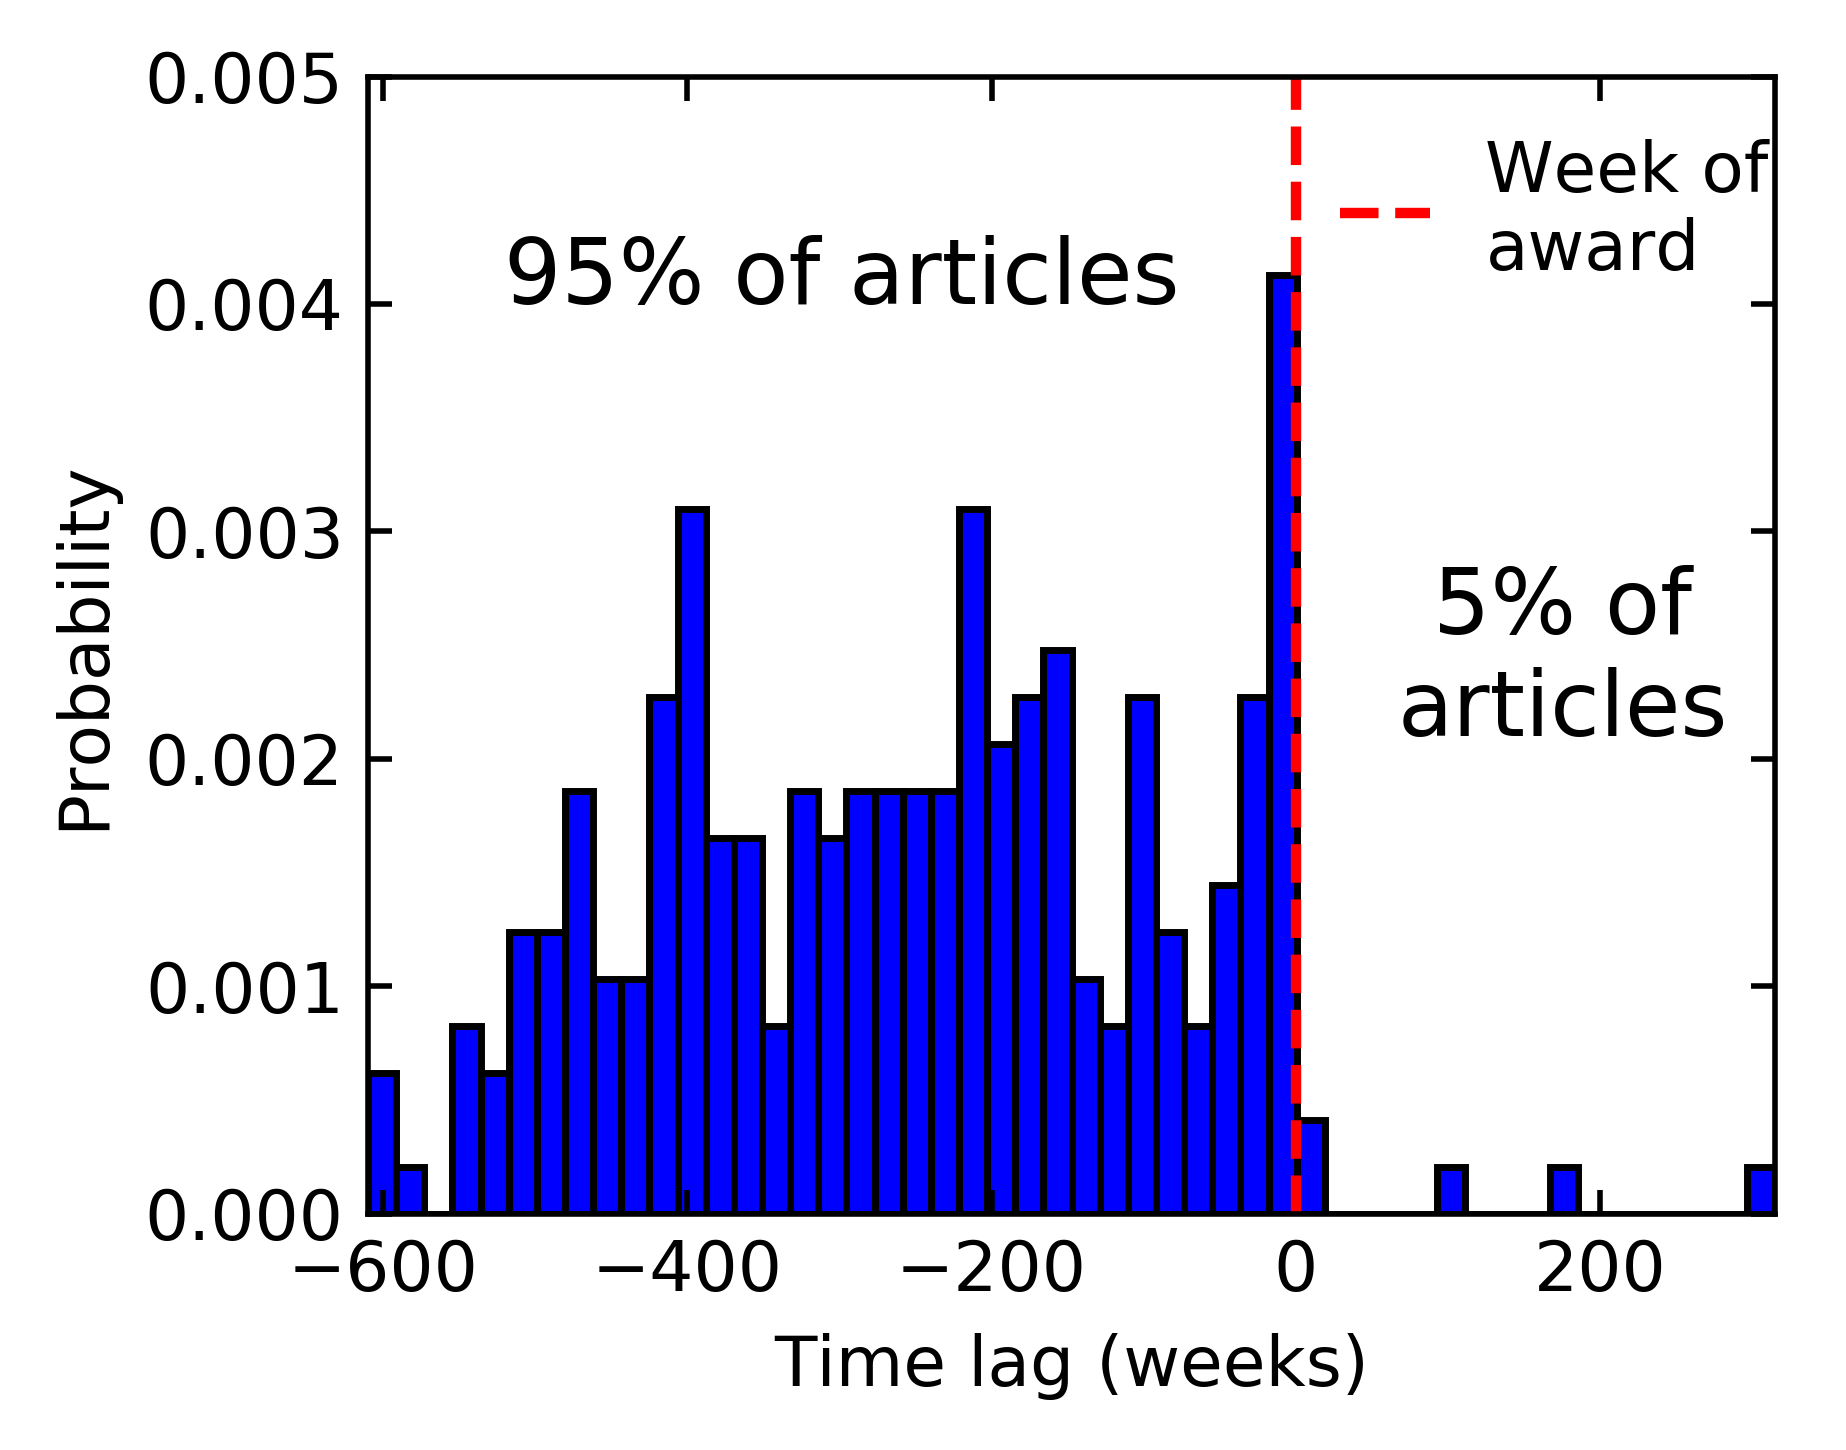

In [613]:
df_sci_aw["time_lag_after_created_award"]=(df_sci_aw["Page_created"]-df_sci_aw["Award_date"]).astype('timedelta64[D]').astype(int)/7.

f = plt.figure(dpi=500,figsize=(3.75, 3))#
#ax = f.add_subplot(111)
plt.hist(df_sci_aw["time_lag_after_created_award"].values,bins=50,normed=True,color="b",histtype='bar', ec='black')
plt.plot([0,0],[0,0.005],"r--",label="Week of\naward")
plt.xlim(df_sci_aw["time_lag_after_created_award"].min(),df_sci_aw["time_lag_after_created_award"].max())
plt.ylim(0,0.005)
plt.xlabel("Time lag (weeks)")
plt.ylabel("Probability")
plt.legend(frameon=False,loc='upper right', bbox_to_anchor=(1.04, 1),handlelength=1.3)

percent_below=100*float(len(df_sci_aw[df_sci_aw["time_lag_after_created_award"] <0]))/len(df_sci_aw)
print  round(percent_below, 0)
percent_above=100*float(len(df_sci_aw[df_sci_aw["time_lag_after_created_award"] >=0]))/len(df_sci_aw)
print round(percent_above, 0)
print 100*float(len(df_sci_aw[df_sci_aw["time_lag_after_created_award"] ==0]))/len(df_sci_aw)
print 100*float(len(df_sci_aw[(df_sci_aw["time_lag_after_created_award"]<=0)&(df_sci_aw["time_lag_after_created_award"]>-20)]))/len(df_sci_aw)

plt.text(-520, 0.004, "%i%% of articles"%(round(percent_below, 0)),fontdict={"size":13})
plt.text(175, 0.0021, "%i%% of\narticles"%(round(percent_above, 0)),fontdict={"size":13},ha='center')
plt.tick_params(which="both",direction="in",top=True,right=True)
#plt.title("Awarded group")
plt.tight_layout()
plt.savefig("plots/time_lag_after_award_created.pdf",dpi=500)
plt.show()


95.0
5.0


In [7]:
#remove views which corresponds to dates with no article exist
df_s_new=df_s.apply(lambda x:[i if j.date() >= df_sci_aw.loc[x.name]["Page_created"] else np.nan  for i,j in zip(x,x.index)],axis=1)
df_s_new.describe()

2008-01-06   2008-01-13    2008-01-20   2008-01-27   2008-02-03  \
count   165.000000   165.000000    165.000000   165.000000   165.000000   
mean    151.581818   216.000000    273.448485   223.218182   227.139394   
std     317.002964   427.131499    863.348476   461.398815   444.401185   
min       1.000000     3.000000      9.000000     3.000000     7.000000   
25%      35.000000    49.000000     59.000000    53.000000    56.000000   
50%      68.000000    98.000000    105.000000    92.000000   102.000000   
75%     138.000000   198.000000    219.000000   196.000000   197.000000   
max    2612.000000  3241.000000  10371.000000  4241.000000  3782.000000   

        2008-02-10   2008-02-17   2008-02-24   2008-03-02   2008-03-09  \
count   166.000000   166.000000   168.000000   168.000000   168.000000   
mean    218.060241   242.265060   257.404762   232.261905   239.297619   
std     435.940470   493.181523   546.692431   443.252719   459.093960   
min       4.000000     3.000000     7.000000     4.000000    10.000000   
25%      57.000000    57.000000    60.750000    57.750000    55.750000   
50%     102.500000   108.500000    96.000000   104.000000   104.500000   
75%     195.750000   202.750000   205.250000   222.000000   223.250000   
max    3891.000000  4504.000000  3976.000000  3297.000000  3582.000000   

          ...        2016-04-03     2016-04-10   2016-04-17   2016-04-24  \
count     ...        262.000000     262.000000   262.000000   262.000000   
mean      ...        380.282443    1234.274809   392.385496   381.171756   
std       ...        570.031891   13531.499455   605.572602   558.405610   
min       ...          0.000000       0.000000     0.000000     0.000000   
25%       ...         76.250000      72.250000    76.500000    79.250000   
50%       ...        220.500000     188.500000   216.000000   206.000000   
75%       ...        480.000000     487.250000   483.250000   471.750000   
max       ...       6000.000000  219070.000000  6832.000000  5381.000000   

        2016-05-01    2016-05-08    2016-05-15    2016-05-22    2016-05-29  \
count   262.000000    262.000000    262.000000    262.000000    262.000000   
mean    396.351145    442.171756    437.977099    430.152672    442.824427   
std     586.511453   1074.825003   1106.898217   1065.106251   1183.724960   
min       2.000000      3.000000      4.000000      3.000000      6.000000   
25%      80.250000     82.750000     73.500000     79.250000     77.250000   
50%     209.500000    217.500000    213.000000    211.500000    204.000000   
75%     459.750000    473.250000    467.250000    458.500000    456.750000   
max    4806.000000  15284.000000  15732.000000  15299.000000  16160.000000   

        2016-06-05  
count   262.000000  
mean    127.137405  
std     275.174741  
min       1.000000  
25%      23.000000  
50%      58.000000  
75%     137.000000  
max    3649.000000  

[8 rows x 440 columns]

In [8]:
#remove views which corresponds to dates with no article exist
df_b_new=df_b.apply(lambda x:[i if j.date() > df_sci_naw.loc[x.name]["Page_created"] else np.nan  for i,j in zip(x,x.index)],axis=1)
df_b_new.describe()

2008-01-06  2008-01-13  2008-01-20  2008-01-27  2008-02-03  2008-02-10  \
count  103.000000  103.000000  103.000000  103.000000  104.000000  105.000000   
mean    62.475728   83.427184   94.747573   88.427184   92.125000   88.561905   
std     70.947211   92.253020  109.901089  112.077232  110.329576  103.258351   
min      8.000000    7.000000   10.000000    8.000000   13.000000   11.000000   
25%     22.000000   33.000000   39.000000   34.000000   37.500000   35.000000   
50%     41.000000   50.000000   63.000000   57.000000   59.000000   61.000000   
75%     63.000000   89.500000   92.000000   94.500000   90.750000   94.000000   
max    511.000000  642.000000  827.000000  859.000000  851.000000  702.000000   

       2008-02-17   2008-02-24  2008-03-02  2008-03-09     ...      \
count  106.000000   106.000000  106.000000  107.000000     ...       
mean    95.650943   115.358491   98.103774   99.140187     ...       
std    105.080925   262.639321  130.147823  121.684750     ...       
min     11.000000     4.000000    6.000000   11.000000     ...       
25%     39.250000    37.000000   34.250000   38.000000     ...       
50%     62.000000    58.000000   58.500000   59.000000     ...       
75%    111.750000    86.250000   91.500000   95.000000     ...       
max    741.000000  2506.000000  860.000000  848.000000     ...       

        2016-04-03   2016-04-10   2016-04-17   2016-04-24   2016-05-01  \
count   274.000000   274.000000   275.000000   275.000000   275.000000   
mean     89.343066    86.883212    89.916364    90.356364    90.450909   
std     191.618093   160.720792   170.380136   172.944942   180.147467   
min       1.000000     1.000000     0.000000     0.000000     0.000000   
25%      18.000000    17.000000    19.000000    18.000000    18.000000   
50%      37.000000    39.000000    38.000000    39.000000    37.000000   
75%      74.000000    80.500000    83.000000    80.500000    78.500000   
max    1885.000000  1554.000000  1599.000000  1592.000000  1528.000000   

        2016-05-08   2016-05-15   2016-05-22   2016-05-29  2016-06-05  
count   275.000000   275.000000   275.000000   275.000000  275.000000  
mean     89.669091    81.974545    81.970909    80.938182   24.450909  
std     162.715067   151.671524   153.867463   145.905778   44.366674  
min       2.000000     2.000000     3.000000     0.000000    0.000000  
25%      17.000000    17.000000    16.500000    17.500000    5.000000  
50%      39.000000    36.000000    37.000000    34.000000   10.000000  
75%      88.000000    84.500000    81.000000    82.000000   26.000000  
max    1555.000000  1569.000000  1594.000000  1455.000000  407.000000  

[8 rows x 440 columns]

In [9]:
df_s_m_new=df_s_m.apply(lambda x:[i if j.date() > df_sci_aw.loc[x.name]["Page_created"] else np.nan  for i,j in zip(x,x.index)],axis=1)

In [10]:
df_b_m_new=df_b_m.apply(lambda x:[i if j.date() > df_sci_naw.loc[x.name]["Page_created"] else np.nan  for i,j in zip(x,x.index)],axis=1)

## calendar weekly views

In [13]:
from matplotlib.container import ErrorbarContainer
from matplotlib.legend_handler import HandlerErrorbar

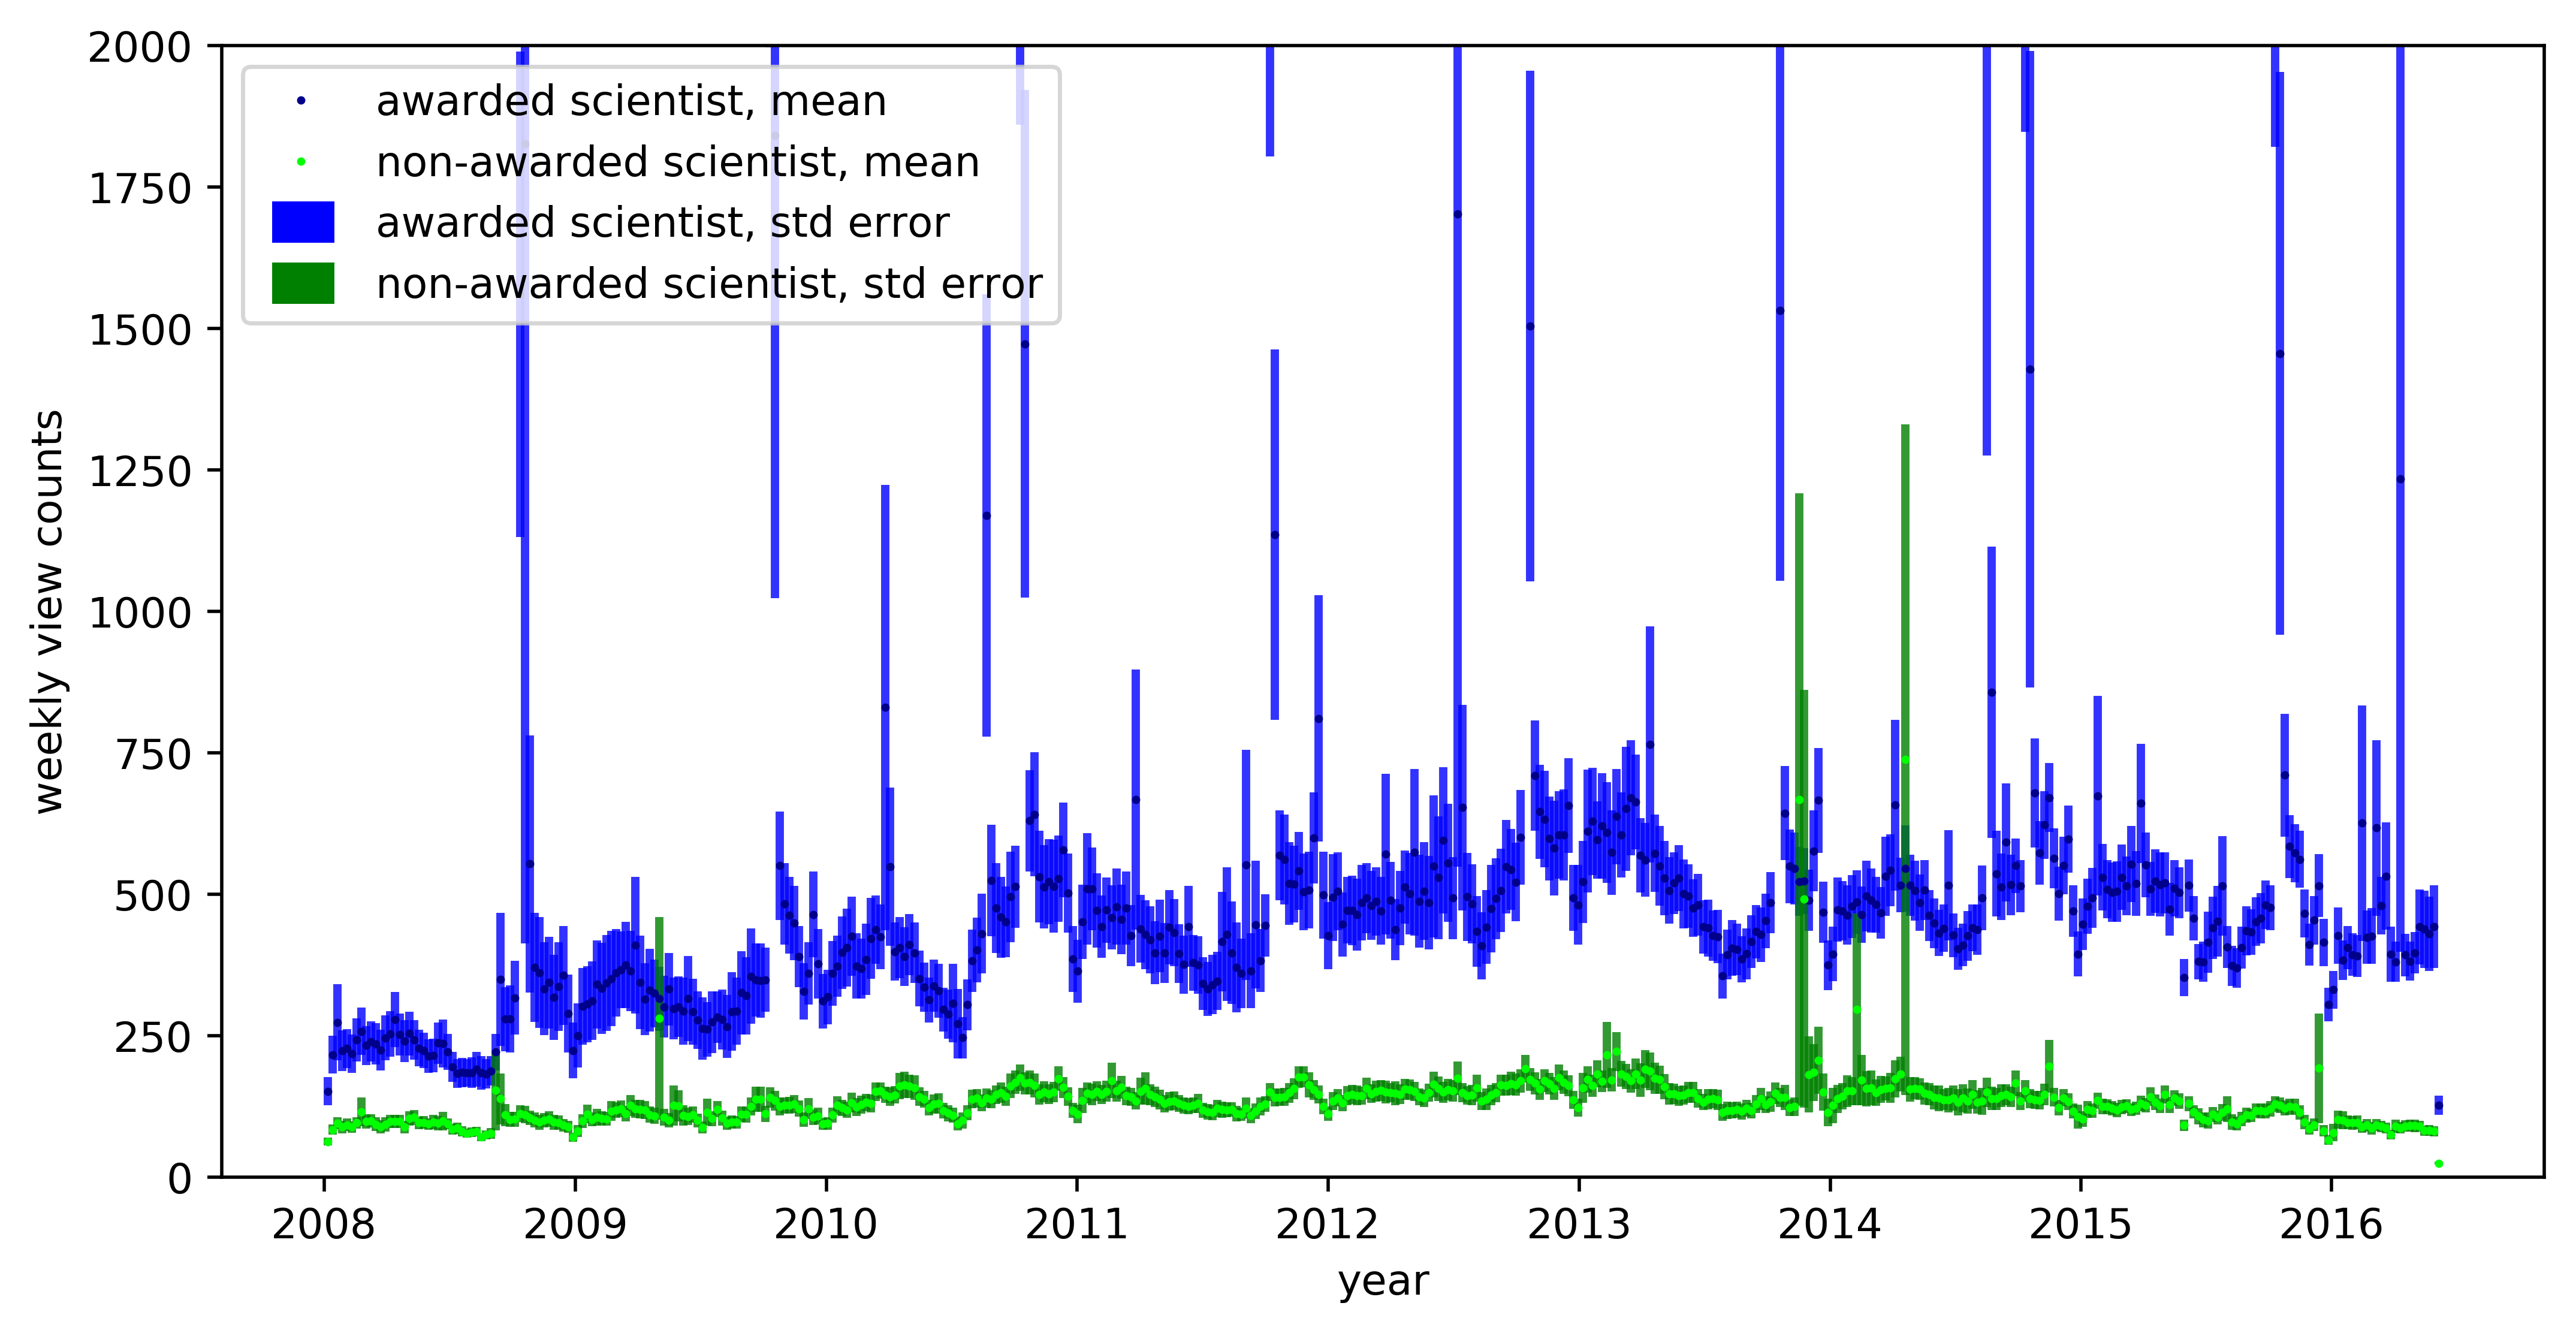

In [16]:
fig, (ax0) = plt.subplots(ncols=1, sharey=True,figsize=[10,5],dpi=500)
ax0.set_ylim(0,2000)
ax0.set_ylabel("weekly view counts")
ax0.set_xlabel("year")
#ax0.errorbar(df_s_w_st_aw.index.values, df_s_w_st_aw.mean_w, df_s_w_st_aw.std_1,c="b",alpha=0.7,#lw=2,
#             linestyle='None',label="awarded scientist, std error")#,label='_nolegend_')
#ax0.plot(df_s_w_st_aw.index.values, df_s_w_st_aw.mean_w,"darkblue",linewidth = 1,label="awarded scientist, mean")
#ax0.set_xlim(df_s_w_st_aw.iloc[0].name,df_s_w_st_aw.iloc[-1].name)


#ax0.errorbar(df_s_w_st_naw.index.values, df_s_w_st_naw.mean_w, df_s_w_st_naw.std_1,c="green",alpha=0.7,#lw=2,
#             linestyle='None',label="non-awarded scientist, std error")#label='_nolegend_'
#ax0.plot(df_s_w_st_naw.index.values, df_s_w_st_naw.mean_w,"lime",linewidth = 1,label="non-awarded scientist, mean")
#ax0.plot([0,0],[10,175],"r--",label="week of award")

#leg=ax0.legend(loc=2,handler_map={ErrorbarContainer: HandlerErrorbar(numpoints=15,xpad=0.1)})
#for lh in leg.legendHandles: 
#    lh.set_alpha(1)


ax0.errorbar(df_s_new.columns.values, df_s_new.mean().values, df_s_new.sem().values,c="b",alpha=0.8,lw=2,
             linestyle='None',label="awarded scientist, std error")#,label='_nolegend_')
ax0.plot(df_s_new.columns.values, df_s_new.mean().values,".",c="darkblue",ms=2,linewidth = 1,label="awarded scientist, mean")
ax0.errorbar(df_b_new.columns.values, df_b_new.mean().values, df_b_new.sem().values,c="green",alpha=0.8,lw=2,
             linestyle='None',label="non-awarded scientist, std error")#label='_nolegend_'
ax0.plot(df_b_new.columns.values, df_b_new.mean().values,".",c="lime",ms=2,linewidth = 1,label="non-awarded scientist, mean")
leg=ax0.legend(loc=2,handler_map={ErrorbarContainer: HandlerErrorbar(numpoints=15,xpad=0.1)})
for lh in leg.legendHandles: 
    lh.set_alpha(1)
#ax1.set_xlim(df_s_w_st.iloc[0].name,df_s_w_st.iloc[-1].name)
ax0.set_xlabel("year")
plt.subplots_adjust(wspace=0.03, hspace=0.03)
#plt.tight_layout()
plt.show()

## calendar monthly comulated views

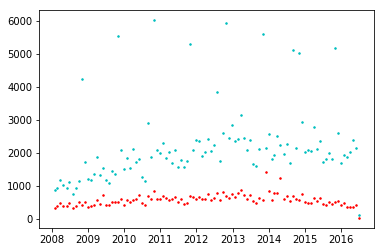

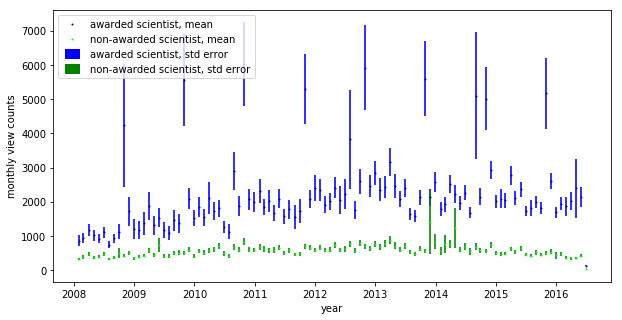

In [17]:
plt.plot(df_s_m_new.columns.values, df_s_m_new.mean().values,".c",ms=3)
plt.plot(df_b_m_new.columns.values, df_b_m_new.mean().values,".r",ms=3)



fig, (ax0) = plt.subplots(ncols=1, sharey=True,figsize=[10,5])
#ax0.set_ylim(0,5000)
ax0.set_ylabel("monthly view counts")
ax0.set_xlabel("year")

ax0.errorbar(df_s_m_new.columns.values, df_s_m_new.mean().values, df_s_m_new.sem().values,c="b",alpha=0.8,lw=2,
             linestyle='None',label="awarded scientist, std error")#,label='_nolegend_')
ax0.plot(df_s_m_new.columns.values, df_s_m_new.mean().values,".",c="darkblue",ms=2,linewidth = 1,label="awarded scientist, mean")
ax0.errorbar(df_b_m_new.columns.values, df_b_m_new.mean().values, df_b_m_new.sem().values,c="green",alpha=0.8,lw=2,
             linestyle='None',label="non-awarded scientist, std error")#label='_nolegend_'
ax0.plot(df_b_m_new.columns.values, df_b_m_new.mean().values,".",c="lime",ms=2,linewidth = 1,label="non-awarded scientist, mean")
leg=ax0.legend(loc=2,handler_map={ErrorbarContainer: HandlerErrorbar(numpoints=15,xpad=0.1)})
for lh in leg.legendHandles: 
    lh.set_alpha(1)
#ax1.set_xlim(df_s_w_st.iloc[0].name,df_s_w_st.iloc[-1].name)
ax0.set_xlabel("year")
plt.subplots_adjust(wspace=0.03, hspace=0.03)
#plt.tight_layout()
plt.show()

## 0 week is a week of article creation

In [18]:
df_s_t_new=df_s_new.T
df_s_t_new=df_s_t_new.apply(lambda x: pd.Series(x.dropna().values))
df_s_0week=df_s_t_new.T

df_b_t_new=df_b_new.T
df_b_t_new=df_b_t_new.apply(lambda x: pd.Series(x.dropna().values))
df_b_0week=df_b_t_new.T

df_s_0week.describe()

0             1             2             3            4    \
count    262.000000    262.000000    262.000000    262.000000   262.000000   
mean    1243.332061    464.618321    305.377863    566.068702   246.858779   
std     6210.121768   2270.563557    882.817762   5391.786252   635.311429   
min        0.000000      0.000000      0.000000      0.000000     0.000000   
25%       34.250000     38.250000     43.000000     40.000000    40.250000   
50%       68.500000     80.000000     81.000000     73.000000    75.000000   
75%      133.000000    170.500000    196.000000    186.750000   177.750000   
max    53116.000000  33041.000000  10371.000000  87099.000000  7305.000000   

               5            6            7            8            9    \
count   262.000000   262.000000   262.000000   262.000000   262.000000   
mean    219.721374   229.041985   232.790076   221.507634   255.125954   
std     484.781432   500.852784   511.206527   448.470425   543.463023   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      36.250000    40.000000    37.500000    39.250000    41.000000   
50%      73.000000    74.500000    73.000000    76.000000    80.000000   
75%     174.000000   175.250000   172.250000   178.000000   188.000000   
max    3891.000000  4504.000000  3976.000000  3297.000000  3582.000000   

          ...               430           431          432          433  \
count     ...        168.000000    168.000000   168.000000   166.000000   
mean      ...        455.190476    486.535714   466.119048   454.692771   
std       ...        646.601488    920.636996   695.996936   634.406663   
min       ...         11.000000     12.000000    11.000000    14.000000   
25%       ...        102.000000    107.750000   105.000000   113.500000   
50%       ...        266.500000    247.500000   261.000000   253.500000   
75%       ...        559.500000    552.250000   554.000000   525.750000   
max       ...       6000.000000  10537.000000  6832.000000  5381.000000   

               434          435          436          437          438  \
count   166.000000   165.000000   165.000000   165.000000   165.000000   
mean    461.608434   458.363636   459.593939   446.012121   424.284848   
std     653.697074   632.057838   657.995152   594.252790   568.870305   
min      13.000000     9.000000    12.000000    19.000000    14.000000   
25%     113.500000   103.000000   101.000000   105.000000   103.000000   
50%     255.500000   266.000000   249.000000   276.000000   253.000000   
75%     516.500000   524.000000   510.000000   507.000000   480.000000   
max    4806.000000  5106.000000  5467.000000  4694.000000  4481.000000   

               439  
count   165.000000  
mean    128.666667  
std     179.163277  
min       4.000000  
25%      32.000000  
50%      80.000000  
75%     152.000000  
max    1605.000000  

[8 rows x 440 columns]

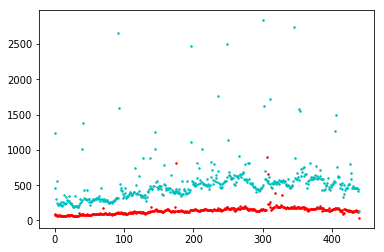

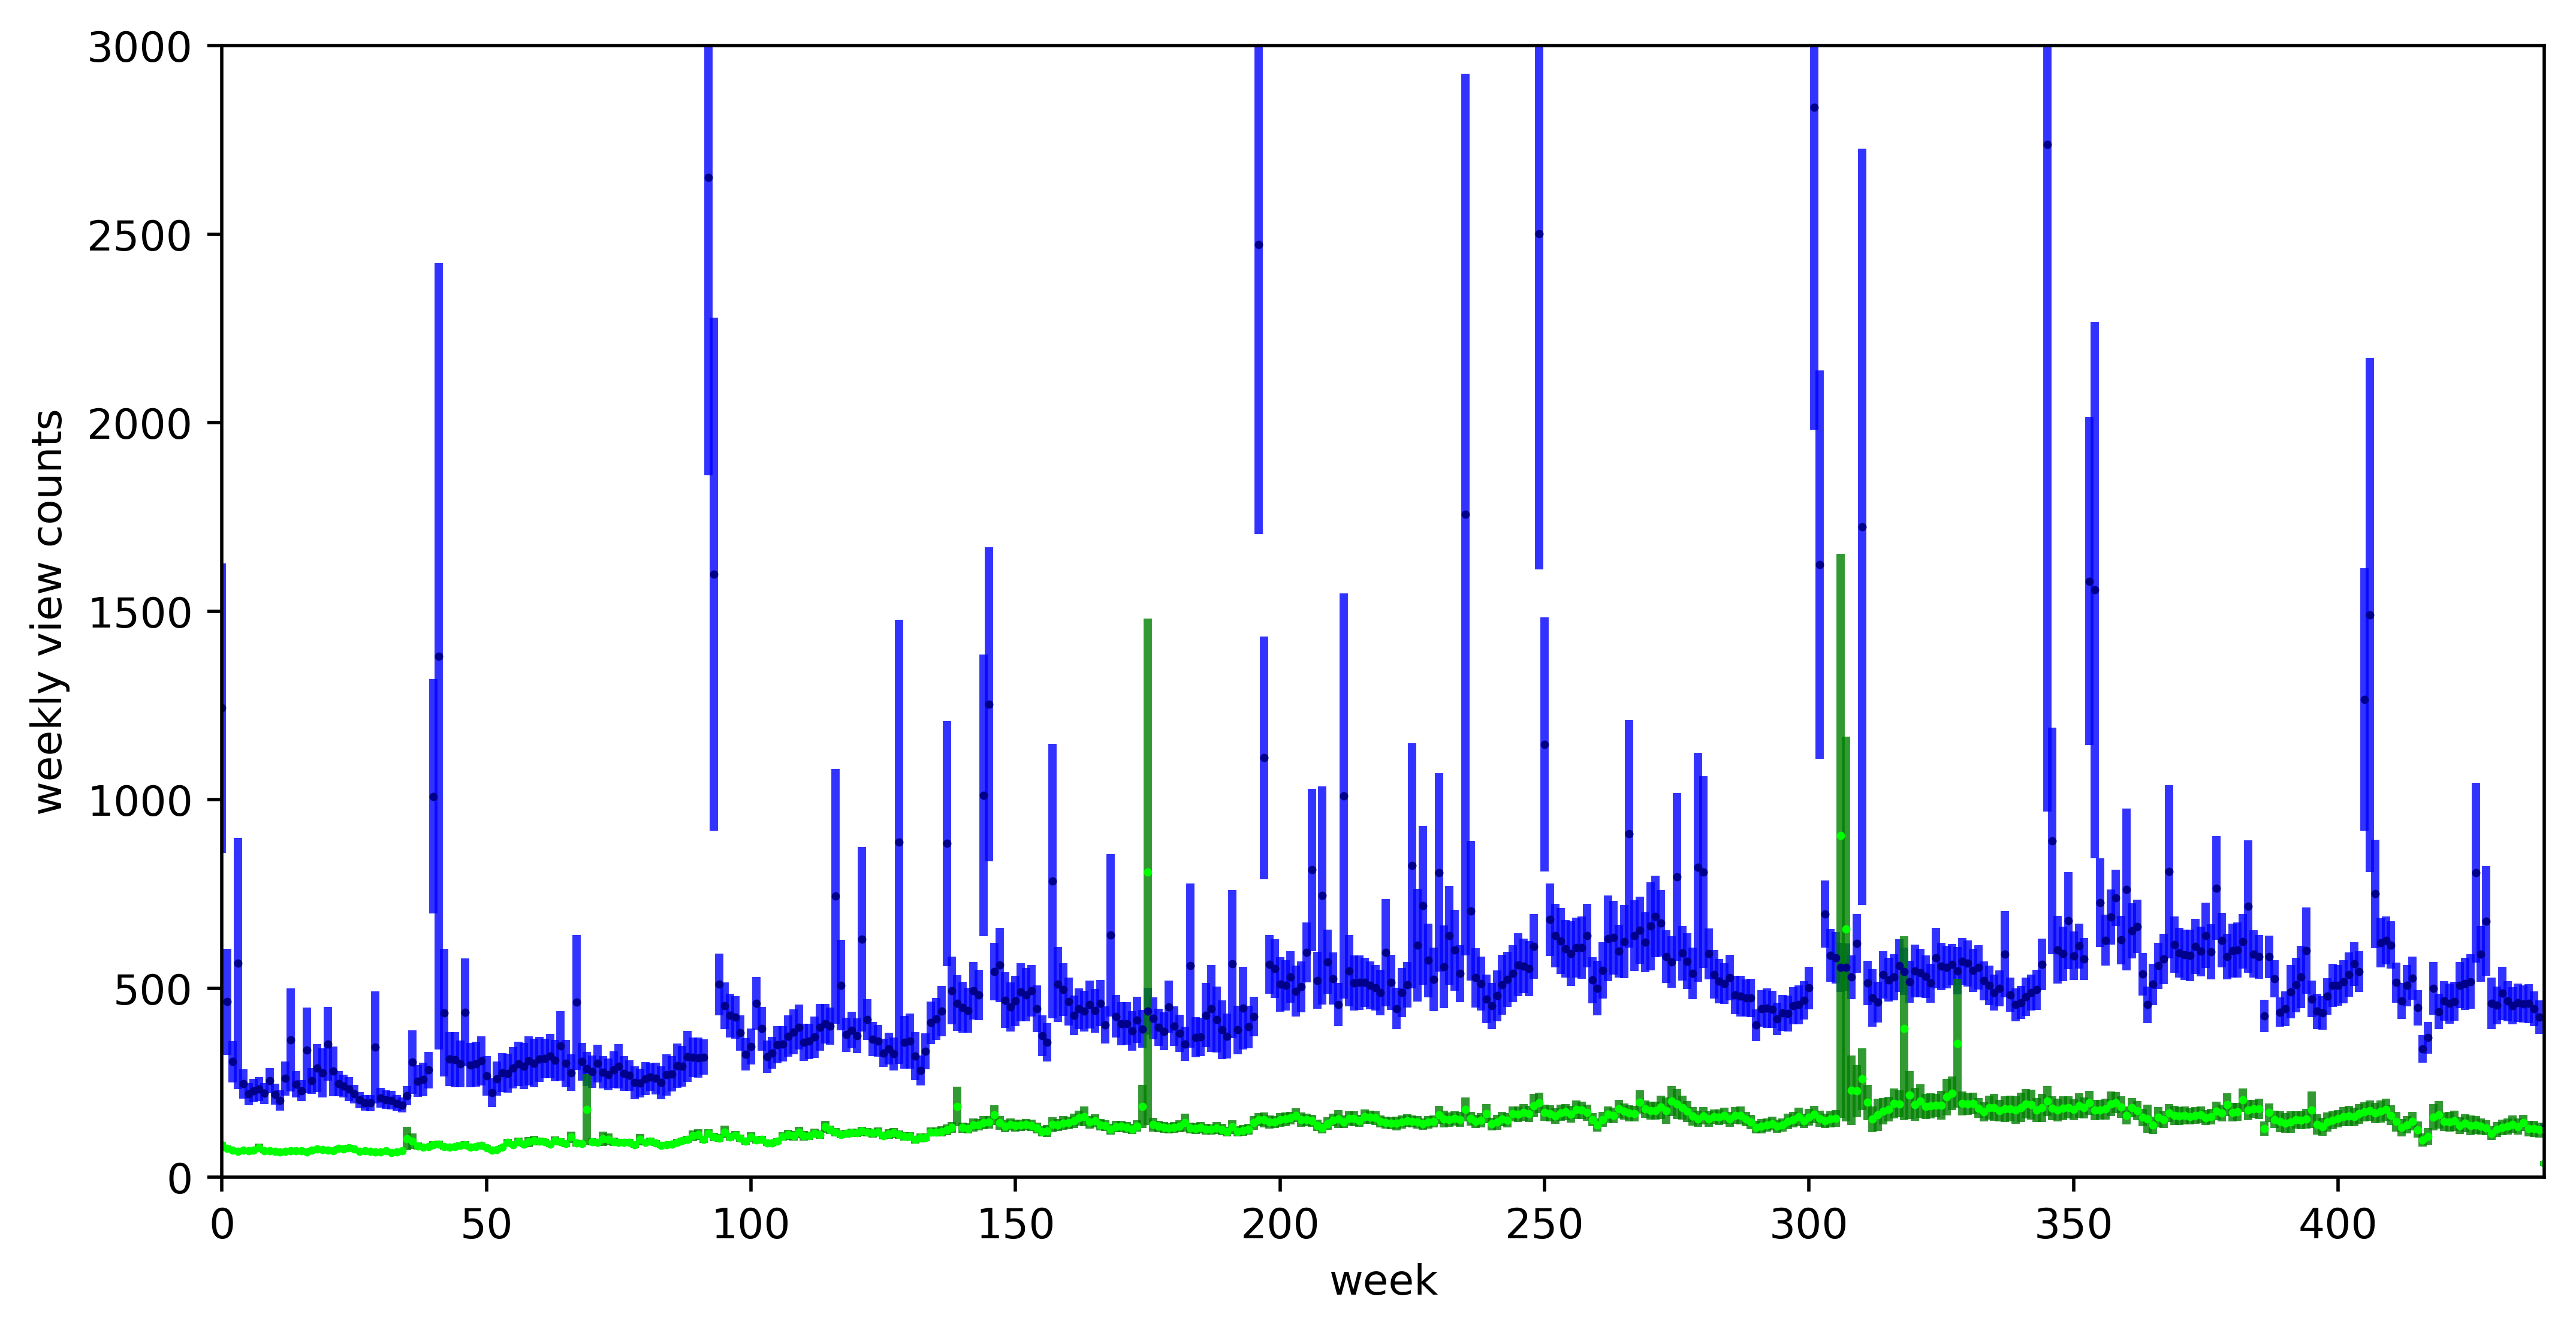

In [20]:
plt.plot(df_b_0week.columns.values, df_b_0week.mean().values,".r",ms=3)
plt.plot(df_s_0week.columns.values, df_s_0week.mean().values,".c",ms=3)

fig, (ax0) = plt.subplots(ncols=1, sharey=True,figsize=[10,5],dpi=500)
ax0.set_ylim(0,3000)
ax0.set_xlim(df_s_0week.columns[0],df_s_0week.columns[-1])
ax0.set_ylabel("weekly view counts")
ax0.set_xlabel("week")

ax0.errorbar(df_s_0week.columns.values, df_s_0week.mean().values, df_s_0week.sem().values,c="b",alpha=0.8,lw=2,
             linestyle='None',label="awarded scientist, std error")#,label='_nolegend_')
ax0.plot(df_s_0week.columns.values, df_s_0week.mean().values,".",c="darkblue",ms=2,linewidth = 1,label="awarded scientist, mean")
ax0.errorbar(df_b_0week.columns.values, df_b_0week.mean().values, df_b_0week.sem().values,c="green",alpha=0.8,lw=2,
             linestyle='None',label="non-awarded scientist, std error")#label='_nolegend_'
ax0.plot(df_b_0week.columns.values, df_b_0week.mean().values,".",c="lime",ms=2,linewidth = 1,label="non-awarded scientist, mean")
leg=ax1.legend(loc=2,handler_map={ErrorbarContainer: HandlerErrorbar(numpoints=15,xpad=0.1)})
for lh in leg.legendHandles: 
    lh.set_alpha(1)
ax0.set_xlim(df_s_0week.columns[0],df_s_0week.columns[-1])
ax0.set_xlabel("week")
#ax1.set_title('Length of article; 0 week is the week when the article about scientists was created')
plt.subplots_adjust(wspace=0.03, hspace=0.03)
#plt.tight_layout()
plt.show()

## 0 week is award day

In [21]:
#=====> do not run if you already have the file data/awarded_sc_views_0week_is_award.csv

df_s_w_aw=pd.DataFrame(columns=["time_w","views","article","week"])

for article_name,series in df_s_new.iterrows():
    #print article_name,series # s series day - views
    #print article_name
    created=df_sci_aw.loc[article_name]["Page_created"]
    index=pd.date_range(start=df_sci_aw.loc[article_name].Award_date,end=datetime(2016,6,5),freq="W")
    index2=pd.date_range(end=df_sci_aw.loc[article_name].Award_date,start=datetime(2008,1,6),freq="W")
    #index2=pd.date_range(end=df_sci_aw.loc[article_name].Award_date,start=created,freq="W")
    
    df1_1=pd.DataFrame(index,columns=["time_w"])
    df1_1.time_w=df1_1.time_w.apply(lambda x: x.date() )
    #if  created after award
    if (created - df_sci_aw.loc[article_name].Award_date)>(created -created):
        #df1_1=df1_1[df1_1.time_w>=created]
        #s=series.dropna()
        df1_1["views"]=df1_1.time_w.apply(lambda x: series.loc[x])
        df1_2=pd.DataFrame(index2,columns=["time_w"])
        df1_2.time_w=df1_2.time_w.apply(lambda x: x.date() )
        df1_2.index=df1_2.apply(lambda x: x.name-len(df1_2),axis=1)
        df1_2["views"]=df1_2.time_w.apply(lambda x: series.loc[x] if x in series.index else None)
        #df1=df1_1[["time_w","views"]]
        df1=pd.concat([df1_1,df1_2])
        print article_name
        #print df_sci_aw.loc[article_name].Award_date
        #print created
        #print df1
        print "==> created after award"
    else:
        df1_2=pd.DataFrame(index2,columns=["time_w"])
        df1_2.time_w=df1_2.time_w.apply(lambda x: x.date() )
        df1_2.index=df1_2.apply(lambda x: x.name-len(df1_2),axis=1)
        df1_1["views"]=df1_1.time_w.apply(lambda x: series.loc[x])
        df1_2["views"]=df1_2.time_w.apply(lambda x: series.loc[x] if x in series.index else None)
        df1=pd.concat([df1_1,df1_2])
        
    df1["article"]=article_name
    df1["week"]=df1.index
    df_s_w_aw=pd.concat([df_s_w_aw,df1])
df_s_w_aw.to_csv("data/awarded_sc_views_0week_is_award.csv",sep="\t")

Bernd_Giese
==> created after award
David_R._Smith
==> created after award
Hideo_Ohno
==> created after award
Konstantin_Novoselov
==> created after award
Stephen_E._Harris
==> created after award
Winslow_Briggs
==> created after award


In [24]:
df_s_w_aw=pd.DataFrame.from_csv("data/awarded_sc_views_0week_is_award.csv",sep="\t")

In [22]:
df_s_w_aw[df_s_w_aw.week==-406]

time_w  views            article  week
-406  2008-01-06    NaN  Charles_F._Manski  -406
-406  2008-01-06   75.0       John_A._List  -406
-406  2008-01-06   27.0   Richard_Blundell  -406

In [25]:
#group data by week number
df_s_w_aw.info()
g=df_s_w_aw.groupby("week")
s_w_st_dict=defaultdict()
for week_name,series in g:
    s_w_st_dict[week_name]={"mean_w":series.views.mean(),"std_1":series.views.sem(),
                            "count":series[~series.views.isnull()].views.count()}
#create df
df_s_w_st_aw=pd.DataFrame.from_dict(s_w_st_dict,orient="index")
print len(df_s_w_st_aw)
df_s_w_st_aw=df_s_w_st_aw[df_s_w_st_aw["count"]>10]
print len(df_s_w_st_aw)
df_s_w_st_aw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115280 entries, 0 to -1
Data columns (total 4 columns):
time_w     115280 non-null object
views      99357 non-null float64
article    115280 non-null object
week       115280 non-null object
dtypes: float64(1), object(3)
memory usage: 4.4+ MB
834
805
<class 'pandas.core.frame.DataFrame'>
Int64Index: 805 entries, -405 to 399
Data columns (total 3 columns):
count     805 non-null int64
mean_w    805 non-null float64
std_1     805 non-null float64
dtypes: float64(2), int64(1)
memory usage: 25.2 KB


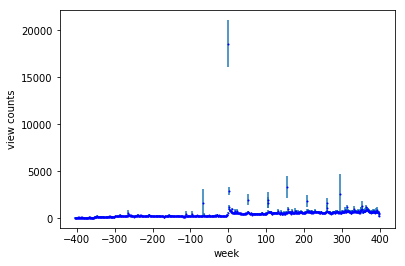

In [27]:
plt.errorbar(df_s_w_st_aw.index.values, df_s_w_st_aw.mean_w, df_s_w_st_aw.std_1,linestyle='None')
plt.plot(df_s_w_st_aw.index.values, df_s_w_st_aw.mean_w,".b",linewidth = 1,ms=2)
#plt.xlim(0,df_s_w_st.iloc[-1].name)
#plt.ylim(0,5000)
plt.xlabel("week")
plt.ylabel("view counts");

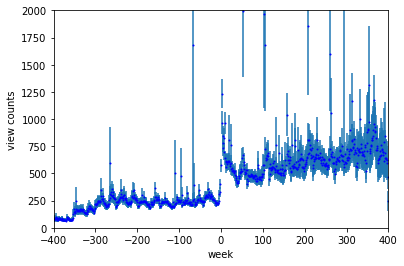

In [28]:
plt.errorbar(df_s_w_st_aw.index.values, df_s_w_st_aw.mean_w, df_s_w_st_aw.std_1,linestyle='None')
plt.plot(df_s_w_st_aw.index.values, df_s_w_st_aw.mean_w,".b",ms=2)
plt.xlim(-400,400)
plt.ylim(0,2000)
plt.xlabel("week")
plt.ylabel("view counts");

## Non-awarded scientists

In [31]:
#=====> do not run if you already have the file data/non-award_sc_info_with_placeboaward.csv

#assign random day

def random_date(start, end, position=None):
    start, end = pd.Timestamp(start), pd.Timestamp(end)
    delta = (end - start).total_seconds()
    if position is None:
        offset = np.random.uniform(0., delta)
    else:
        offset = position * delta
    offset = pd.offsets.Second(offset)
    t = start + offset
    return t
#print df_b.timestamp.min()
#print df_b.timestamp.max()
print df_sci_aw.Award_date.min()
print df_sci_aw.Award_date.max()

start=df_sci_aw.Award_date.min()
end=df_sci_aw.Award_date.max()
df_sci_naw["Award_date"]=df_sci_naw.Name.apply(lambda x: random_date(start, end).date() )
df_sci_naw.to_csv("data/non-award_sc_info_with_placeboaward.csv",sep="\t")

2008-03-27
2015-10-12


In [ ]:
df_sci_naw=pd.DataFrame.from_csv("data/non-award_sc_info_with_placeboaward.csv",sep="\t")

In [35]:
#=====> do not run if you already have the file data/non-awarded_sc_views_0week_is_award.csv

df_s_w_naw=pd.DataFrame(columns=["time_w","views","article","week"])

for article_name,series in df_b_new.iterrows():
    #print article_name,series # s series day - views
    #print article_name
    created=df_sci_naw.loc[article_name]["Page_created"]
    index=pd.date_range(start=df_sci_naw.loc[article_name].Award_date,end=datetime(2016,6,5),freq="W")
    index2=pd.date_range(end=df_sci_naw.loc[article_name].Award_date,start=datetime(2008,1,6),freq="W")   
    df1_1=pd.DataFrame(index,columns=["time_w"])
    df1_1.time_w=df1_1.time_w.apply(lambda x: x.date() )
    #if  created after award
    if (created - df_sci_naw.loc[article_name].Award_date)>(created - created):
        #df1_1=df1_1[df1_1.time_w>=created]
        ##s=series.dropna()
        #df1_1["views"]=df1_1.time_w.apply(lambda x: series.loc[x])
        #df1=df1_1[["time_w","views"]]
        #print "==> created after award"
        
        df1_1["views"]=df1_1.time_w.apply(lambda x: series.loc[x])
        df1_2=pd.DataFrame(index2,columns=["time_w"])
        df1_2.time_w=df1_2.time_w.apply(lambda x: x.date() )
        df1_2.index=df1_2.apply(lambda x: x.name-len(df1_2),axis=1)
        df1_2["views"]=df1_2.time_w.apply(lambda x: series.loc[x] if x in series.index else None)
        #df1=df1_1[["time_w","views"]]
        df1=pd.concat([df1_1,df1_2])
        print article_name
        #print df_sci_naw.loc[article_name].Award_date
        #print created
        #print df1
        #print df1_2
        print "==> created after award"
        
    else:
        df1_2=pd.DataFrame(index2,columns=["time_w"])
        df1_2.time_w=df1_2.time_w.apply(lambda x: x.date() )
        df1_2.index=df1_2.apply(lambda x: x.name-len(df1_2),axis=1)
        df1_1["views"]=df1_1.time_w.apply(lambda x: series.loc[x])
        df1_2["views"]=df1_2.time_w.apply(lambda x: series.loc[x] if x in series.index else None)
        #print article_name
        #print "created:",created
        #print "award:",df_sci_naw.loc[article_name].Award_date
        df1=pd.concat([df1_1,df1_2])
        
    df1["article"]=article_name
    df1["week"]=df1.index
    df_s_w_naw=pd.concat([df_s_w_naw,df1])
df_s_w_naw.to_csv("data/non-awarded_sc_views_0week_is_award.csv",sep="\t")

%C4%90%C3%A0m_Thanh_S%C6%A1n
==> created after award
%C5%BDeljko_Reiner
==> created after award
Akiko_Iwasaki
==> created after award
Alex_Bateman
==> created after award
Amir_Yacoby
==> created after award
Andrew_H._Van_de_Ven
==> created after award
Annarosa_Leri
==> created after award
Bernhard_Keller
==> created after award
Biswanath_Mukherjee
==> created after award
Bruce_D._Walker
==> created after award
Campbell_Harvey
==> created after award
Chen_Guanrong
==> created after award
Chih-Jen_Lin
==> created after award
Cisca_Wijmenga
==> created after award
Claire_Berger
==> created after award
Dariush_Mozaffarian
==> created after award
Dennis_P._Curran
==> created after award
Edward_Ott
==> created after award
Edward_R._Dougherty
==> created after award
Fiona_Powrie
==> created after award
Frank_Glorius
==> created after award
G%C3%A9rald_Bastard
==> created after award
George_Davey_Smith
==> created after award
George_Sawatzky
==> created after award
Giuseppe_Mingione
==> create

In [36]:
df_s_w_naw=pd.DataFrame.from_csv("data/non-awarded_sc_views_0week_is_award.csv",sep="\t")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121041 entries, 0 to -1
Data columns (total 4 columns):
time_w     121041 non-null object
views      83919 non-null float64
article    121041 non-null object
week       121041 non-null object
dtypes: float64(1), object(3)
memory usage: 4.6+ MB
828
758
<class 'pandas.core.frame.DataFrame'>
Int64Index: 758 entries, -342 to 415
Data columns (total 3 columns):
count     758 non-null int64
mean_w    758 non-null float64
std_1     758 non-null float64
dtypes: float64(2), int64(1)
memory usage: 23.7 KB


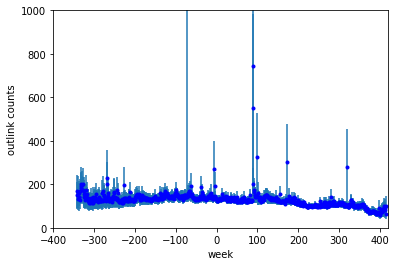

In [37]:
#group data by week number
df_s_w_naw.info()
g=df_s_w_naw.groupby("week")

b_w_st_dict=defaultdict()

for week_name,series in g:
    b_w_st_dict[week_name]={"mean_w":series.views.mean(),"std_1":series.views.sem(),
                            "count":series[~series.views.isnull()].views.count()}
#create df
df_s_w_st_naw=pd.DataFrame.from_dict(b_w_st_dict,orient="index")
print len(df_s_w_st_naw)
df_s_w_st_naw=df_s_w_st_naw[df_s_w_st_naw["count"]>10]
print len(df_s_w_st_naw)
df_s_w_st_naw.info()


plt.errorbar(df_s_w_st_naw.index.values, df_s_w_st_naw.mean_w, df_s_w_st_naw.std_1,linestyle='None')
plt.plot(df_s_w_st_naw.index.values, df_s_w_st_naw.mean_w,".b",linewidth = 1)
plt.xlim(-400,420)
plt.ylim(0,1000)
plt.xlabel("week")
plt.ylabel("outlink counts");

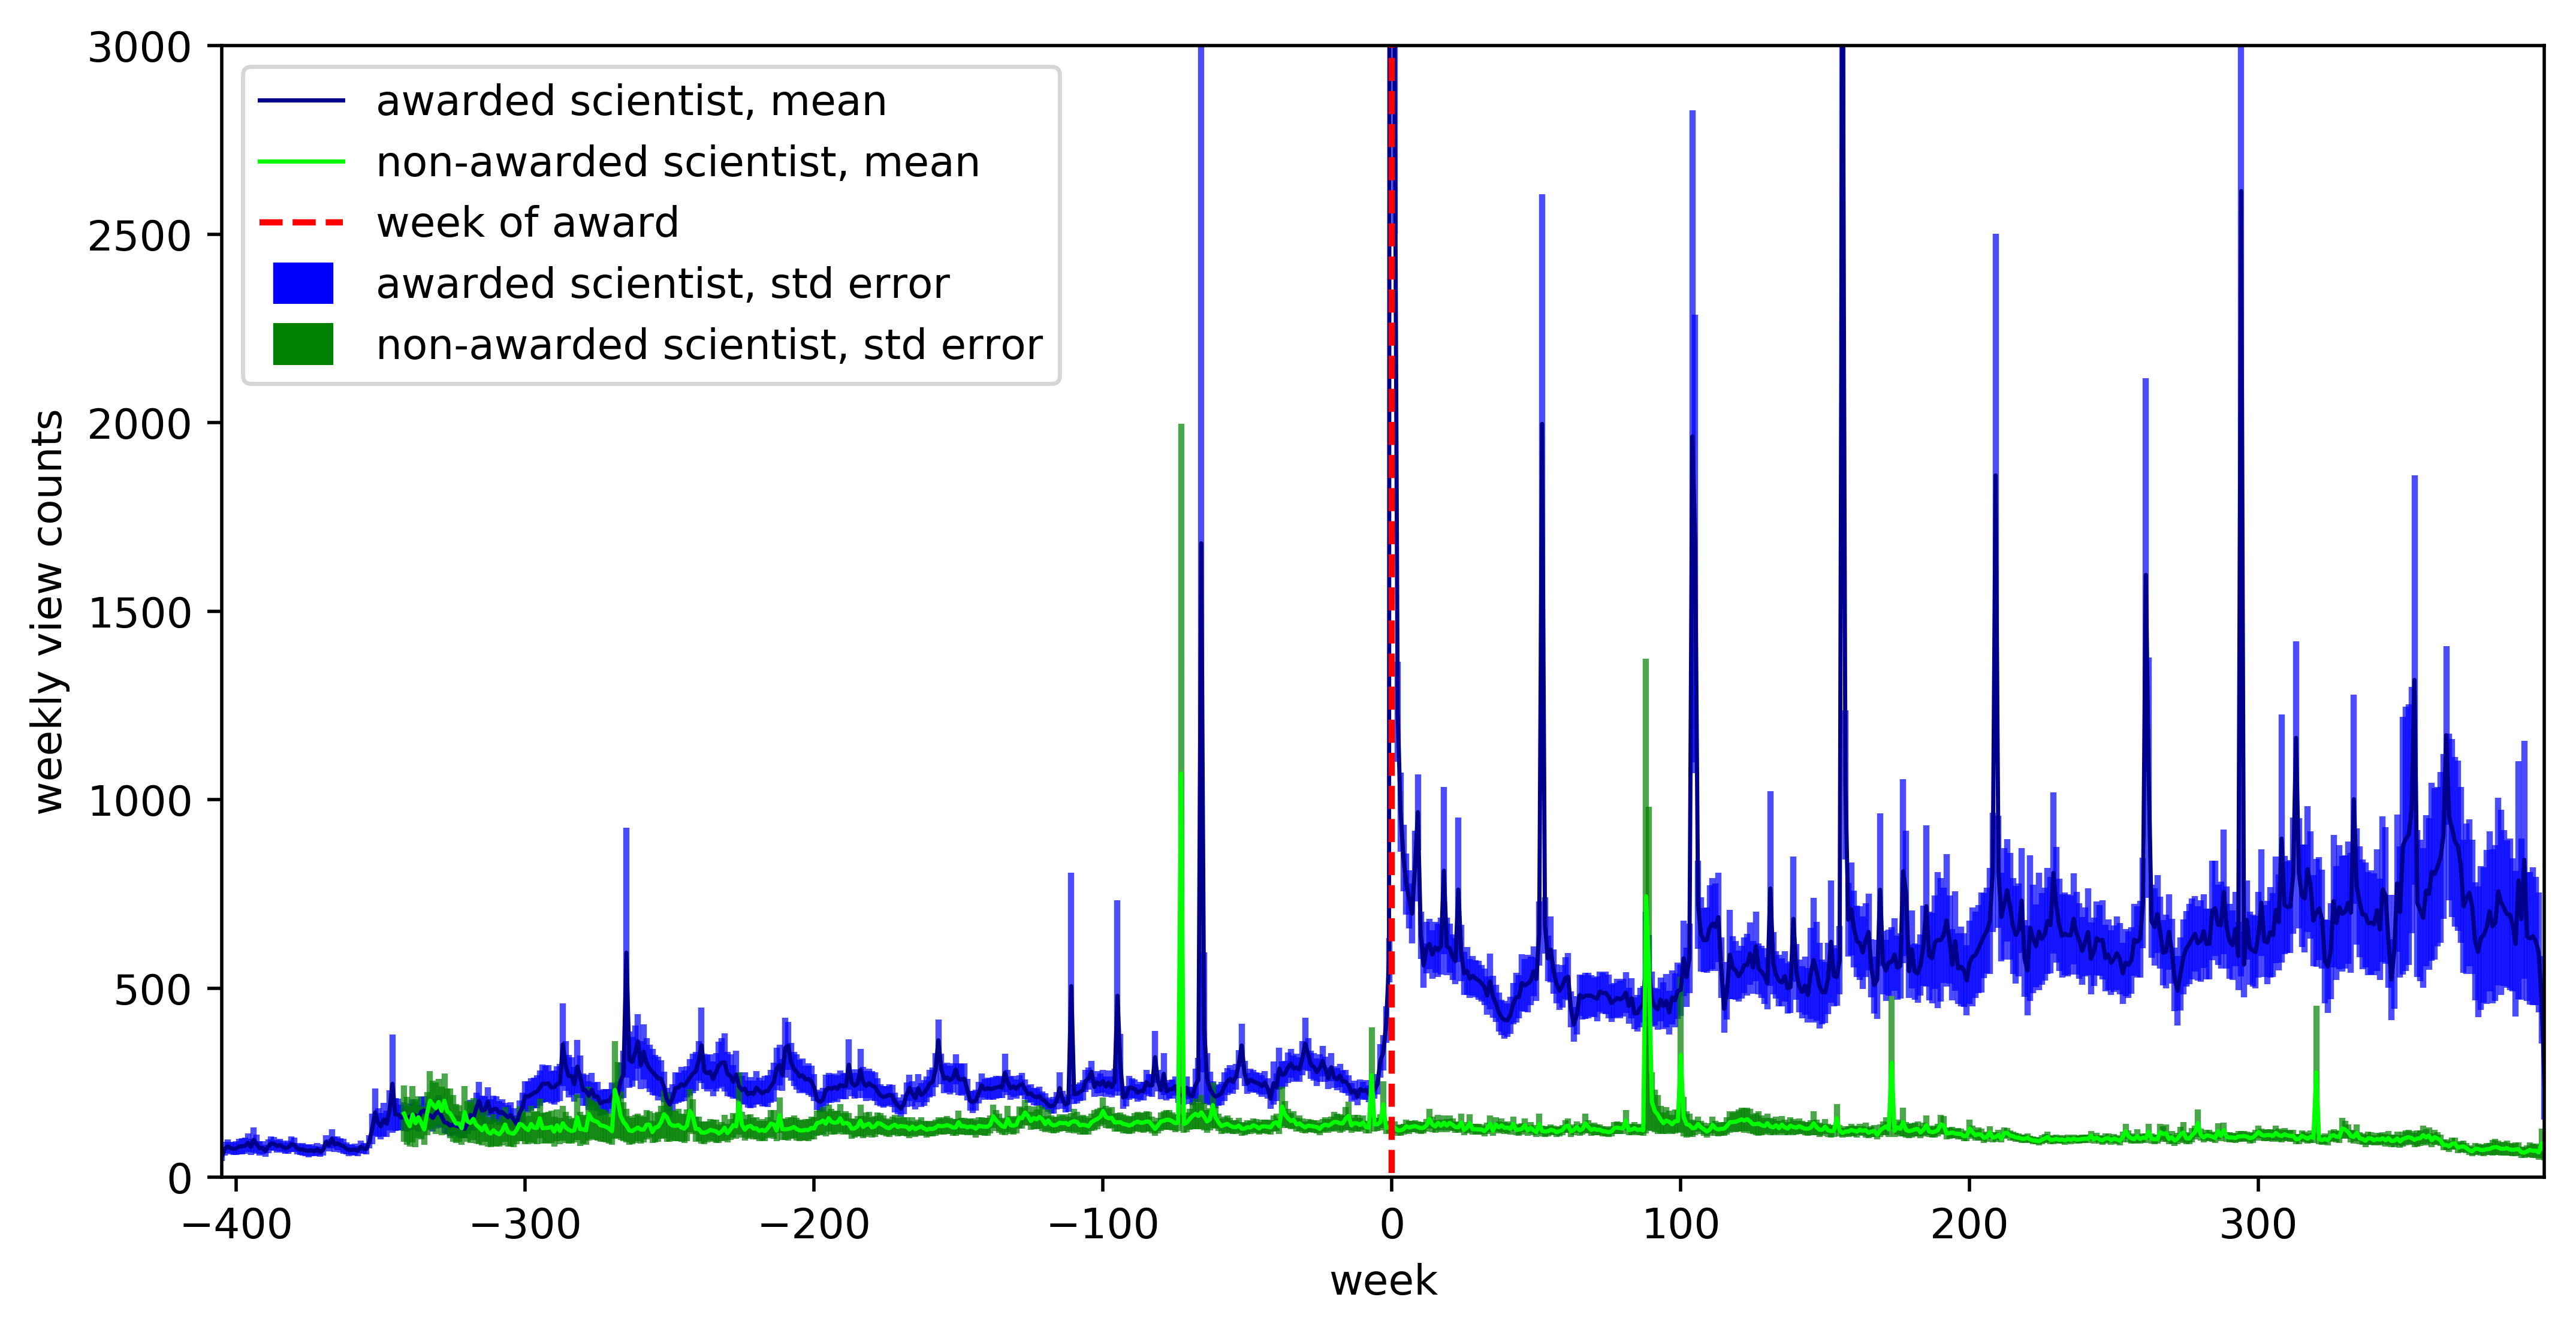

In [139]:
fig, (ax0) = plt.subplots(ncols=1, sharey=True,figsize=[10,5],dpi=500)

ax0.errorbar(df_s_w_st_aw.index.values, df_s_w_st_aw.mean_w, df_s_w_st_aw.std_1,c="b",alpha=0.7,#lw=2,
             linestyle='None',label="awarded scientist, std error")#,label='_nolegend_')
ax0.plot(df_s_w_st_aw.index.values, df_s_w_st_aw.mean_w,c="darkblue",linewidth = 1,ms=4,label="awarded scientist, mean")
ax0.set_xlim(df_s_w_st_aw.iloc[0].name,df_s_w_st_aw.iloc[-1].name)
ax0.set_ylim(0,3000)
ax0.set_xlabel("week")
ax0.set_ylabel("weekly view counts")


ax0.errorbar(df_s_w_st_naw.index.values, df_s_w_st_naw.mean_w, df_s_w_st_naw.std_1,c="green",alpha=0.7,#lw=2,
             linestyle='None',label="non-awarded scientist, std error")#label='_nolegend_'
ax0.plot(df_s_w_st_naw.index.values, df_s_w_st_naw.mean_w,c="lime",linewidth = 1,ms=4,label="non-awarded scientist, mean")
ax0.plot([0,0],[10,10000],"r--",label="week of award")
leg=ax0.legend(loc=2,handler_map={ErrorbarContainer: HandlerErrorbar(numpoints=15,xpad=0.1)})
for lh in leg.legendHandles: 
    lh.set_alpha(1)

plt.subplots_adjust(wspace=0.03, hspace=0.03)
plt.show()

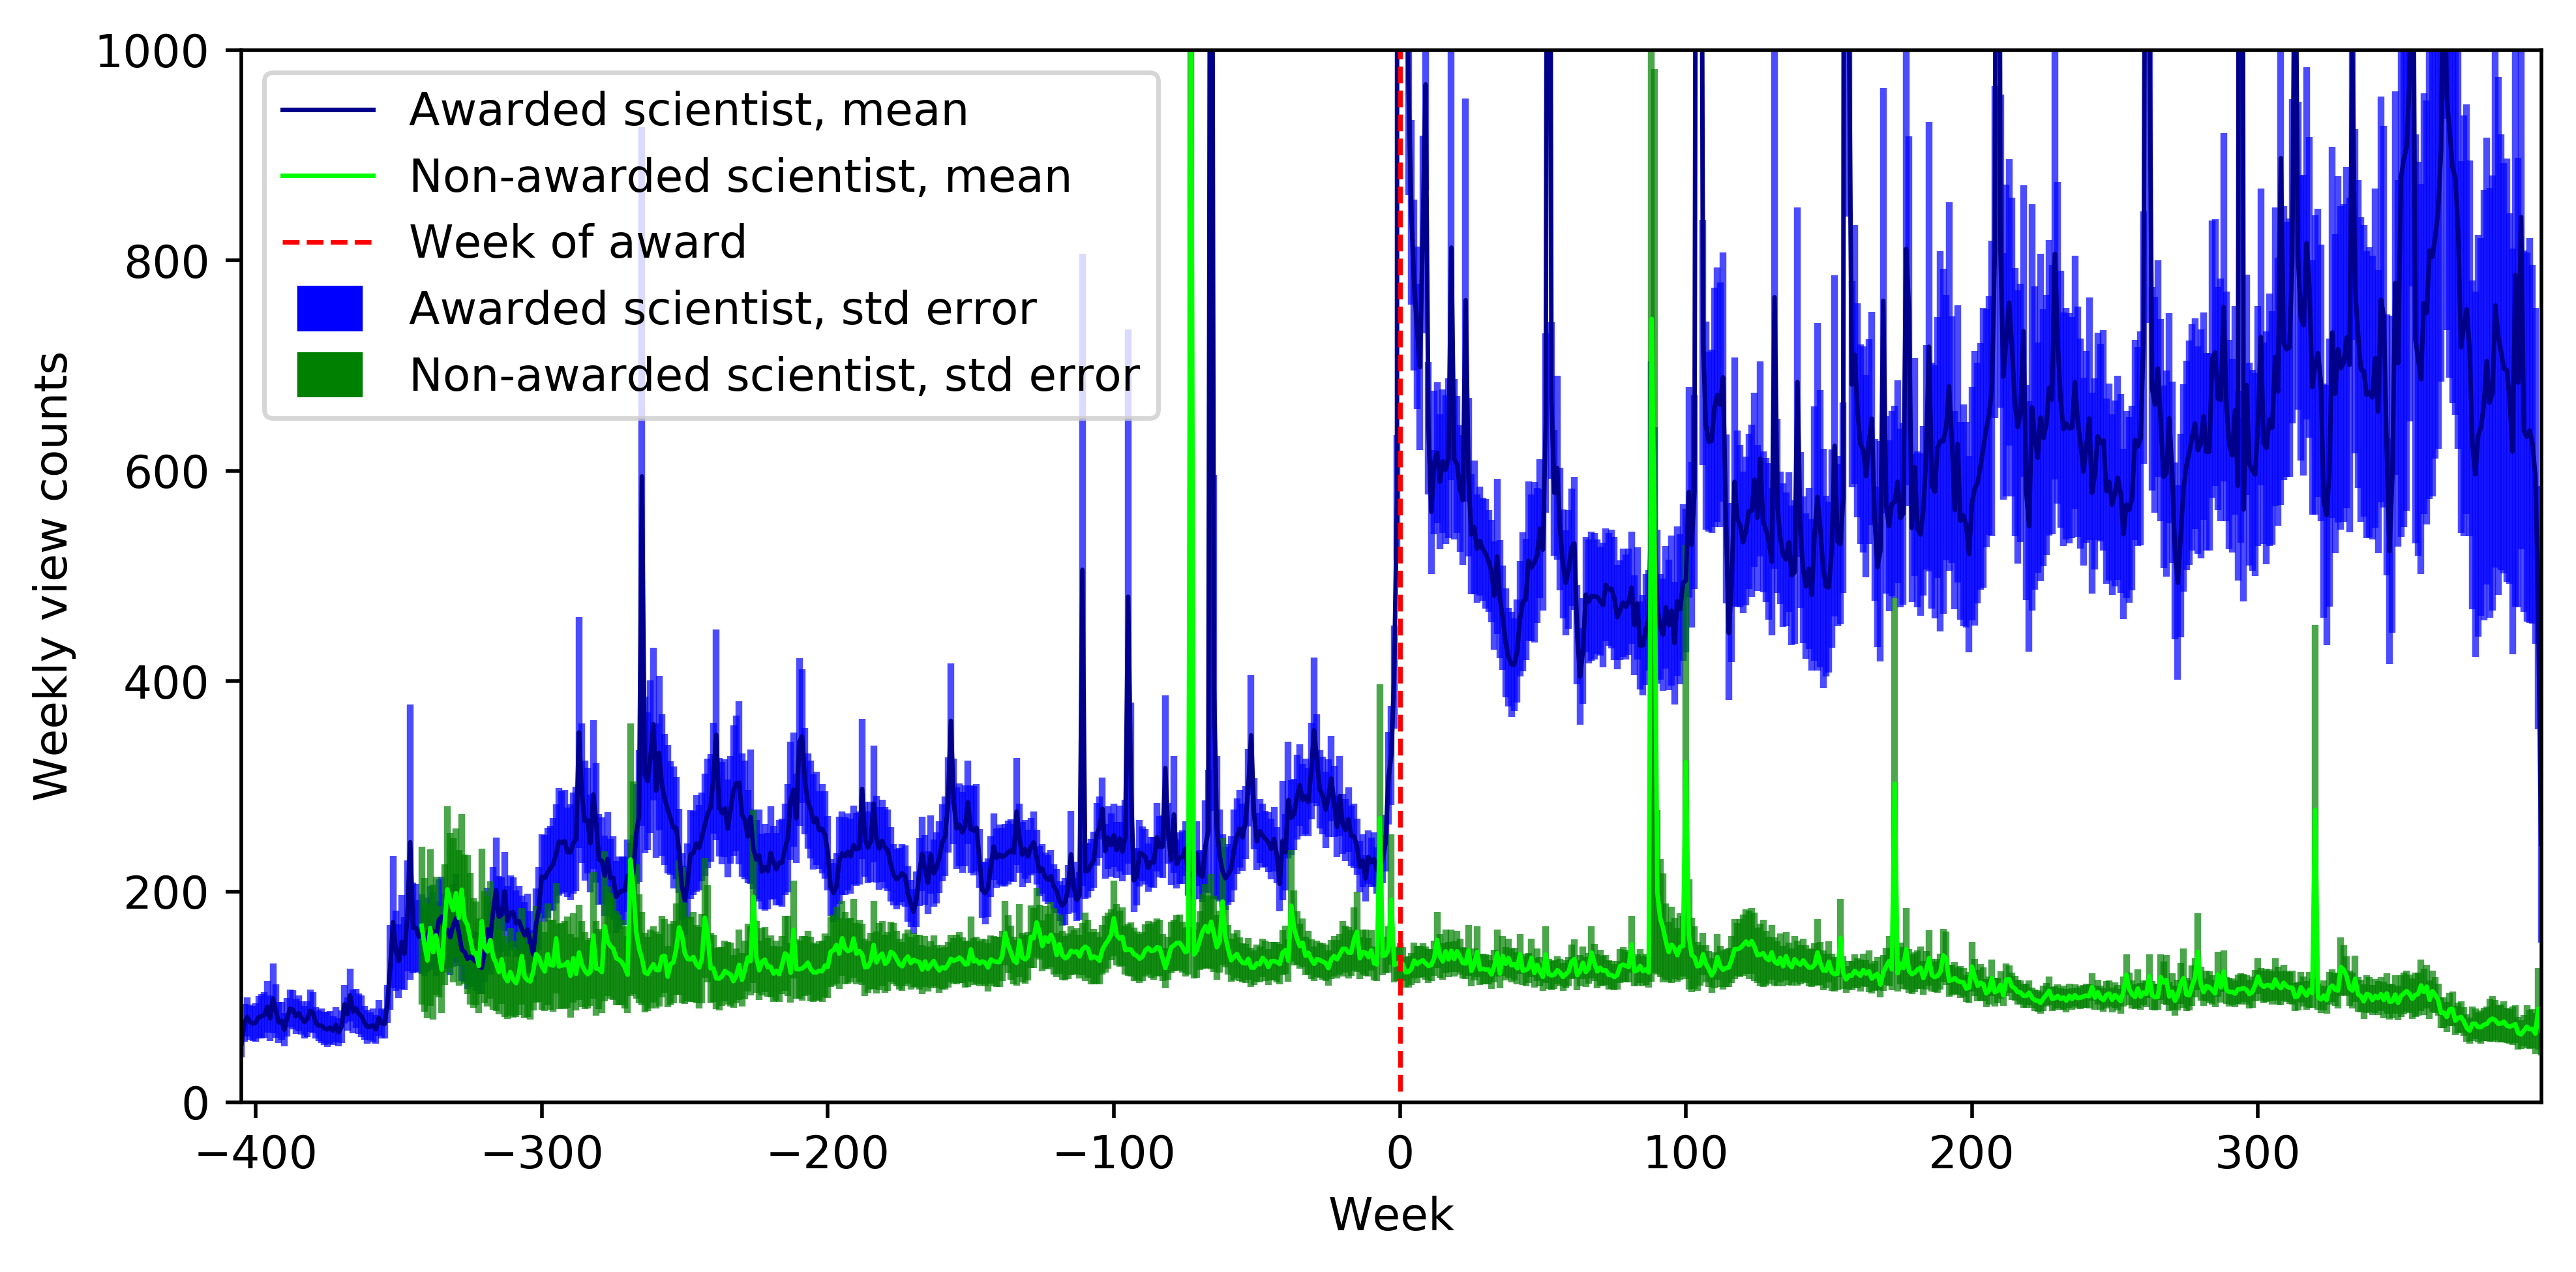

In [616]:
fig, (ax0) = plt.subplots(ncols=1, sharey=True,figsize=[8,4],dpi=500)

ax0.errorbar(df_s_w_st_aw.index.values, df_s_w_st_aw.mean_w, df_s_w_st_aw.std_1,c="b",alpha=0.7,#lw=2,
             linestyle='None',label="Awarded scientist, std error")#,label='_nolegend_')
ax0.plot(df_s_w_st_aw.index.values, df_s_w_st_aw.mean_w,c="darkblue",linewidth = 1,ms=4,label="Awarded scientist, mean")
ax0.set_xlim(df_s_w_st_aw.iloc[0].name,df_s_w_st_aw.iloc[-1].name)
ax0.set_ylim(0,1000)
ax0.set_xlabel("Week")
ax0.set_ylabel("Weekly view counts")


ax0.errorbar(df_s_w_st_naw.index.values, df_s_w_st_naw.mean_w, df_s_w_st_naw.std_1,c="green",alpha=0.7,#lw=2,
             linestyle='None',label="Non-awarded scientist, std error")#label='_nolegend_'
ax0.plot(df_s_w_st_naw.index.values, df_s_w_st_naw.mean_w,c="lime",linewidth = 1,ms=4,label="Non-awarded scientist, mean")
ax0.plot([0,0],[10,10000],"r--",label="Week of award",linewidth = 1)
leg=ax0.legend(loc=2,handler_map={ErrorbarContainer: HandlerErrorbar(numpoints=15,xpad=0.1)})
for lh in leg.legendHandles: 
    lh.set_alpha(1)

#plt.subplots_adjust(wspace=0.03, hspace=0.03)
plt.tight_layout()
plt.savefig("plots/view_count_2.pdf",dpi=500)
plt.show()

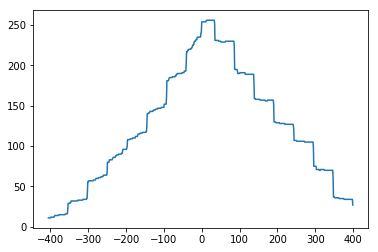

In [42]:
df_s_w_st_aw["count"].plot()

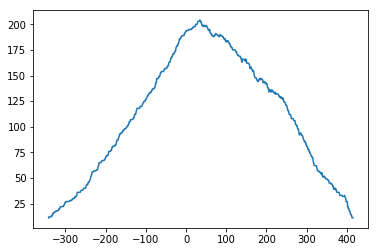

In [43]:
df_s_w_st_naw["count"].plot()

In [45]:
#print df_s_w_naw[df_s_w_naw.views.isnull()].article.unique()
#print df_s_w_naw [df_s_w_naw.article=="Axel_D._Becke"]["views"]
#print df_s_w_naw[df_s_w_naw.views.isnull()&(df_s_w_naw.all_topics_len!=0.0)].article.unique()

In [46]:
gg_temp=df_s_w_naw.groupby("article")
for art,s_art in gg_temp:
    if s_art["views"].isnull().all():
        print art

# Scientific topics

## about awarded scientists

In [47]:
def read_topic_txt(filename,topic_dir):
    topic_df=pd.DataFrame.from_csv(filename,sep="\t",index_col=None,header=None).rename(columns={0:"topic"})
    attention_dict = {}
    for topic in topic_df.topic.values:
        time_list=[]
        txtname = os.path.join(topic_dir + '\\' + topic + '.txt') 
        try:
            f = open(txtname)
            temp_time_list=[]
            for line in f:
                temp_time_list = map(int, line.split(','))[1:]
                time_list.extend(temp_time_list)
            len_time_list=len(time_list)
            #print len_time_list
            if len_time_list<3074:
                temp=[np.nan]*(3074-len(time_list))
                temp.extend(time_list)
                time_list=temp
            f.close()
            attention_dict.update({topic:time_list})
        except IOError:
            print txtname
            continue
    return attention_dict


seed_topic = read_topic_txt('data\\seed_topics_list.txt',"data\\topics_views")

data\topics_views\Chandy-Lamport_algorithm.txt
data\topics_views\N-group_(finite_group_theory).txt
data\topics_views\Quasi-maximum_likelihood_estimate.txt
data\topics_views\MM.txt
data\topics_views\Teichm%C3%BCller_space.txt
data\topics_views\%C3%85ngstr%C3%B6m.txt
data\topics_views\Journal_officiel_de_la_R%C3%A9publique_fran%C3%A7aise.txt
data\topics_views\Ng%C3%B4.txt
data\topics_views\N%C3%A9ron%E2%80%93Tate_height.txt
data\topics_views\Gromov%27s_inequality_for_complex_projective_space.txt
data\topics_views\Crossing_number_inequality.txt
data\topics_views\J%C3%A1nos_Bolyai_Mathematical_Society.txt
data\topics_views\P%C3%B3lya_conjecture.txt
data\topics_views\Rank_of_an_elliptic_curve.txt
data\topics_views\neu.txt
data\topics_views\Theta_wave.txt


In [48]:
df_s_topic=pd.DataFrame.from_dict(seed_topic)
#df_s_topic.describe()
print df_s_topic.count()

df_s_topic.set_index(pd.DatetimeIndex(start=datetime(2008,1,1),freq="D",periods=3074),inplace=True)
df_s_topic=df_s_topic.resample('W').sum()
df_s_topic=df_s_topic.T

%C3%89tale_cohomology                              3074
%CE%94-hyperbolic_space                            3074
(B,_N)_pair                                        3074
1,000,000,000                                      3074
1,2,3-Triazole                                     3074
15_and_290_theorems                                3074
1851_Research_Fellowship                           3074
30S                                                3074
3G                                                 3074
4Pi_microscope                                     3074
50S                                                3074
50_Most_Influential_(Bloomberg_Markets_ranking)    1613
51_Pegasi                                          3074
51_Pegasi_b                                        3074
55_Cancri_d                                        3074
55_Cancri_e                                        3074
ATP-sensitive_potassium_channel                    3074
A_Brief_History_of_Time_(film)                  

In [49]:
df_s_topic.head()

2008-01-06  2008-01-13  2008-01-20  2008-01-27  \
%C3%89tale_cohomology         154.0       207.0       196.0       175.0   
%CE%94-hyperbolic_space        17.0        37.0        23.0        43.0   
(B,_N)_pair                    45.0        74.0        71.0        71.0   
1,000,000,000                3658.0      5673.0      6106.0      6462.0   
1,2,3-Triazole                 85.0       130.0       148.0       121.0   

                         2008-02-03  2008-02-10  2008-02-17  2008-02-24  \
%C3%89tale_cohomology         227.0       193.0       234.0       186.0   
%CE%94-hyperbolic_space        40.0        44.0        27.0        28.0   
(B,_N)_pair                    57.0        66.0        73.0        49.0   
1,000,000,000                6221.0      6194.0      7167.0      7681.0   
1,2,3-Triazole                163.0       142.0       145.0       148.0   

                         2008-03-02  2008-03-09     ...      2016-04-03  \
%C3%89tale_cohomology         200.0       225.0     ...           231.0   
%CE%94-hyperbolic_space        44.0        26.0     ...            38.0   
(B,_N)_pair                    71.0        99.0     ...            46.0   
1,000,000,000                6892.0      7970.0     ...          7526.0   
1,2,3-Triazole                177.0       187.0     ...           250.0   

                         2016-04-10  2016-04-17  2016-04-24  2016-05-01  \
%C3%89tale_cohomology         190.0       240.0       219.0       184.0   
%CE%94-hyperbolic_space        74.0        72.0        61.0        71.0   
(B,_N)_pair                    60.0        48.0        31.0        46.0   
1,000,000,000                7864.0      7570.0      7668.0      7537.0   
1,2,3-Triazole                268.0       227.0       273.0       254.0   

                         2016-05-08  2016-05-15  2016-05-22  2016-05-29  \
%C3%89tale_cohomology         180.0       290.0       286.0       227.0   
%CE%94-hyperbolic_space        45.0        67.0        64.0        52.0   
(B,_N)_pair                    60.0        55.0        57.0        45.0   
1,000,000,000                7105.0      7104.0      7104.0      6670.0   
1,2,3-Triazole                221.0       250.0       235.0       205.0   

                         2016-06-05  
%C3%89tale_cohomology          48.0  
%CE%94-hyperbolic_space        21.0  
(B,_N)_pair                    14.0  
1,000,000,000                2029.0  
1,2,3-Triazole                 93.0  

[5 rows x 440 columns]

# plot topics



#remove views according to creation date

### clean datasets

In [50]:
with open("data/seed_topic_creation_date.json","r") as f:
    topic_aw_dict=json.load(f,encoding="utf-8")
df_aw_topic=pd.DataFrame.from_dict(topic_aw_dict,orient="index").rename(columns={0:"Page_created"})
#print df_aw_topic
print df_aw_topic[df_aw_topic.index.str.contains("space")]
df_aw_topic.Page_created=pd.to_datetime(df_aw_topic.Page_created)
df_aw_topic.Page_created=df_aw_topic.Page_created.apply(lambda x: x.date() )
df_aw_topic.set_index(df_aw_topic.index.str.replace(" ","_") ,inplace=True)

#print 
print df_aw_topic[df_aw_topic.index.str.contains("space")]

df_aw_topic["name_link"]=df_aw_topic.apply(lambda x: x.name.upper()[0]+ x.name[1:].split("#",1)[0].replace("_(number)",""),
                                           axis=1)
df_aw_topic.set_index(df_aw_topic["name_link"].str.encode("utf-8").values,inplace=True)
df_aw_topic[df_aw_topic.index.str.contains(",000")].index

                                                          Page_created
spacetime                                         2001-11-04T06:31:26Z
Deligne–Mumford moduli space of curves            2010-02-20T09:42:22Z
phase space                                       2003-03-02T21:56:14Z
polar space                                       2006-02-03T20:34:33Z
rigid analytic space                              2006-07-04T18:05:57Z
δ-hyperbolic space                                2004-12-16T15:00:34Z
Euclidean space                                   2001-08-27T19:16:37Z
Minkowski space                                   2003-05-20T13:28:35Z
Seven-dimensional space                           2009-12-24T14:44:20Z
Teichmüller space                                 2005-05-03T19:04:56Z
Gromov's inequality for complex projective space  2007-07-01T14:25:54Z
moduli space                                      2003-11-09T19:56:19Z
                                                 Page_created
spacetime      

Index([u'1,000,000,000'], dtype='object')

In [51]:
df_s_topic["name_link"]=df_s_topic.apply(lambda x: urllib.unquote(x.name),axis=1 )
df_s_topic.set_index(df_s_topic["name_link"].values,inplace=True)
df_s_topic.drop(columns="name_link",inplace=True)

print len(df_aw_topic)
print len(df_s_topic)
df_s_topic.drop_duplicates(inplace=True)
print len(df_s_topic)
df_aw_topic.drop_duplicates(inplace=True) 
print len(df_aw_topic)

# df_s_topic change change  R__rule_(ecology)  to R*_rule_(ecology)

2351
1895
1895
2173


In [52]:
#do not run if you have the file data/wikitopics_translation_dict.json

import wikipedia

df_new=df_s_topic.join(df_aw_topic, how='outer')#.index.values# inner-> 1506, left - 1895 rows
#df_new[(df_new.name_link.isnull() )| (df_new.iloc[:,425].isnull() )]


list_names= df_new[(df_new.iloc[:,425].isnull() )].index.values 
redir_duict=defaultdict() 
for wiki_link in list_names:
    try:
        wiki_p = wikipedia.page(wiki_link,auto_suggest=False)
        redir_duict[wiki_link]=wiki_p.title
    except (KeyboardInterrupt, SystemExit):
        raise
    except wikipedia.exceptions.DisambiguationError as e:
        print wiki_link
        print e.options
    except:
        print wiki_link

MD_
[u'Main droite', u'MiniDisc', u'Music director', u'MDs (TV series)', u"Materiali e discussioni per l'analisi dei testi classici", u'Mega Drive', u'McDonnell Douglas', u'Air Madagascar', u'Maryland', u'Moldova', u'Magdeburg', u'M\xf6dling District', u'metropolitan statistical area', u'Doctor of Medicine', u'Muscular dystrophy', u'Medial dorsal nucleus', u'.md', u'mkdir', u'Markdown', u'Message-digest algorithm', u'Microdrive', u'mdadm', u'Mean absolute difference', u'Mendelevium', u'Storm Prediction Center', u'Methyldichloroarsine', u'Millidarcy', u'Molecular dynamics', u'Managing director', u'Majority decision', u'Man-day', u'Major Douglas', u'Unicode subscripts and superscripts', u'Muhammad (name)', u'1500', u'Medium (disambiguation)']
R_rule_(ecology)


In [64]:
redir_duict['MD_']='MD'
redir_duict['R_rule_(ecology)']='R__rule_(ecology)'
redir_duict['1,000,000,000_(number)']='1,000,000,000'

redir_duict2=defaultdict()
for k,v in redir_duict.iteritems():
    redir_duict2[k]=v.replace(" ","_").encode("utf-8")
    
with open('data/wikitopics_translation_dict.json', 'w') as outfile:
    json.dump(redir_duict2, outfile,encoding="utf-8")

In [74]:
redir_duict3=load_simple_json('data/wikitopics_translation_dict.json')
new_redir_duict3=defaultdict()
for k,v in redir_duict3.iteritems():
    new_redir_duict3[k.decode("utf-8").encode("utf-8")]=v.decode("utf-8").encode("utf-8")

data/wikitopics_translation_dict.json


In [76]:
df_aw_topic["name_link"]=df_aw_topic.apply(lambda x:  new_redir_duict3[x.name]if x.name in list_names else x.name ,axis=1)
df_aw_topic.set_index(df_aw_topic["name_link"].values,inplace=True)
df_aw_topic.drop_duplicates(["name_link"],inplace=True)   

In [77]:
df_new=df_s_topic.join(df_aw_topic, how='outer')# inner1877 #left 1895
#df_new[(df_new.name_link.isnull() )]
list_names2= df_new[(df_new.name_link.isnull() )].index.values 

for wiki_link in list_names2:
    try:
        wiki_p = wikipedia.page(wiki_link,auto_suggest=False)
        redir_duict[wiki_link]=wiki_p.title
    except (KeyboardInterrupt, SystemExit):
        raise
    except wikipedia.exceptions.DisambiguationError as e:
        print wiki_link
        print e.options
    except:
        print wiki_link

List_of_minor_planets_3001–4000
List_of_minor_planets_48001–49000
List_of_minor_planets_5001–6000


In [78]:
redir_duict['List_of_minor_planets_3001–4000']='List_of_minor_planets:_3001–4000'
redir_duict['List_of_minor_planets_48001–49000']='List_of_minor_planets:_48001–49000'
redir_duict['List_of_minor_planets_5001–6000']='List_of_minor_planets:_5001–6000'

#redir_duict2=defaultdict()
for k,v in redir_duict.iteritems():
    redir_duict2[k]=v.replace(" ","_").encode("utf-8")
       
df_s_topic["name_link"]=df_s_topic.apply(lambda x:  redir_duict2[x.name]if x.name in list_names2 else x.name ,axis=1)
df_s_topic.set_index(df_s_topic["name_link"].values,inplace=True)
df_s_topic.drop(columns="name_link",inplace=True)
 
df_s_topic[df_s_topic.duplicated()]

Empty DataFrame
Columns: [2008-01-06 00:00:00, 2008-01-13 00:00:00, 2008-01-20 00:00:00, 2008-01-27 00:00:00, 2008-02-03 00:00:00, 2008-02-10 00:00:00, 2008-02-17 00:00:00, 2008-02-24 00:00:00, 2008-03-02 00:00:00, 2008-03-09 00:00:00, 2008-03-16 00:00:00, 2008-03-23 00:00:00, 2008-03-30 00:00:00, 2008-04-06 00:00:00, 2008-04-13 00:00:00, 2008-04-20 00:00:00, 2008-04-27 00:00:00, 2008-05-04 00:00:00, 2008-05-11 00:00:00, 2008-05-18 00:00:00, 2008-05-25 00:00:00, 2008-06-01 00:00:00, 2008-06-08 00:00:00, 2008-06-15 00:00:00, 2008-06-22 00:00:00, 2008-06-29 00:00:00, 2008-07-06 00:00:00, 2008-07-13 00:00:00, 2008-07-20 00:00:00, 2008-07-27 00:00:00, 2008-08-03 00:00:00, 2008-08-10 00:00:00, 2008-08-17 00:00:00, 2008-08-24 00:00:00, 2008-08-31 00:00:00, 2008-09-07 00:00:00, 2008-09-14 00:00:00, 2008-09-21 00:00:00, 2008-09-28 00:00:00, 2008-10-05 00:00:00, 2008-10-12 00:00:00, 2008-10-19 00:00:00, 2008-10-26 00:00:00, 2008-11-02 00:00:00, 2008-11-09 00:00:00, 2008-11-16 00:00:00, 2008-11-23 00:00:00, 2008-11-30 00:00:00, 2008-12-07 00:00:00, 2008-12-14 00:00:00, 2008-12-21 00:00:00, 2008-12-28 00:00:00, 2009-01-04 00:00:00, 2009-01-11 00:00:00, 2009-01-18 00:00:00, 2009-01-25 00:00:00, 2009-02-01 00:00:00, 2009-02-08 00:00:00, 2009-02-15 00:00:00, 2009-02-22 00:00:00, 2009-03-01 00:00:00, 2009-03-08 00:00:00, 2009-03-15 00:00:00, 2009-03-22 00:00:00, 2009-03-29 00:00:00, 2009-04-05 00:00:00, 2009-04-12 00:00:00, 2009-04-19 00:00:00, 2009-04-26 00:00:00, 2009-05-03 00:00:00, 2009-05-10 00:00:00, 2009-05-17 00:00:00, 2009-05-24 00:00:00, 2009-05-31 00:00:00, 2009-06-07 00:00:00, 2009-06-14 00:00:00, 2009-06-21 00:00:00, 2009-06-28 00:00:00, 2009-07-05 00:00:00, 2009-07-12 00:00:00, 2009-07-19 00:00:00, 2009-07-26 00:00:00, 2009-08-02 00:00:00, 2009-08-09 00:00:00, 2009-08-16 00:00:00, 2009-08-23 00:00:00, 2009-08-30 00:00:00, 2009-09-06 00:00:00, 2009-09-13 00:00:00, 2009-09-20 00:00:00, 2009-09-27 00:00:00, 2009-10-04 00:00:00, 2009-10-11 00:00:00, 2009-10-18 00:00:00, 2009-10-25 00:00:00, 2009-11-01 00:00:00, 2009-11-08 00:00:00, 2009-11-15 00:00:00, 2009-11-22 00:00:00, 2009-11-29 00:00:00, ...]
Index: []

[0 rows x 440 columns]

In [80]:
with open('data/wikitopics_translation_dict.json', 'w') as outfile:
    json.dump(redir_duict2, outfile,indent=4)


In [81]:
df_new=df_s_topic.join(df_aw_topic, how='left')
print df_new[(df_new.name_link.isnull()) ].index
df_new=df_s_topic.join(df_aw_topic, how='outer')
#df_new[(df_new.name_link.isnull() ) |(df_new.iloc[:,425].isnull())]

Index([u'Classified_information', u'German_diaspora', u'Hard_and_soft_science',
       u'Invention', u'Logic', u'Mechanism_design'],
      dtype='object')


In [82]:
df_new=df_s_topic.join(df_aw_topic, how='inner')
df_new.head(3)

2008-01-06 00:00:00  2008-01-13 00:00:00  \
Étale_cohomology                  154.0                207.0   
Δ-hyperbolic_space                 17.0                 37.0   
(B,_N)_pair                        45.0                 74.0   

                    2008-01-20 00:00:00  2008-01-27 00:00:00  \
Étale_cohomology                  196.0                175.0   
Δ-hyperbolic_space                 23.0                 43.0   
(B,_N)_pair                        71.0                 71.0   

                    2008-02-03 00:00:00  2008-02-10 00:00:00  \
Étale_cohomology                  227.0                193.0   
Δ-hyperbolic_space                 40.0                 44.0   
(B,_N)_pair                        57.0                 66.0   

                    2008-02-17 00:00:00  2008-02-24 00:00:00  \
Étale_cohomology                  234.0                186.0   
Δ-hyperbolic_space                 27.0                 28.0   
(B,_N)_pair                        73.0                 49.0   

                    2008-03-02 00:00:00  2008-03-09 00:00:00  \
Étale_cohomology                  200.0                225.0   
Δ-hyperbolic_space                 44.0                 26.0   
(B,_N)_pair                        71.0                 99.0   

                           ...          2016-04-17 00:00:00  \
Étale_cohomology           ...                        240.0   
Δ-hyperbolic_space         ...                         72.0   
(B,_N)_pair                ...                         48.0   

                    2016-04-24 00:00:00  2016-05-01 00:00:00  \
Étale_cohomology                  219.0                184.0   
Δ-hyperbolic_space                 61.0                 71.0   
(B,_N)_pair                        31.0                 46.0   

                    2016-05-08 00:00:00  2016-05-15 00:00:00  \
Étale_cohomology                  180.0                290.0   
Δ-hyperbolic_space                 45.0                 67.0   
(B,_N)_pair                        60.0                 55.0   

                    2016-05-22 00:00:00  2016-05-29 00:00:00  \
Étale_cohomology                  286.0                227.0   
Δ-hyperbolic_space                 64.0                 52.0   
(B,_N)_pair                        57.0                 45.0   

                    2016-06-05 00:00:00  Page_created           name_link  
Étale_cohomology                   48.0    2003-12-10    Étale_cohomology  
Δ-hyperbolic_space                 21.0    2004-12-16  Δ-hyperbolic_space  
(B,_N)_pair                        14.0    2005-04-21         (B,_N)_pair  

[3 rows x 442 columns]

In [ ]:
#remove views which corresponds to dates with no article exist
df_s_topic_new=df_new.apply(lambda x:[ i if type(j)==str else i if j.date() >= x["Page_created"] else np.nan  for i,j in zip(x,x.index)],axis=1)
df_s_topic_new.describe()    
df_s_topic_new.columns =df_s_topic_new.columns.map(lambda x:  x if type(x)==str else x.date())

In [87]:
df_s_topic_new.to_csv("data/awarded_topics_views.csv",sep="\t")

### assign scientists to each topic

In [84]:
with open("data/seed_neighbors_list_clean_en.json","r") as f:
    sc_topic_aw=json.load(f,encoding="utf-8")
sc_topic_aw2={}
for k,v in sc_topic_aw.iteritems():
    k=k.rstrip().split('/')[-1]
    sc_topic_aw2[k]=[ urllib.quote_plus(i.replace(" ","_").encode('utf8')) for i in v]
    
#clean topics which are corresponds to scientists 
sc_topic_aw3=defaultdict()
for article_name in sc_topic_aw2:
    #print article_name
    temp_list=[ urllib.unquote( i.upper()[0]+ i[1:].split('%23')[0] )   for i in sc_topic_aw2[article_name]]
    temp_list=[redir_duict2[i] if i in redir_duict2.keys() else i for i in temp_list ]
    sc_topic_aw3[article_name]=list(set(temp_list))

In [269]:
with open('data/baseline_neighbors_list_additional.json',"r") as f:
    Dump=json.load(f,encoding="utf-8")

In [268]:
def views_topic_mean_count(x,df_topics,sc_topic):#df_s_topic_new
    topic_list=sc_topic[x.article] #sc_topic_aw3
    topic_list_len=len(topic_list)
    #print x.time_w , x.article, x.week, topic_list_len
    if topic_list_len==0:
        global Dump
        if Dump.has_key(x.article):
            topic_list=Dump[x.article]
        else:
            return pd.Series([0, 0, None, None,[]])
    if x.time_w<datetime(2008,1,6).date():
        return pd.Series([topic_list_len, None, None, None, []])
    else:
        df_temp=df_topics[df_topics.index.isin(topic_list)][x.time_w]
        #print df_temp.mean(), df_temp.sem()
        #if topic_list_len!=len(df_temp):
        #    print df_temp.values
        #    print np.sort(topic_list)
        return pd.Series([topic_list_len, len(df_temp), df_temp.mean(), df_temp.sem(), df_temp.dropna().values])

In [88]:

df_s_w_aw[['all_topics_len','topics_at_time','views_mean',"views_sem","views_list"]]= df_s_w_aw.apply(lambda x: views_topic_mean_count(x,df_s_topic_new,sc_topic_aw3), axis=1)

In [92]:
df_s_w_aw.to_csv("data/awarded_topics_and_scientist_views_0week_is_award.csv",sep="\t")

In [640]:
df_sci_aw

Award_date Page_created  \
Ada_Yonath                       2009-10-07   2005-06-15   
Adam_Riess                       2010-10-05   2006-07-13   
Adrian_Bird                      2013-10-07   2009-02-05   
Aharon_Razin                     2013-10-07   2009-10-07   
Akira_Fujishima                  2012-10-10   2008-02-06   
Akira_Suzuki_(chemist)           2010-10-06   2010-03-21   
Alain_Aspect                     2011-10-04   2004-12-21   
Alan_Krueger                     2013-10-14   2006-08-23   
Alberto_Alesina                  2010-10-11   2007-06-24   
Allen_J._Bard                    2011-10-05   2008-07-07   
Alvin_E._Roth                    2012-10-15   2008-06-27   
Andre_Geim                       2008-10-07   2008-04-22   
Andrew_Viterbi                   2010-06-26   2003-09-24   
Angus_Deaton                     2012-10-15   2005-06-17   
Anne_Osborn_Krueger              2011-10-10   2004-03-05   
Anthony_Pawson                   2012-10-08   2005-03-11   
Anthony_R._Hunter                2012-10-08   2007-03-31   
Anton_Zeilinger                  2011-10-04   2004-08-21   
Arieh_Warshel                    2013-10-09   2007-08-19   
Armen_Alchian                    2008-10-13   2005-02-08   
Arthur_B._McDonald               2015-10-06   2007-11-02   
Artur_Avila                      2014-08-13   2009-07-12   
Aziz_Sancar                      2015-10-07   2006-06-06   
B._Jayant_Baliga                 2014-08-23   2010-08-22   
Barbara_Liskov                   2013-10-08   2005-02-15   
Bernd_Giese                      2009-10-07   2009-10-10   
Brian_Druker                     2011-10-03   2009-11-13   
Brian_Kobilka                    2012-10-10   2008-10-16   
Brian_Schmidt                    2010-10-05   2006-08-02   
Bruce_Ames                       2013-10-09   2004-07-22   
...                                     ...          ...   
Stephen_J._Lippard               2010-10-06   2010-04-16   
Stephen_Ross_(economist)         2012-10-15   2004-11-25   
Stephen_W._Scherer               2014-10-06   2010-10-15   
Steven_Van_Slyke                 2014-10-08   2006-11-28   
Takaaki_Kajita                   2015-10-06   2015-10-06   
Thomas_A._Steitz                 2009-10-07   2009-10-07   
Thomas_C._S%C3%BCdhof            2013-10-07   2010-04-08   
Thomas_Ebbesen                   2010-10-05   2008-11-15   
Thomas_J._Sargent                2008-10-13   2005-03-15   
Tomas_Lindahl                    2015-10-07   2008-11-10   
Tony_Atkinson                    2012-10-15   2006-03-13   
Toshihide_Maskawa                2008-10-07   2007-04-25   
Tu_Youyou                        2015-10-06   2011-09-12   
Venkatraman_Ramakrishnan         2009-10-07   2005-12-14   
Vera_Rubin                       2008-10-07   2004-02-17   
Victor_Ambros                    2008-10-06   2008-05-25   
Whitfield_Diffie                 2012-10-09   2004-01-11   
Willard_Boyle                    2009-10-06   2006-01-05   
William_Baumol                   2014-10-13   2004-12-07   
William_C._Campbell_(scientist)  2015-10-06   2015-10-05   
William_E._Moerner               2014-10-08   2006-07-04   
William_Nordhaus                 2009-10-12   2006-02-10   
William_Wootters                 2012-10-09   2006-01-15   
Winslow_Briggs                   2009-09-15   2015-09-27   
Yakir_Aharonov                   2009-10-06   2006-04-05   
Yakov_Sinai                      2014-03-26   2005-04-17   
Yoichiro_Nambu                   2008-10-07   2004-10-13   
Yoshinori_Ohsumi                 2015-07-29   2012-11-18   
Yoshinori_Tokura                 2014-10-07   2014-09-23   
Zhong_Lin_Wang                   2015-10-06   2015-10-06   

                                                     Name  Gender  \
Ada_Yonath                                     Ada Yonath  female   
Adam_Riess                                  Adam G. Riess    male   
Adrian_Bird                                   Adrian Bird    male   
Aharon_Razin                        

In [642]:
aa=[]
for k,v in sc_topic_aw3.iteritems():
    for i in v:
        aa.append((k,i))
print len(aa)

df_topic_scientist=pd.DataFrame.from_records( aa,columns=["scientists","article"])
df_topic_scientist=df_topic_scientist.join(df_s_topic_new[["Page_created"]],on="article")

df_sci_aw_special=df_sci_aw[["Award_date","Page_created","Field"]]
df_sci_aw_special.rename(columns={"Page_created":"Page_created_scientist"},inplace=True)

df_topic_scientist=df_topic_scientist.join(df_sci_aw_special[["Award_date","Page_created_scientist","Field"]],on="scientists")
df_topic_scientist.info()
df_topic_scientist.dropna(inplace=True)

2684
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2684 entries, 0 to 2683
Data columns (total 6 columns):
scientists                2684 non-null object
article                   2684 non-null object
Page_created              2651 non-null object
Award_date                2684 non-null object
Page_created_scientist    2684 non-null object
Field                     2684 non-null object
dtypes: object(6)
memory usage: 125.9+ KB


93.625047152
6.37495284798


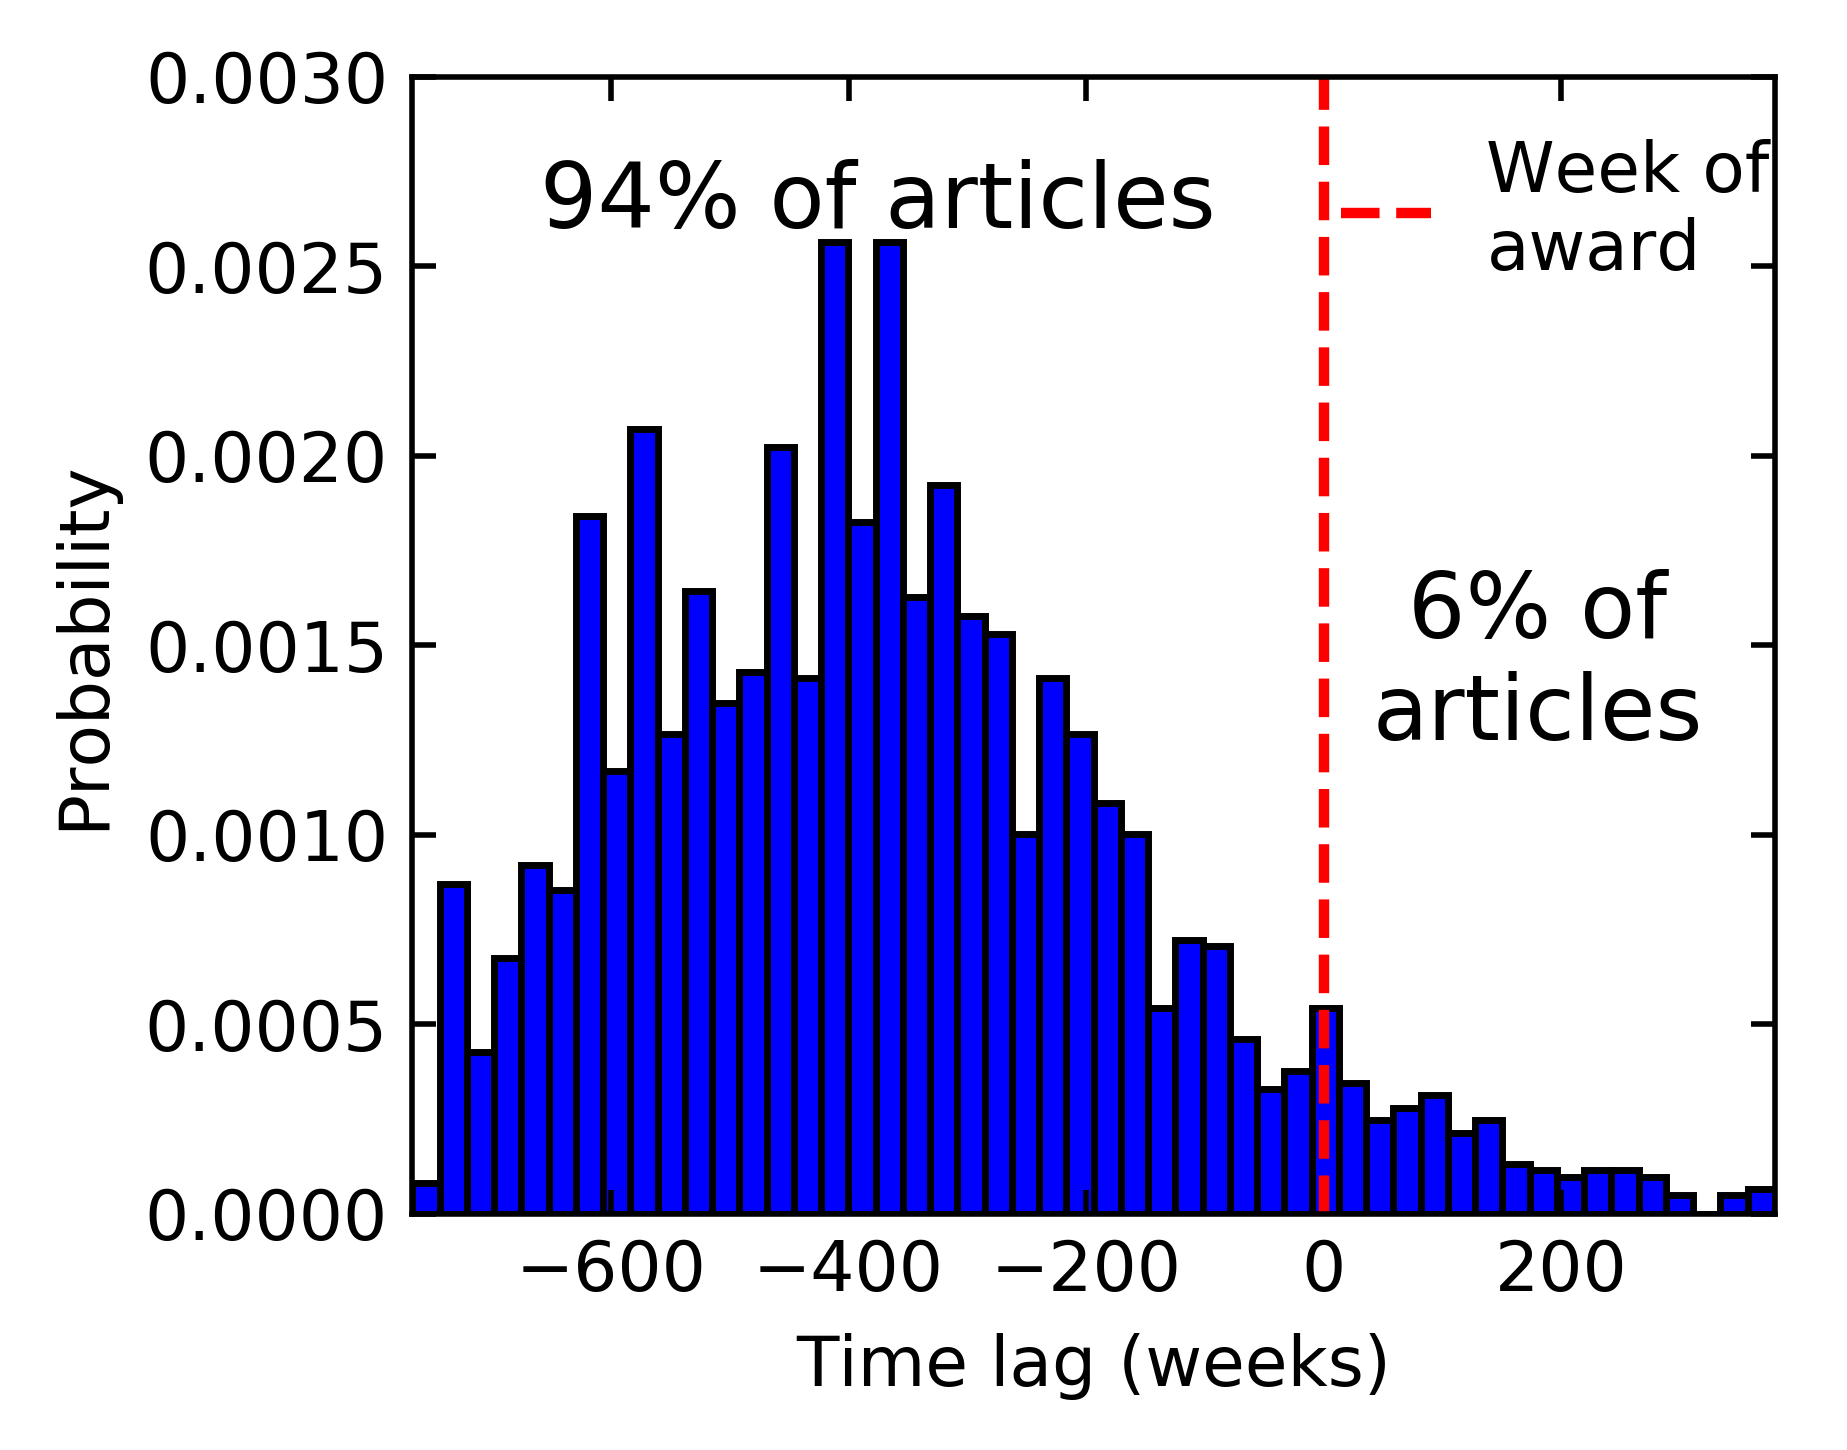

In [643]:
df_topic_scientist["time_lag_after_created_award"]=(df_topic_scientist["Page_created"]- df_topic_scientist["Award_date"]).astype('timedelta64[D]').astype(int)/7.

f = plt.figure(dpi=500,figsize=(3.75, 3))
plt.hist(df_topic_scientist["time_lag_after_created_award"].values,bins=50,normed=True,color="b",histtype='bar', ec='black')
plt.plot([0,0],[0,0.003],"r--",label="Week of\naward")
plt.xlim(df_topic_scientist["time_lag_after_created_award"].min(),df_topic_scientist["time_lag_after_created_award"].max())
plt.ylim(0,0.003)
plt.xlabel("Time lag (weeks)")
plt.ylabel("Probability")
plt.legend(frameon=False,loc='upper right', bbox_to_anchor=(1.042, 1),handlelength=1.3)


percent_below_t=100*float(len(df_topic_scientist[df_topic_scientist["time_lag_after_created_award"] <0]))/len(df_topic_scientist)
print percent_below_t  
percent_above_t=100*float(len(df_topic_scientist[df_topic_scientist["time_lag_after_created_award"] >=0]))/len(df_topic_scientist)
print percent_above_t  
plt.text(-375, 0.0026, "%i%% of articles"%(round(percent_below_t, 0)),fontdict={"size":13},ha='center')
plt.text(180, 0.00125, "%i%% of\narticles"%(round(percent_above_t, 0)),fontdict={"size":13},ha='center')

plt.tick_params(which="both",direction="in",top=True,right=True)
#plt.title("Research topics")
plt.tight_layout()
plt.savefig("plots/topics_time_lag_after_award_created_all.pdf",dpi=500)
plt.show()


In [656]:
df_topic_scientist[(df_topic_scientist.Page_created>=df_topic_scientist.Page_created_scientist)&(df_topic_scientist.Field=="Computer Science")][-50:]

scientists                          article Page_created  \
1821    Robert_H._Dennard                       IBM_Fellow   2004-04-10   
1841         Morris_Chang              Electronic_business   2007-07-12   
1934      Irwin_M._Jacobs                    1,000,000,000   2007-06-03   
1942       Andrew_Viterbi                    Anglicisation   2004-01-04   
1943       Andrew_Viterbi         Forward_error_correction   2005-03-20   
1945       Andrew_Viterbi  IEEE_Information_Theory_Society   2009-05-11   
1948       Andrew_Viterbi                          Trustee   2004-03-05   
2165        Silvio_Micali   Goldwasser–Micali_cryptosystem   2005-08-15   
2169        Silvio_Micali   Secure_multi-party_computation   2007-06-09   
2170        Silvio_Micali     Pseudorandom_function_family   2005-12-17   
2172        Silvio_Micali          Public-key_cryptography   2006-02-22   
2232  Michael_Stonebraker                     BSD_licenses   2006-08-05   
2233  Michael_Stonebraker                        DataBlade   2004-05-10   
2234  Michael_Stonebraker                            SciDB   2013-01-26   
2235  Michael_Stonebraker                           VoltDB   2010-05-27   
2236  Michael_Stonebraker        Federated_database_system   2004-12-12   
2237  Michael_Stonebraker                 Data_integration   2006-04-17   
2238  Michael_Stonebraker                            NoSQL   2009-08-13   
2239  Michael_Stonebraker                          C-Store   2005-09-01   
2240  Michael_Stonebraker                Ingres_(database)   2002-09-12   
2241  Michael_Stonebraker                          H-Store   2011-08-07   
2242  Michael_Stonebraker    Online_transaction_processing   2005-07-28   
2243  Michael_Stonebraker      Shared_nothing_architecture   2003-07-23   
2244  Michael_Stonebraker          Local_search_(Internet)   2005-10-18   
2246  Michael_Stonebraker                           SIGMOD   2006-07-09   
2247  Michael_Stonebraker                             VLDB   2006-05-19   
2248  Michael_Stonebraker                   Data_integrity   2007-03-23   
2249  Michael_Stonebraker             Column-oriented_DBMS   2006-09-06   
2250  Michael_Stonebraker               Query_optimization   2005-12-20   
2252  Michael_Stonebraker                         Illustra   2008-01-16   
2254  Michael_Stonebraker       Object-relational_database   2002-08-07   
2255  Michael_Stonebraker                      Time_series   2003-03-27   
2256  Michael_Stonebraker              Data_transformation   2006-12-05   
2257  Michael_Stonebraker                       PostgreSQL   2003-08-06   
2259  Michael_Stonebraker               Mainframe_computer   2014-02-25   
2261  Michael_Stonebraker                     IBM_System_R   2004-02-17   
2414     Whitfield_Diffie         Pohlig–Hellman_algorithm   2005-06-05   
2416     Whitfield_Diffie                 Key_distribution   2005-04-11   
2417     Whitfield_Diffie  IEEE_Information_Theory_Society   2009-05-11   
2425     Whitfield_Diffie          Public-key_cryptography   2006-02-22   
2497   Charles_P._Thacker                Computer_hardware   2009-03-04   
2499   Charles_P._Thacker              Microsoft_Tablet_PC   2010-09-28   
2500   Charles_P._Thacker                          SDS_940   2005-12-27   
2501   Charles_P._Thacker                  Tablet_computer   2006-02-24   
2504   Charles_P._Thacker               Local_area_network   2006-01-07   
2584          Judea_Pearl               Belief_propagation   2004-07-09   
2588          Judea_Pearl                 Bayesian_network   2005-03-08   
2590          Judea_Pearl                     Pearl_vortex   2012-01-04   
2591          Judea_Pearl                   Jewish_atheism   2008-09-01   
2593          Judea_Pearl                  Digital_Journal   2007-01-23   

      Award_date Page_created_scientist             Field  \
1821  2009-06-25             2004-03-22  Computer Science   
1841  2011-08-20             2005-08-13  Computer Science   
1934  

In [452]:
df_topic_scientist.article.value_counts() #1887 unique scientific article

Chemistry                             30
Physics                               30
Mathematics                           22
Biochemistry                          19
Economics                             19
Electrical_engineering                16
Macroeconomics                        14
Computer_science                      14
Molecular_biology                     13
Econometrics                          12
Quantum_mechanics                     12
Nanotechnology                         9
Biophysics                             9
Microeconomics                         8
Semiconductor                          7
Astrophysics                           7
Materials_science                      7
Behavioral_economics                   7
Quantum_computing                      7
DNA                                    7
Stem_cell                              6
Superconductivity                      6
Applied_physics                        6
Game_theory                            6
Quantum_informat

1887


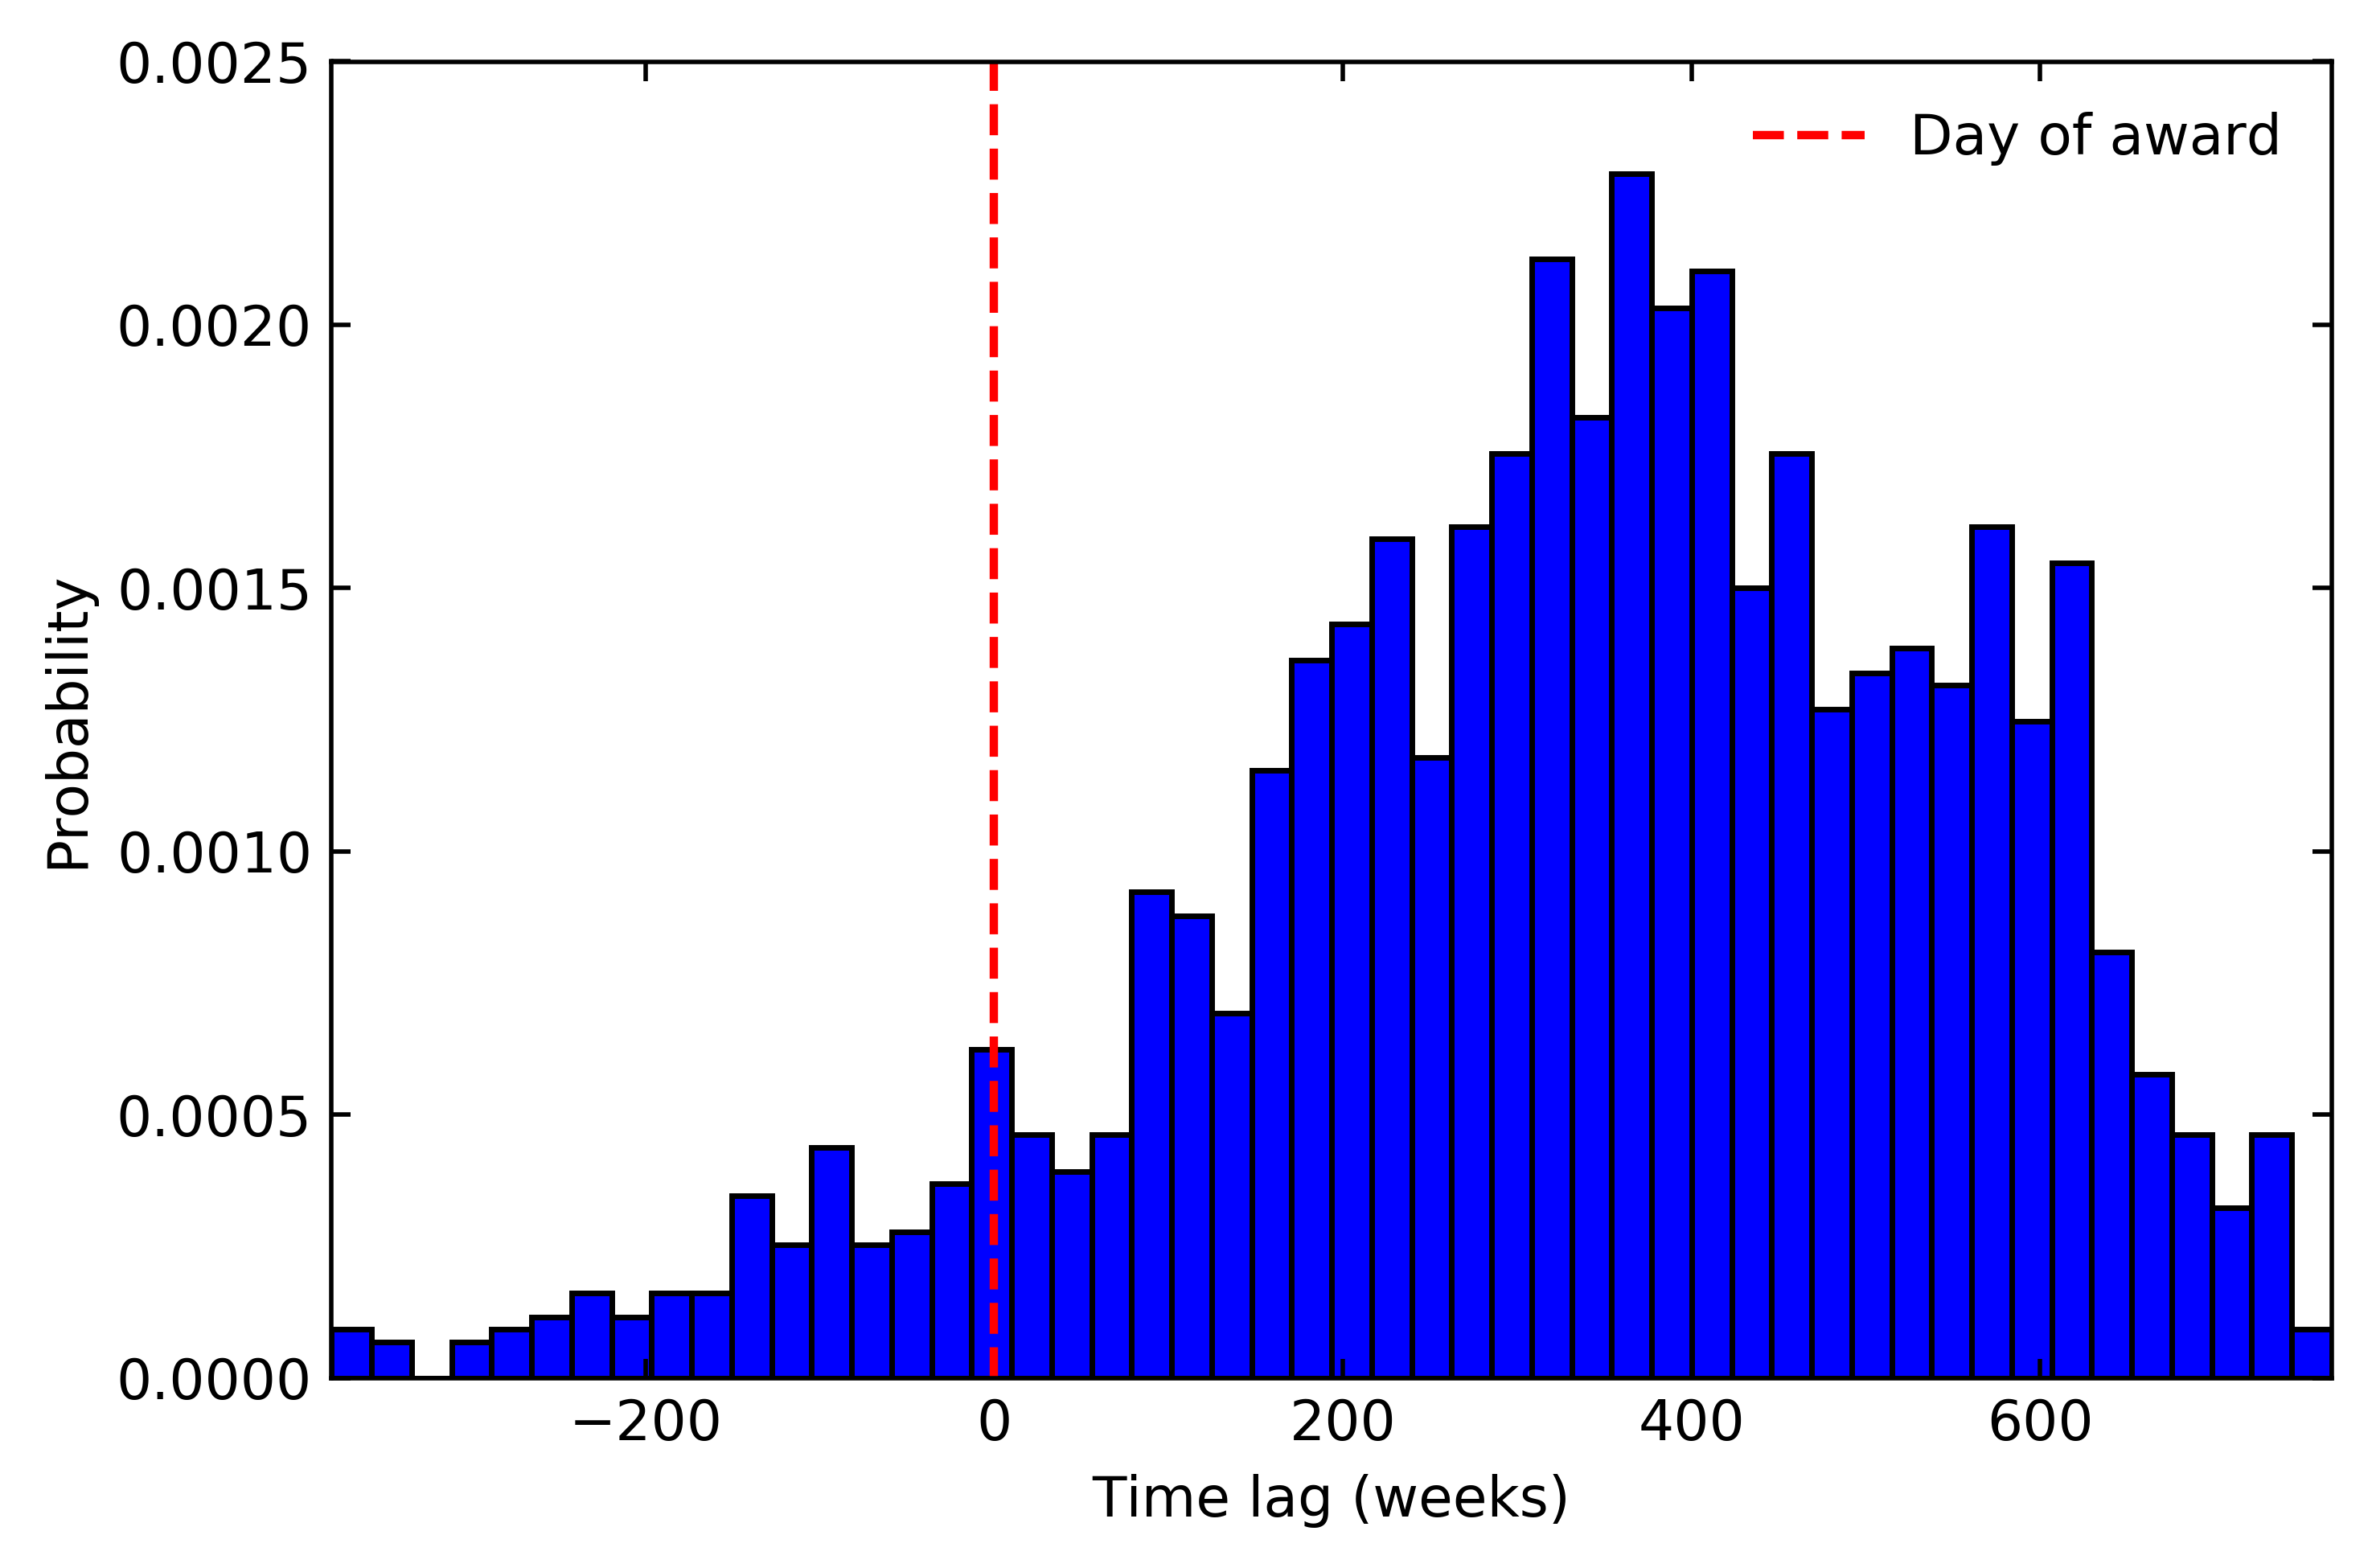

In [457]:
#remove duplicates. choose random author award date where we have duplicates

df_topic_scientist_without_duplicate=df_topic_scientist.sample(frac=1).drop_duplicates("article")
print len(df_topic_scientist_without_duplicate)

f = plt.figure(dpi=500)
plt.hist(df_topic_scientist_without_duplicate["time_lag_after_created_award"].values,bins=50,normed=True,color="b",histtype='bar', ec='black')
plt.plot([0,0],[0,0.0025],"r--",label="Day of award")
plt.xlim(df_topic_scientist_without_duplicate["time_lag_after_created_award"].min(),
         df_topic_scientist_without_duplicate["time_lag_after_created_award"].max())
plt.ylim(0,0.0025)
plt.xlabel("Time lag (weeks)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tick_params(which="both",direction="in",top=True,right=True)
#plt.title("Research topics")
plt.tight_layout()
plt.show()

1538


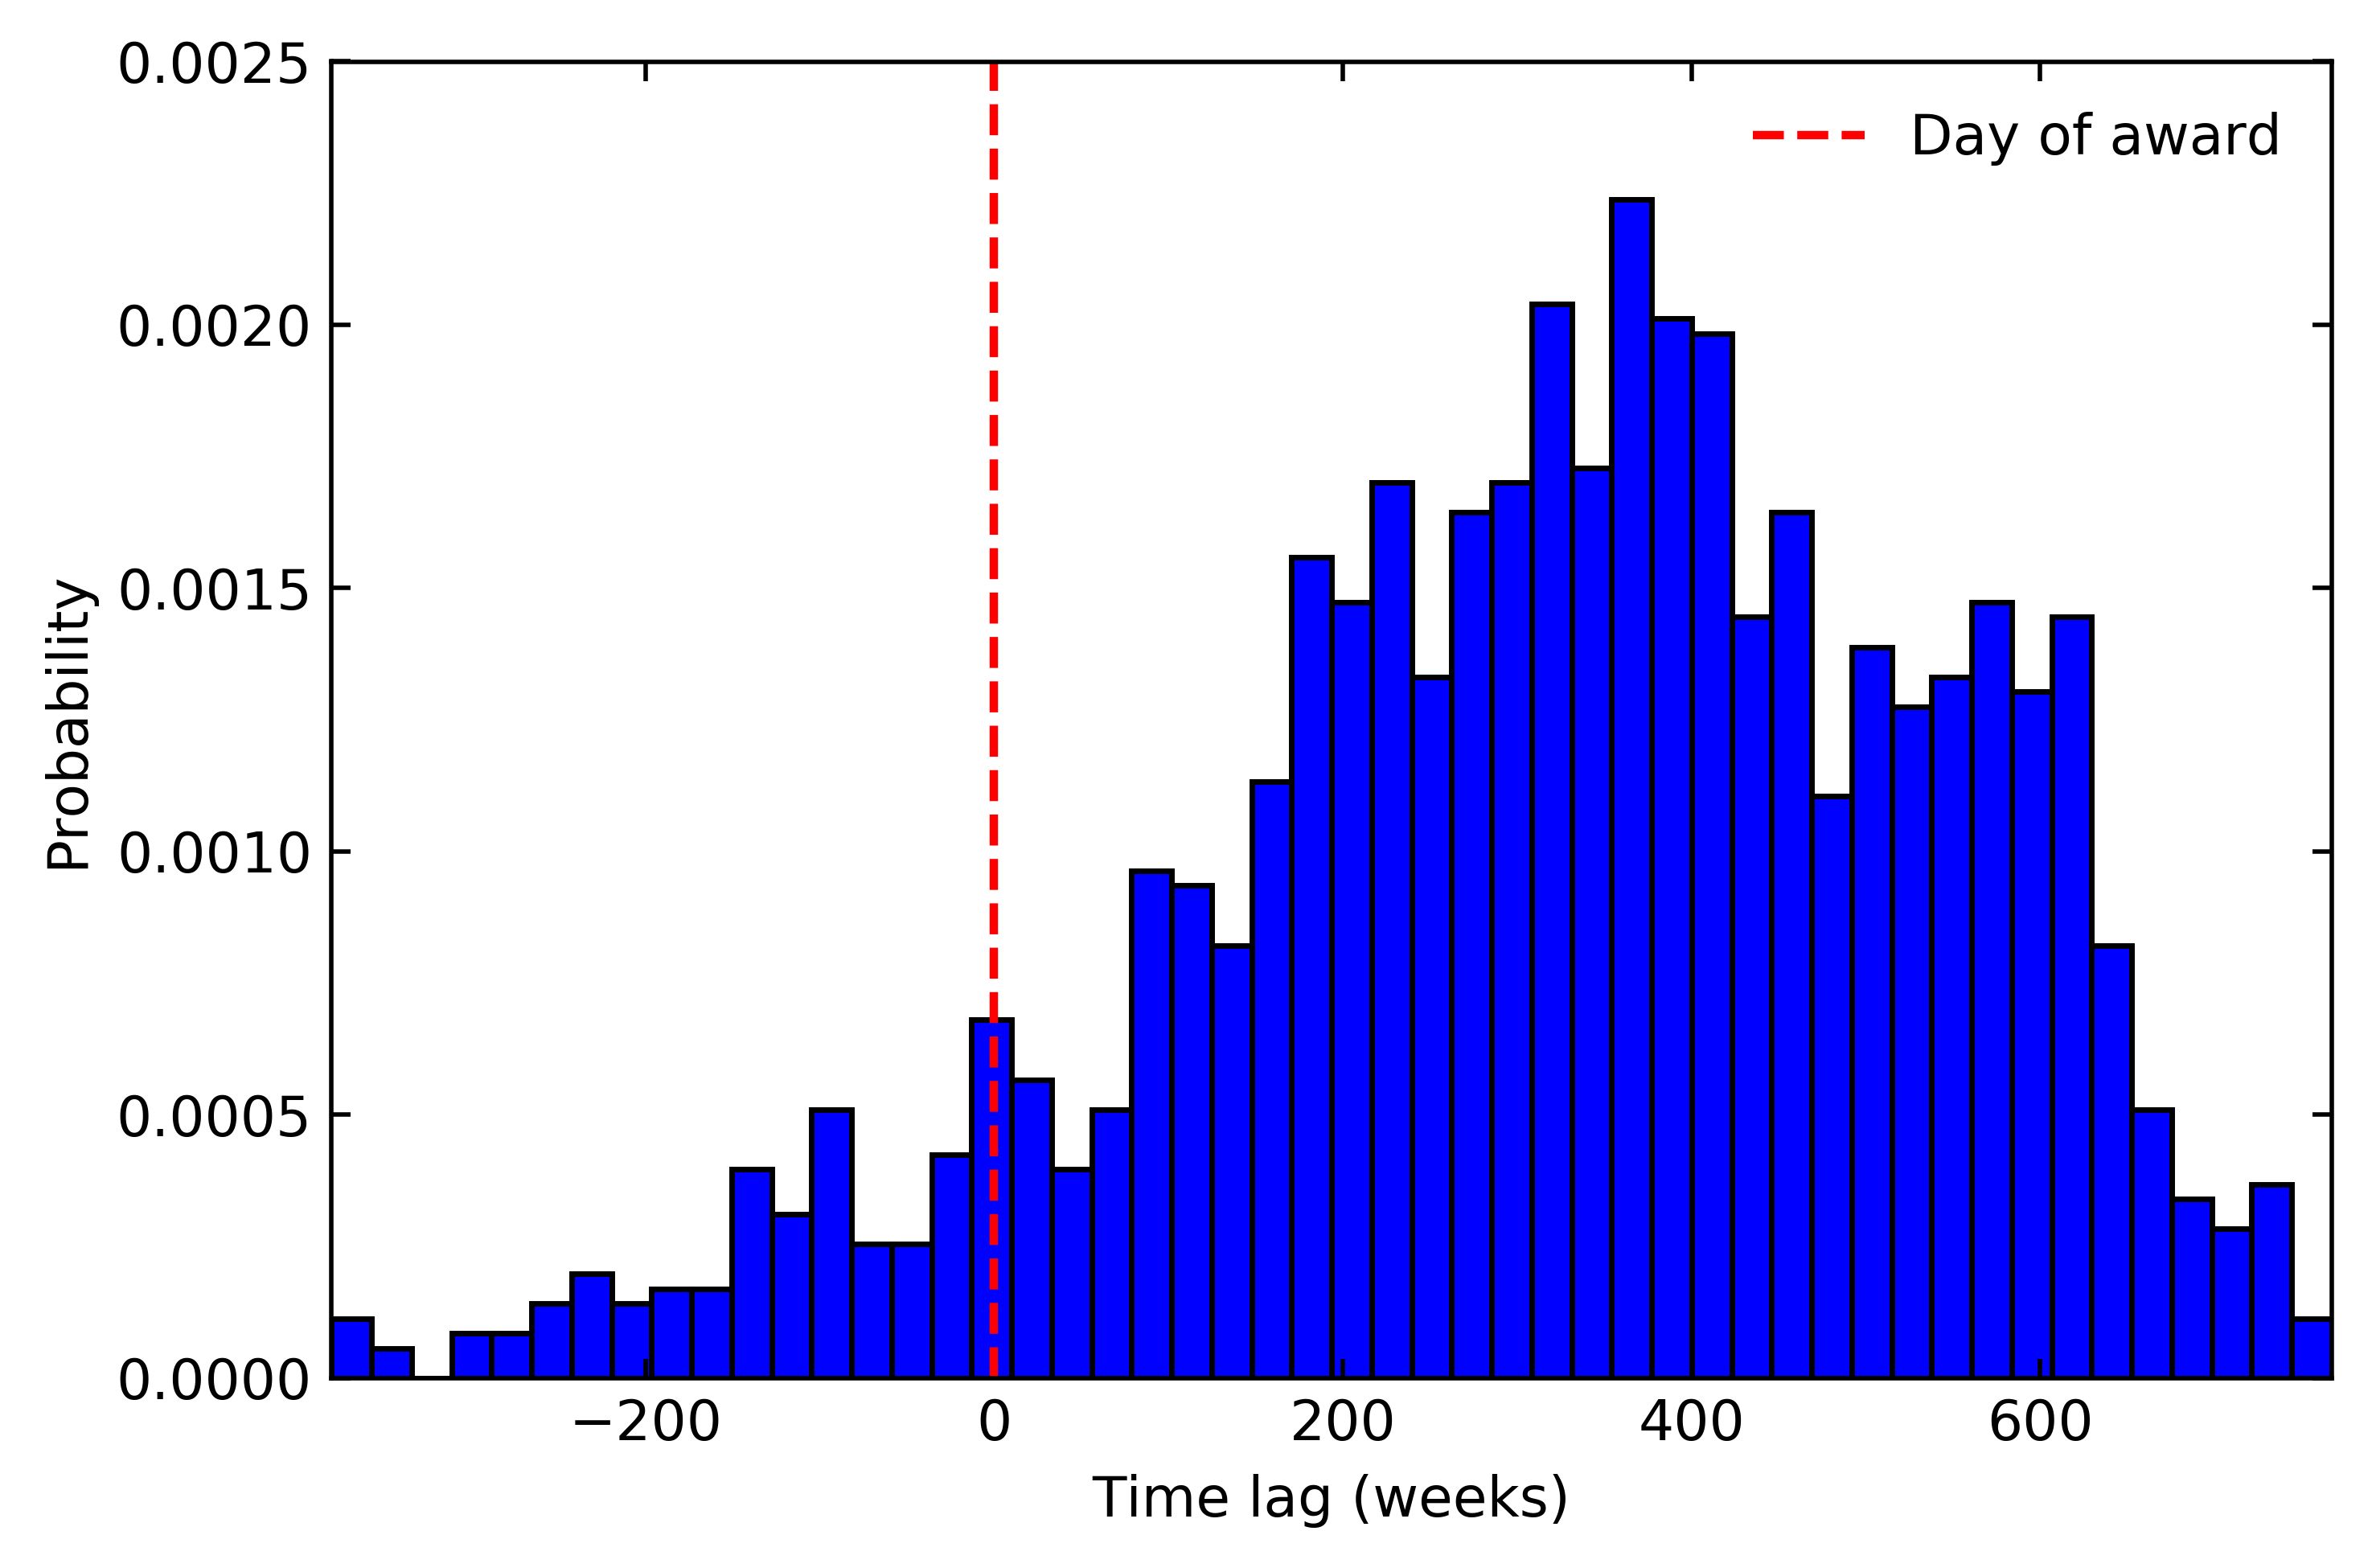

In [451]:
list_popular_topics=list(df_topic_scientist.article.value_counts()[:349].index)
df_topic_scientist_withoutpopular_topics=df_topic_scientist[~df_topic_scientist.article.isin(list_popular_topics)]
print len(df_topic_scientist_withoutpopular_topics)

f = plt.figure(dpi=500)
plt.hist(df_topic_scientist_withoutpopular_topics["time_lag_after_created_award"].values,bins=50,normed=True,color="b",histtype='bar', ec='black')
plt.plot([0,0],[0,0.0025],"r--",label="Day of award")
plt.xlim(df_topic_scientist_withoutpopular_topics["time_lag_after_created_award"].min(),
         df_topic_scientist_withoutpopular_topics["time_lag_after_created_award"].max())
plt.ylim(0,0.0025)
plt.xlabel("Time lag (weeks)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tick_params(which="both",direction="in",top=True,right=True)
#plt.title("Research topics")
plt.tight_layout()
plt.show()

In [89]:
df_s_w_aw.head(3)

time_w    views     article week  all_topics_len  topics_at_time  \
0  2009-10-11  37120.0  Ada_Yonath    0              18              18   
1  2009-10-18   5675.0  Ada_Yonath    1              18              18   
2  2009-10-25   2069.0  Ada_Yonath    2              18              18   

     views_mean    views_sem  \
0  16106.285714  4652.084900   
1  14767.642857  4297.524972   
2  14858.214286  4296.598780   

                                          views_list  
0  [15331.0, 16773.0, 33216.0, 21558.0, 198.0, 46...  
1  [13882.0, 16239.0, 31552.0, 20505.0, 77.0, 408...  
2  [13177.0, 15747.0, 33736.0, 20422.0, 58.0, 396...

In [90]:
df_s_w_aw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115280 entries, 0 to -1
Data columns (total 9 columns):
time_w            115280 non-null object
views             99357 non-null float64
article           115280 non-null object
week              115280 non-null object
all_topics_len    115280 non-null int64
topics_at_time    115280 non-null int64
views_mean        112164 non-null float64
views_sem         107342 non-null float64
views_list        115280 non-null object
dtypes: float64(3), int64(2), object(4)
memory usage: 8.8+ MB


In [91]:
print df_s_w_aw[df_s_w_aw.views_mean.isnull()&(df_s_w_aw.all_topics_len==0.0)].article.unique()
print df_s_w_aw[df_s_w_aw.views_mean.isnull()&(df_s_w_aw.all_topics_len!=0.0)].article.unique()
print sc_topic_aw3[u'Charles_Lee_(scientist)']
print sc_topic_aw3[u'Graham_Hutchings']
print sc_topic_aw3[u'Peter_Crane']
print sc_topic_aw3[u'Ramamoorthy_Ramesh']
print sc_topic_aw3[u'Winslow_Briggs']
print sc_topic_aw3[u'Yoshinori_Ohsumi']
print "\n"
print sc_topic_aw3[u'Graeme_Moad'] 
print sc_topic_aw3[u'Stephen_W._Scherer'] 

[u'Charles_Lee_(scientist)' u'Graham_Hutchings' u'Peter_Crane'
 u'Ramamoorthy_Ramesh' u'Winslow_Briggs' u'Yoshinori_Ohsumi']
[u'Graeme_Moad' u'Stephen_W._Scherer']
[]
[]
[]
[]
[]
[]


['Polymer_chemistry']
['Genome_Canada', 'Quirks_&_Quarks']


834
805
<class 'pandas.core.frame.DataFrame'>
Int64Index: 805 entries, -405 to 399
Data columns (total 5 columns):
count         805 non-null int64
count_all     805 non-null int64
mean_w        805 non-null float64
mean_w_all    805 non-null float64
std_1         805 non-null float64
dtypes: float64(3), int64(2)
memory usage: 37.7 KB


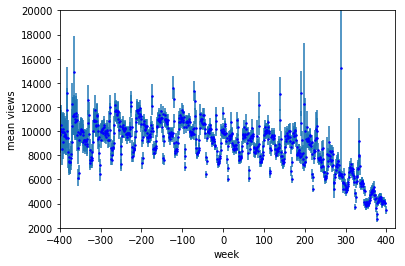

In [93]:
#group data by week number

g=df_s_w_aw.groupby("week")
s_w_st_dict_topic=defaultdict()
for week_name,series in g:
    concatenated = []
    for l in series.views_list.values:
        concatenated.extend(l) 
    #print concatenated
    s_w_st_dict_topic[week_name]={"mean_w":series.views_mean.mean(), "std_1":series.views_mean.sem(),
                           "count":series[~series.views_mean.isnull()].views_mean.count(),
                                "mean_w_all":np.mean(list(set(concatenated))),"count_all": len(set(concatenated)) }

df_s_w_st_topic=pd.DataFrame.from_dict(s_w_st_dict_topic,orient="index")
print len(df_s_w_st_topic)
df_s_w_st_topic=df_s_w_st_topic[df_s_w_st_topic["count"]>10]
print len(df_s_w_st_topic)
df_s_w_st_topic.info()


plt.errorbar(df_s_w_st_topic.index.values, df_s_w_st_topic.mean_w, df_s_w_st_topic.std_1,linestyle='None')
plt.plot(df_s_w_st_topic.index.values, df_s_w_st_topic.mean_w,".b",linewidth = 1,ms=3)
plt.xlim(-400,420)
plt.ylim(2000,20000)
plt.xlabel("week")
plt.ylabel("mean views");

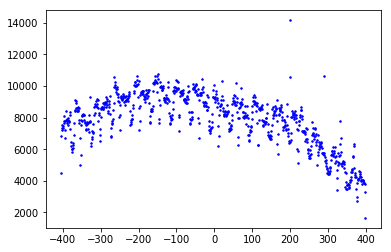

In [94]:
#plt.errorbar(df_s_w_st_topic.index.values, df_s_w_st_topic.mean_w_all, df_s_w_st_topic.std_1,linestyle='None')
plt.plot(df_s_w_st_topic.index.values, df_s_w_st_topic.mean_w_all,".b",linewidth = 1,ms=3)

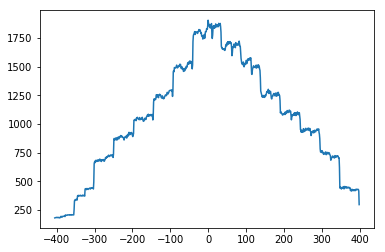

In [95]:
df_s_w_st_topic.count_all.plot()

In [96]:
df_s_w_aw[df_s_w_aw.week==-406]


time_w  views            article  week  all_topics_len  \
-406  2008-01-06    NaN  Charles_F._Manski  -406               8   
-406  2008-01-06   75.0       John_A._List  -406              19   
-406  2008-01-06   27.0   Richard_Blundell  -406               5   

      topics_at_time   views_mean    views_sem  \
-406               8  4784.000000  3035.481087   
-406              19  4002.214286  1700.090228   
-406               5  2967.400000  1066.481392   

                                             views_list  
-406  [3282.0, 22839.0, 72.0, 2395.0, 1846.0, 821.0,...  
-406  [3188.0, 2805.0, 147.0, 22839.0, 245.0, 777.0,...  
-406            [2035.0, 3282.0, 6654.0, 2752.0, 114.0]

## about non-awarded scientists

In [97]:
base_topic = read_topic_txt('data\\baseline_topics_list.txt',"data\\topics_views")
df_b_topic=pd.DataFrame.from_dict(base_topic)
#df_s_topic.describe()
#print df_b_topic.count()

df_b_topic.set_index(pd.DatetimeIndex(start=datetime(2008,1,1),freq="D",periods=3074),inplace=True)
df_b_topic=df_b_topic.resample('W').sum()
df_b_topic=df_b_topic.T

df_b_topic["name_link"]=df_b_topic.apply(lambda x: urllib.unquote(x.name),axis=1 )
df_b_topic.set_index(df_b_topic["name_link"].values,inplace=True)
df_b_topic.drop(columns="name_link",inplace=True)

data\topics_views\Carbon%E2%80%93hydrogen_bond_activation.txt
data\topics_views\Ease_of_doing_business_index.txt


In [98]:
with open("data/baseline_topic_creation_date.json","r") as f:
    topic_naw_dict=json.load(f,encoding="utf-8")
df_naw_topic=pd.DataFrame.from_dict(topic_naw_dict,orient="index").rename(columns={0:"Page_created"})
#df_aw_topic
df_naw_topic.Page_created=pd.to_datetime(df_naw_topic.Page_created)
df_naw_topic.Page_created=df_naw_topic.Page_created.apply(lambda x: x.date() )
df_naw_topic.set_index(df_naw_topic.index.str.replace(" ","_") ,inplace=True)
 
print df_naw_topic[df_naw_topic.index.str.contains("#")]["Page_created"]

df_naw_topic["name_link"]=df_naw_topic.apply(lambda x: x.name.upper()[0]+ x.name[1:].split("#",1)[0],axis=1)
df_naw_topic.set_index(df_naw_topic["name_link"].str.encode("utf-8").values,inplace=True)

Motivation#Intrinsic_and_extrinsic_motivation              2003-05-23
Photodissociation#Quantum_models                           2005-11-22
Government_of_Bulgaria#Structure_of_the_Current_Cabinet    2006-08-10
Spin_glass#The_model_of_Sherrington_and_Kirkpatrick        2002-11-18
Name: Page_created, dtype: object


In [99]:
print len(df_naw_topic)
print len(df_b_topic)

df_b_topic.drop_duplicates(inplace=True)
print len(df_b_topic)

df_naw_topic.drop_duplicates(inplace=True) 
print len(df_naw_topic)

1306
1068
1068
1198


In [100]:
df_new_b=df_b_topic.join(df_naw_topic, how='outer') # inner 853 #left  1068 
list_names3= df_new_b[(df_new_b.iloc[:,425].isnull() )].index.values 
#computing
for wiki_link in list_names3:
    try:
        wiki_p = wikipedia.page(wiki_link,auto_suggest=False)
        redir_duict[wiki_link]=wiki_p.title
    except (KeyboardInterrupt, SystemExit):
        raise
    except wikipedia.exceptions.DisambiguationError as e:
        print wiki_link
        print e.options
    except:
        print wiki_link

Adaptor_proteins
[u'Signal transducing adaptor protein', u'Vesicular transport adaptor protein', u'Clathrin adaptor protein']
Doug_Green
[u'Doug Green (footballer)', u'Doug Green (Louisiana politician)', u'Doug Green (Ohio politician)', u'Douglas B. Green', u'Douglas R. Green', u'Douglas Green (cricketer)', u'Doug Greenall']
Douglas_Green
[u'Doug Green (footballer)', u'Doug Green (Louisiana politician)', u'Doug Green (Ohio politician)', u'Douglas B. Green', u'Douglas R. Green', u'Douglas Green (cricketer)', u'Doug Greenall']
RAMP_hydrazone_alkylation_reaction


In [101]:
redir_duict['Adaptor_proteins']='Adaptor_proteins'
redir_duict['RAMP_hydrazone_alkylation_reaction']="Enders_SAMP/RAMP_hydrazone-alkylation_reaction"

for k,v in redir_duict.iteritems():
    redir_duict2[k]=v.replace(" ","_").encode("utf-8")

with open('data/wikitopics_translation_dict.json', 'w') as outfile:
    json.dump(redir_duict2, outfile,indent=4)

In [102]:
df_naw_topic["name_link"]=df_naw_topic.apply(lambda x:  redir_duict2[x.name] if (x.name in list_names3)&(x.name in redir_duict.keys())  else x.name ,axis=1)
df_naw_topic.set_index(df_naw_topic["name_link"].values,inplace=True)
df_naw_topic.drop_duplicates(["name_link"],inplace=True)   

print len(df_b_topic)
print len(df_naw_topic)

1068
1075


In [103]:
df_new_b=df_b_topic.join(df_naw_topic, how='outer')# inner 1057 #left 1068
list_names4= df_new_b[(df_new_b.name_link.isnull() )].index.values 
print len(list_names4)

for wiki_link in list_names4:
    try:
        wiki_p = wikipedia.page(wiki_link,auto_suggest=False)
        redir_duict[wiki_link]=wiki_p.title
    except (KeyboardInterrupt, SystemExit):
        raise
    except wikipedia.exceptions.DisambiguationError as e:
        print wiki_link
        print e.options
    except:
        print wiki_link

11
RAMP_hydrazone-alkylation_reaction


In [104]:
redir_duict['RAMP_hydrazone-alkylation_reaction']="Enders_SAMP/RAMP_hydrazone-alkylation_reaction"

for k,v in redir_duict.iteritems():
    redir_duict2[k]=v.replace(" ","_").encode("utf-8")
    
with open('data/wikitopics_translation_dict.json', 'w') as outfile:
    json.dump(redir_duict2, outfile,indent=4)
    
df_b_topic["name_link"]=df_b_topic.apply(lambda x:  redir_duict2[x.name]if x.name in list_names4 else x.name ,axis=1)

df_b_topic.set_index(df_b_topic["name_link"].values,inplace=True)
df_b_topic.drop(columns="name_link",inplace=True)

In [105]:
df_new_b=df_b_topic.join(df_naw_topic, how='inner') # 
#df_new_b[(df_new_b.name_link.isnull() ) |(df_new_b.iloc[:,425].isnull())]
#df_new_b[(df_new_b.name_link.isnull() ) | ()].index.values 

In [106]:
df_new_b.head(3)

2008-01-06 00:00:00  2008-01-13 00:00:00  \
Hyperbolic_metric_space                 17.0                 37.0   
3-manifold                             344.0                468.0   
5G                                     191.0                181.0   

                         2008-01-20 00:00:00  2008-01-27 00:00:00  \
Hyperbolic_metric_space                 23.0                 43.0   
3-manifold                             525.0                459.0   
5G                                     225.0                170.0   

                         2008-02-03 00:00:00  2008-02-10 00:00:00  \
Hyperbolic_metric_space                 40.0                 44.0   
3-manifold                             495.0                489.0   
5G                                     199.0                266.0   

                         2008-02-17 00:00:00  2008-02-24 00:00:00  \
Hyperbolic_metric_space                 27.0                 28.0   
3-manifold                             415.0                500.0   
5G                                     268.0                201.0   

                         2008-03-02 00:00:00  2008-03-09 00:00:00  \
Hyperbolic_metric_space                 44.0                 26.0   
3-manifold                             474.0                431.0   
5G                                     228.0                206.0   

                                  ...             2016-04-17 00:00:00  \
Hyperbolic_metric_space           ...                            72.0   
3-manifold                        ...                           460.0   
5G                                ...                          7949.0   

                         2016-04-24 00:00:00  2016-05-01 00:00:00  \
Hyperbolic_metric_space                 61.0                 71.0   
3-manifold                             476.0                412.0   
5G                                    8086.0               8412.0   

                         2016-05-08 00:00:00  2016-05-15 00:00:00  \
Hyperbolic_metric_space                 45.0                 67.0   
3-manifold                             389.0                445.0   
5G                                    7628.0               8929.0   

                         2016-05-22 00:00:00  2016-05-29 00:00:00  \
Hyperbolic_metric_space                 64.0                 52.0   
3-manifold                             543.0                470.0   
5G                                    8018.0               8145.0   

                         2016-06-05 00:00:00  Page_created  \
Hyperbolic_metric_space                 21.0    2007-08-28   
3-manifold                             124.0    2004-09-26   
5G                                    2711.0    2009-07-03   

                                       name_link  
Hyperbolic_metric_space  Hyperbolic_metric_space  
3-manifold                            3-manifold  
5G                                            5G  

[3 rows x 442 columns]

In [107]:
#remove views which corresponds to dates with no article exist

df_b_topic_new=df_new_b.apply(lambda x:[ i if type(j)==str else i if j.date() >= x["Page_created"] else np.nan  for i,j in zip(x,x.index)],axis=1)
df_b_topic_new.describe()    
df_b_topic_new.columns =df_b_topic_new.columns.map(lambda x:  x if type(x)==str else x.date())

In [108]:
df_b_topic_new.to_csv("data/non-awarded_topics_views.csv",sep="\t")

# Intersection of topics

In [110]:
#translate
list_non_award_topics=[ redir_duict2[i] if i in redir_duict2.keys() else i for i in df_new_b.index.values ]
list_award_topics=[ redir_duict2[i] if i in redir_duict2.keys() else i for i in df_new.index.values ]

print "len of non-award scientific topics", len(set(list_non_award_topics))
print "len of awarded scientific topics", len(set(list_award_topics))
intersection_topic=set(list_non_award_topics).intersection(set(list_award_topics))
len_int=len(set(list_non_award_topics).intersection(set(list_award_topics)))
print "len of intersection", len_int
print float(len_int)/len(set(list_non_award_topics))
print float(len_int)/len(set(list_award_topics))

len of non-award scientific topics 1064
len of awarded scientific topics 1889
len of intersection 299
0.281015037594
0.158284806776


In [111]:
intersection_topic

{'Adaptive_immune_system',
 'Alcohol',
 'Algebra',
 'Algorithm',
 'Angiogenesis',
 'Antibiotics',
 'Antibody',
 'Applied_physics',
 'Artificial_intelligence',
 'Astronomy',
 'Astrophysics',
 'Autoimmune_disease',
 'Autoimmunity',
 'Bacteria',
 'Battery_(electricity)',
 'Behavioral_economics',
 'Biochemistry',
 'Bioinorganic_chemistry',
 'Biological_engineering',
 'Biology',
 'Biomaterial',
 'Biomedical_engineering',
 'Biomolecule',
 'Biophysics',
 'Black_hole',
 'Blog',
 'Bone_marrow',
 'Bose\xe2\x80\x93Einstein_condensate',
 'Boson',
 'Bounded_rationality',
 'Caenorhabditis_elegans',
 'Cancer',
 'Carbon_nanotube',
 'Carbon\xe2\x80\x93carbon_bond',
 'Cardiovascular_disease',
 'Catalysis',
 'Causality',
 'Cellular_automaton',
 'Cellular_differentiation',
 'Chemical_engineering',
 'Chemical_physics',
 'Chemical_synthesis',
 'Chemical_vapor_deposition',
 'Chemistry',
 'Chromatin',
 'Clinical_research',
 'Cloning',
 'Cointegration',
 'Colorectal_cancer',
 'Colossal_magnetoresistance',
 'Co

In [112]:
np.sort(list(set(list_award_topics)-set(list_non_award_topics)))

array(['(B,_N)_pair', '1,000,000,000', '1,2,3-Triazole', ..., 'Zoology',
       'Zuse_Institute_Berlin', '\xc3\x89tale_cohomology'],
      dtype='|S63')

1064
1889


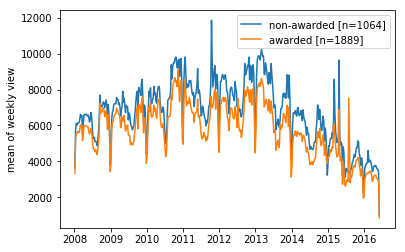

In [113]:
print len(df_b_topic_new)
print len(df_s_topic_new)
df_b_topic_new.mean().plot(label="non-awarded [n=1064]")
df_s_topic_new.mean().plot(label="awarded [n=1889]")
plt.ylabel("mean of weekly view")
plt.legend()

766
1591


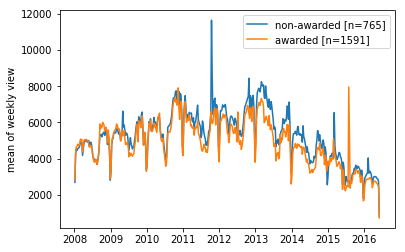

In [114]:
print len(df_b_topic_new[~df_b_topic_new.index.isin(intersection_topic)])
print len(df_s_topic_new[~df_s_topic_new.index.isin(intersection_topic)])
df_b_topic_new[~df_b_topic_new.index.isin(intersection_topic)].mean().plot(label="non-awarded [n=765]")
df_s_topic_new[~df_s_topic_new.index.isin(intersection_topic)].mean().plot(label="awarded [n=1591]")
plt.ylabel("mean of weekly view")
plt.legend()

### assign topics to scientists

In [115]:
with open("data/baseline_neighbors_list_clean_en.json","r") as f:
    sc_topic_naw=json.load(f,encoding="utf-8")
sc_topic_naw2={}
for k,v in sc_topic_naw.iteritems():
    k=k.rstrip().split('/')[-1]
    sc_topic_naw2[k]=[ urllib.quote_plus(i.replace(" ","_").encode('utf8')) for i in v]
    
#clean topics which are corresponds to scientists 
sc_topic_naw3=defaultdict()
for article_name in sc_topic_naw2:
    temp_list=[ urllib.unquote( i.upper()[0]+ i[1:].split('%23')[0] )   for i in sc_topic_naw2[article_name]]
    temp_list=[redir_duict2[i] if i in redir_duict2.keys() else i for i in temp_list ]
    sc_topic_naw3[article_name]=list(set(temp_list))

In [116]:
dict_name={u'%C4%90%C3%A0m_Thanh_S%C6%A1n':"Dam_Thanh_Son",  u'%C5%BDeljko_Reiner':"Zeljko_Reiner",
 u'Achim_M%C3%BCller':"Achim_Muller",                u'Albert-L%C3%A1szl%C3%B3_Barab%C3%A1si':"Albert-Laszlo_Barabasi",
 u'Andrew_H._Van_de_Ven':"Andrew_Van_de_Ven",        u'Axel_D._Becke':"Axel_Becke",
 u'Bengt_R._Holmstr%C3%B6m':"Bengt_Holmstrom",       u'Bruce_D._Walker':"Bruce_D_Walker",
 u'C._N._R._Rao':"C_N_R_Rao",                        u'Charles_M._Lieber':"Charles_Lieber",
 u'Chen_Guanrong':"Guanrong_Chen",                   u'Daron_Acemo%C4%9Flu':"Daron_Acemoglu",
 u'Dennis_P._Curran':"Dennis_Curran",                u'Edward_R._Dougherty':"Edward_R_Dougherty",
 u'Elias_James_Corey':"Elias_Corey",                 u'Fran%C3%A7ois_Diederich':"Francois_Diederich",
 u'G%C3%A1bor_A._Somorjai':"Gabor_Somorjai",         u'G%C3%A9rald_Bastard':"Gerald_Bastard",
 u'G%C3%A9rard_F%C3%A9rey':"Gerard_Ferey",           u'Gon%C3%A7alo_Abecasis':"Gon%C3%A7alo_R_Abecasis",
 u'Horst_St%C3%B6cker':"Horst_Stocker",              u'Hyeon_Taeghwan':"Taeghwan_Hyeon",
 u'Ian_F._Akyildiz':"Ian_f_akyildiz",                u'Ivan_K._Schuller':"Ivan_Schuller",
 u'Jean-Luc_Br%C3%A9das':"Jean-Luc_Bredas",          u'Jean-Michel_Sav%C3%A9ant':"Jean-Michel_Saveant",
 u'Jean_Fr%C3%A9chet':"Jean_Frechet",                u'Joan_Massagu%C3%A9_Sol%C3%A9':"Joan_Massague",
 u'Joann_E._Manson':"Joann_E_Manson",                u'John_A._List':"John_A_List",
 u'Juan_Mart%C3%ADn_Maldacena':"Juan_Maldacena",     u'K%C3%A1ri_Stef%C3%A1nsson':"Kari_Stefansson",
 u'Keith_Usherwood_Ingold':"Keith_Ingold",           u'Kim_Kimoon':"Kimoon_kim",
 u'Liao_Shijun':"Shijun_Liao",                       u'Marc_A._Kastner':"Marc_Kastner",
 u'Michael_F._Lappert':"Michael_Lappert",            u'Michael_I._Jordan':"Michael_i_jordan",
 u'Michael_L._Tushman':"Michael_Tushman",            u'Nicholas_C._Handy':"Nicholas_Handy",
 u'Olivier_Blanchard':"Oliver_Blanchard",            u'Pan_Jianwei':"Jian-Wei_Pan",
 u'Paul_Ridker':"Paul_M_Ridker",                     u'Peter_Ozsv%C3%A1th':"Peter_Ozsvath",
 u'Robert_H._Crabtree':"Robert_Crabtree",            u'Robert_J._Birgeneau':"Robert_Birgeneau",
 u'Rodney_J._Bartlett':"Rodney_bartlett",            u'Stephen_J._Lippard':"Stephen_Lippard",
 u'Stephen_L._Buchwald':"Stephen_Buchwald",          u'Stuart_A._Rice':"Stuart_Rice",
 u'Thomas_J.R._Hughes':"Thomas_JR_Hughes",           u'Tomas_H%C3%B6kfelt':"Tomas_Hokfelt",
 u'Yang_Huanming':"Huanming_Yang" }

for k,v in dict_name.iteritems():
    sc_topic_naw3[k]=sc_topic_naw3[v]

In [118]:
df_s_w_naw[['all_topics_len','topics_at_time','views_mean',
            "views_sem","views_list"]]= df_s_w_naw.apply(lambda x: views_topic_mean_count(x,df_b_topic_new,sc_topic_naw3), axis=1)

In [119]:
df_s_w_naw.to_csv("data/non-awarded_topics_and_scientist_views_0week_is_award.csv",sep="\t")

In [143]:
i=0
empty_articles=[]
for k,v in sc_topic_naw3.iteritems():
    if (len(v)==0)& (k not in dict_name.values()):
        print k
        i+=1
        empty_articles.append(k)
print i
print len(dict_name)

Ruslan_Medzhitov
Liao_Shijun
Michael_Boehnke
Achim_M%C3%BCller
Albert-L%C3%A1szl%C3%B3_Barab%C3%A1si
Andrew_H._Van_de_Ven
Kim_Kimoon
Olivier_Blanchard
Fran%C3%A7ois_Diederich
Marc_A._Kastner
Jean-Michel_Sav%C3%A9ant
Axel_D._Becke
Ivan_K._Schuller
Horst_St%C3%B6cker
Sharon_Ann_Hunt
Paul_Volberding
Daniel_Rios
Pan_Jianwei
Tomas_H%C3%B6kfelt
C._N._R._Rao
G%C3%A1bor_A._Somorjai
Thomas_J.R._Hughes
Jose_Baselga
Michael_L._Tushman
Bruce_D._Walker
G%C3%A9rard_F%C3%A9rey
Claire_Berger
Robert_J._Birgeneau
%C5%BDeljko_Reiner
Andrew_B_Bernard
Gon%C3%A7alo_Abecasis
Joan_Massagu%C3%A9_Sol%C3%A9
Rodney_J._Bartlett
Joann_E._Manson
Edward_R._Dougherty
Robert_Lusch
Luis_Oro
Daron_Acemo%C4%9Flu
Jean-Luc_Br%C3%A9das
Jean_Fr%C3%A9chet
G%C3%A9rald_Bastard
Stuart_A._Rice
Keith_Usherwood_Ingold
Bernhard_Keimer
Chen_Guanrong
Yang_Huanming
Nicholas_C._Handy
Stephen_L._Buchwald
Younan_Xia
Juan_Mart%C3%ADn_Maldacena
Paul_Ridker
Henri_Berestycki
Michael_I._Jordan
K%C3%A1ri_Stef%C3%A1nsson
Elias_James_Corey
John_A.

# Here is the maistake due to the fact that names were wrong, neighbors were not collected correctly

Examples:
https://en.wikipedia.org/wiki/Joann_E_Manson


https://en.wikipedia.org/wiki/Stephen_J._Lippard

https://en.wikipedia.org/wiki/Stephen_Lippard


In [121]:
#print all zeros
print df_s_w_naw[df_s_w_naw.views_mean.isnull()&(df_s_w_naw.all_topics_len==0.0)].article.unique()
print df_s_w_naw[df_s_w_naw.views_mean.isnull()&(df_s_w_naw.all_topics_len!=0.0)].article.unique()
print len(df_s_w_naw[df_s_w_naw.views_mean.isnull()&(df_s_w_naw.all_topics_len==0.0)].article.unique())
print len(df_s_w_naw[df_s_w_naw.views_mean.isnull()&(df_s_w_naw.all_topics_len!=0.0)].article.unique())

[u'%C4%90%C3%A0m_Thanh_S%C6%A1n' u'%C5%BDeljko_Reiner' u'Achim_M%C3%BCller'
 u'Albert-L%C3%A1szl%C3%B3_Barab%C3%A1si' u'Andrew_H._Van_de_Ven'
 u'Axel_D._Becke' u'Bengt_R._Holmstr%C3%B6m' u'Bernhard_Keimer'
 u'Bruce_D._Walker' u'C._N._R._Rao' u'Charles_M._Lieber' u'Chen_Guanrong'
 u'Claire_Berger' u'Daron_Acemo%C4%9Flu' u'Dennis_P._Curran'
 u'Edward_R._Dougherty' u'Elias_James_Corey' u'Fran%C3%A7ois_Diederich'
 u'G%C3%A1bor_A._Somorjai' u'G%C3%A9rald_Bastard' u'G%C3%A9rard_F%C3%A9rey'
 u'Gon%C3%A7alo_Abecasis' u'Henri_Berestycki' u'Horst_St%C3%B6cker'
 u'Hyeon_Taeghwan' u'Ian_F._Akyildiz' u'Ivan_K._Schuller'
 u'Jean-Luc_Br%C3%A9das' u'Jean-Michel_Sav%C3%A9ant' u'Jean_Fr%C3%A9chet'
 u'Joan_Massagu%C3%A9_Sol%C3%A9' u'Joann_E._Manson' u'John_A._List'
 u'Jose_Baselga' u'Juan_Mart%C3%ADn_Maldacena' u'K%C3%A1ri_Stef%C3%A1nsson'
 u'Keith_Usherwood_Ingold' u'Kim_Kimoon' u'Kun-Liang_Guan' u'Liao_Shijun'
 u'Luis_Oro' u'Marc_A._Kastner' u'Michael_Boehnke' u'Michael_F._Lappert'
 u'Michael_I._Jordan

### group data by week number and plot

828
794
<class 'pandas.core.frame.DataFrame'>
Int64Index: 794 entries, -385 to 408
Data columns (total 5 columns):
count         794 non-null int64
count_all     794 non-null int64
mean_w        794 non-null float64
mean_w_all    794 non-null float64
std_1         794 non-null float64
dtypes: float64(3), int64(2)
memory usage: 37.2 KB


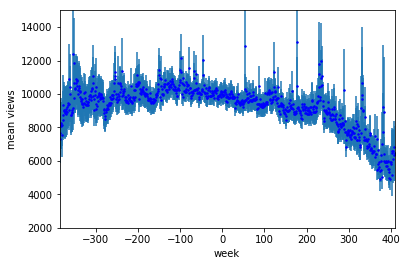

In [122]:
g=df_s_w_naw.groupby("week")
b_w_st_dict_topic=defaultdict()
for week_name,series in g:
    concatenated = []
    for l in series.views_list.values:
        concatenated.extend(l) 
    b_w_st_dict_topic[week_name]={"mean_w":series.views_mean.mean(),"std_1":series.views_mean.sem(),
                            "count":series[~series.views_mean.isnull()].views_mean.count(),
                            "mean_w_all":np.mean(list(set(concatenated))),"count_all": len(set(concatenated))}

df_b_w_st_topic=pd.DataFrame.from_dict(b_w_st_dict_topic,orient="index")
print len(df_b_w_st_topic)
df_b_w_st_topic=df_b_w_st_topic[df_b_w_st_topic["count"]>10]
print len(df_b_w_st_topic)
df_b_w_st_topic.info()


plt.errorbar(df_b_w_st_topic.index.values, df_b_w_st_topic.mean_w, df_b_w_st_topic.std_1,linestyle='None')
plt.plot(df_b_w_st_topic.index.values, df_b_w_st_topic.mean_w,".b",linewidth = 1,ms=3)
plt.xlim(df_b_w_st_topic.index.min(),df_b_w_st_topic.index.max())
plt.ylim(2000,15000)
plt.xlabel("week")
plt.ylabel("mean views");

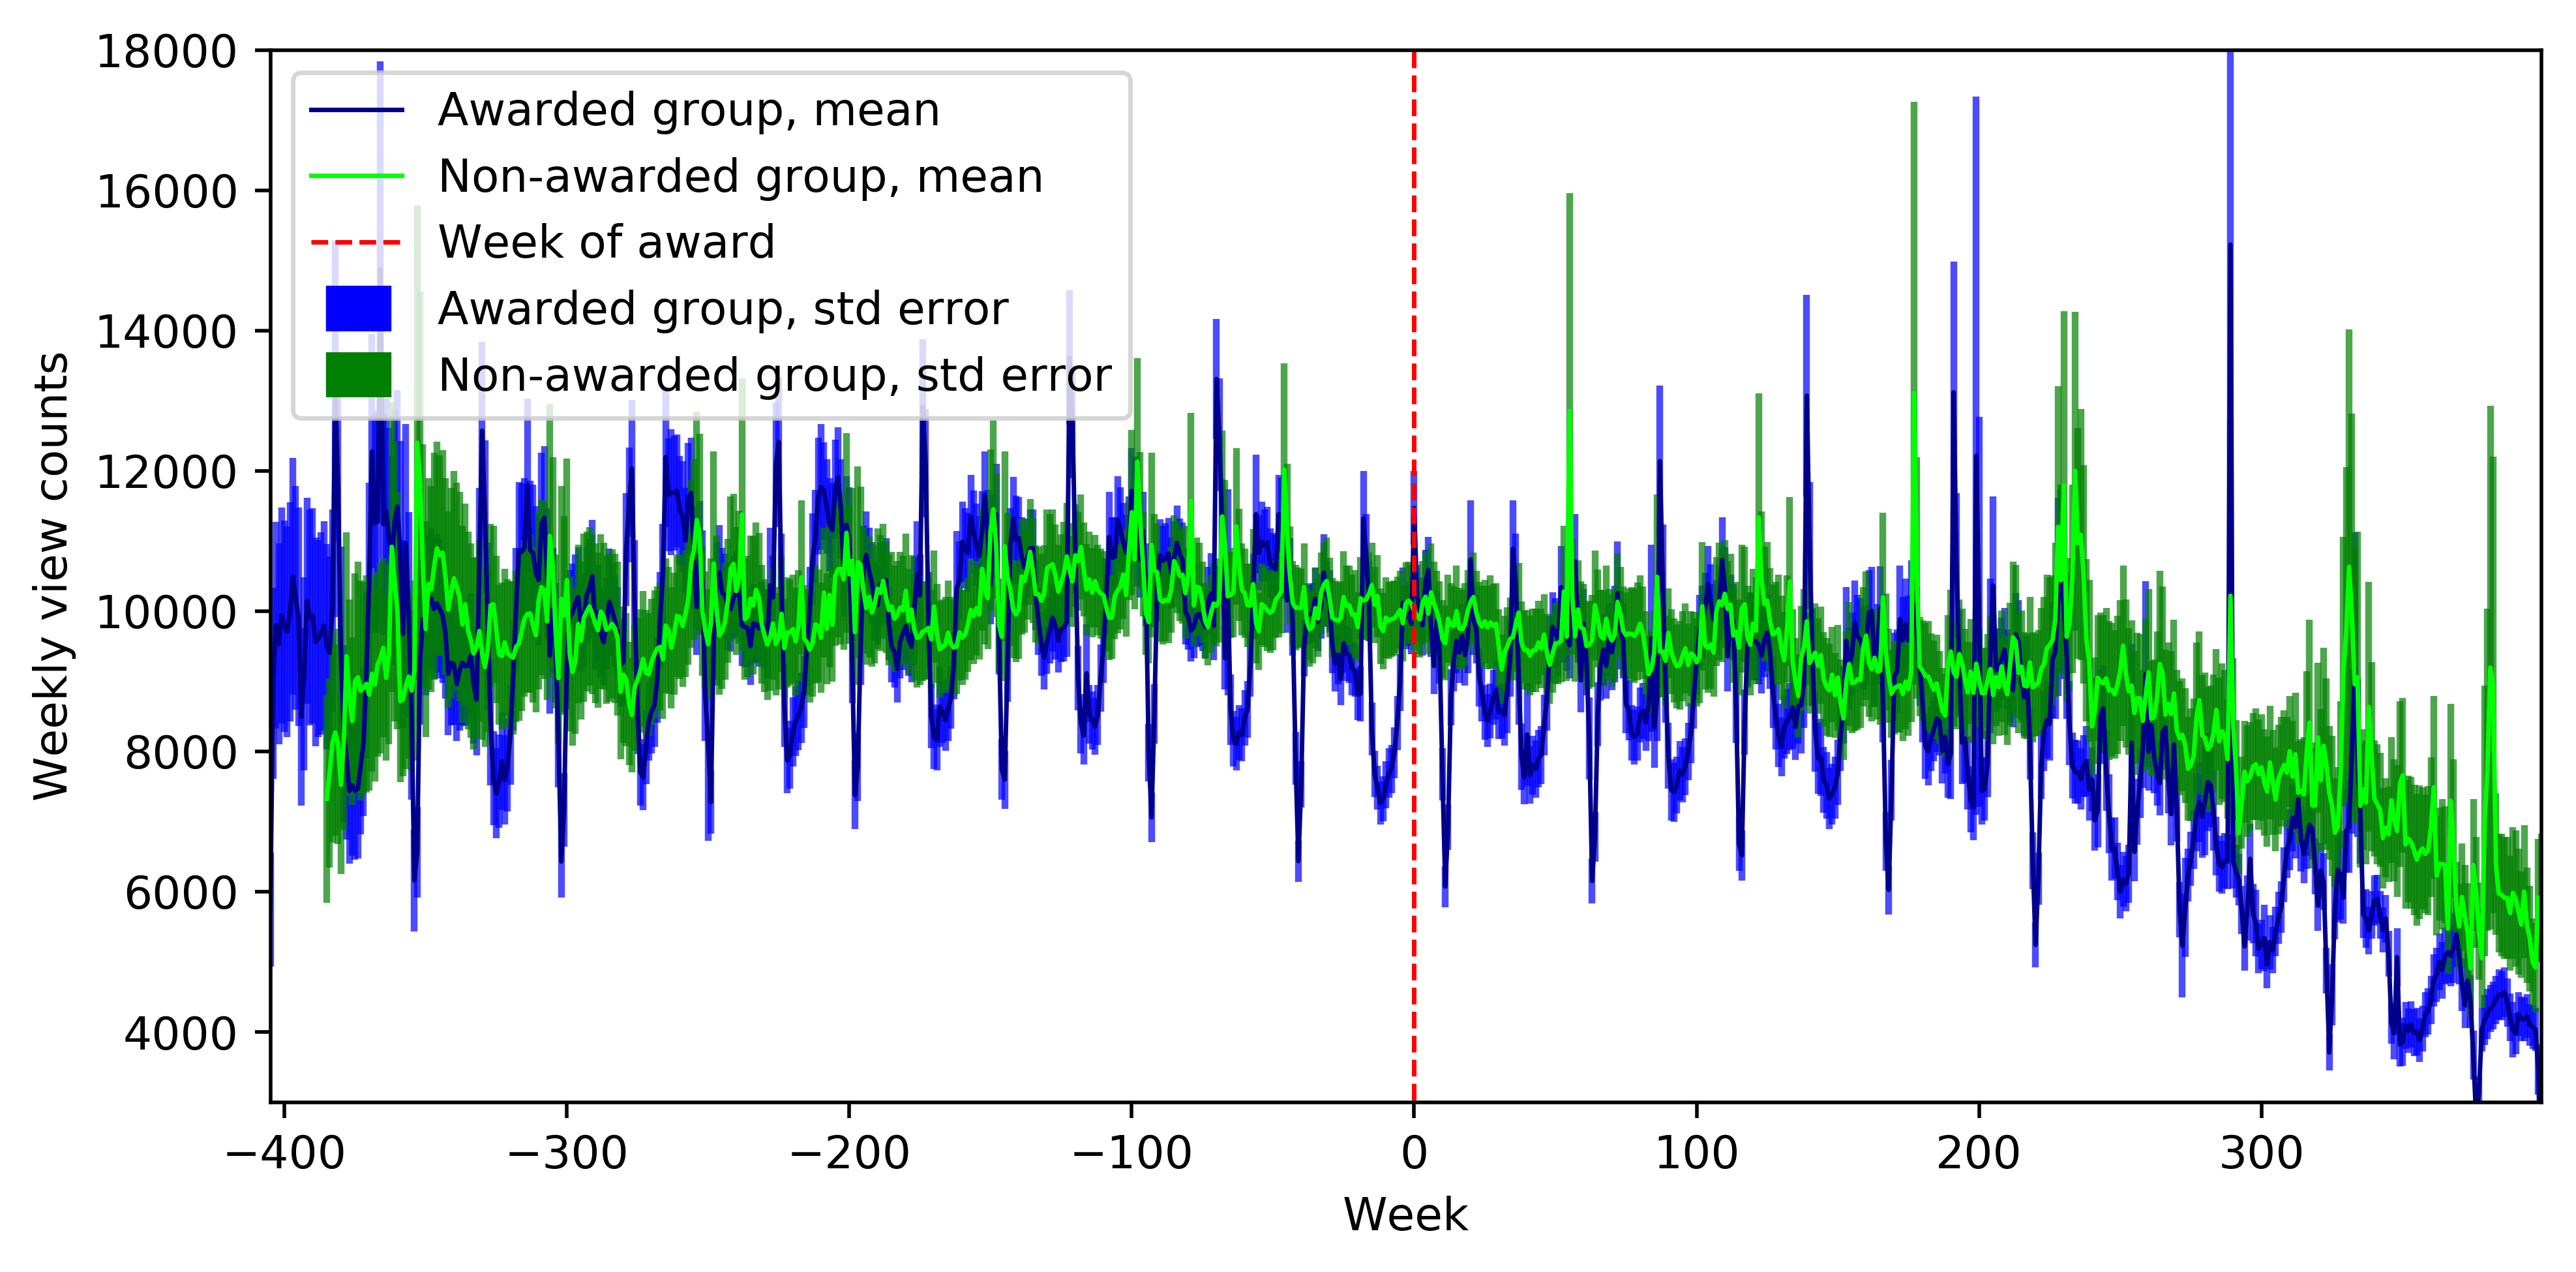

In [615]:
fig, (ax0) = plt.subplots(ncols=1, sharey=True,figsize=[8,4],dpi=500)

ax0.errorbar(df_s_w_st_topic.index.values, df_s_w_st_topic.mean_w, df_s_w_st_topic.std_1,c="b",alpha=0.7,#lw=2,
             linestyle='None',label="Awarded group, std error")#,label='_nolegend_')
ax0.plot(df_s_w_st_topic.index.values, df_s_w_st_topic.mean_w,c="darkblue",linewidth = 1,ms=4,
         label="Awarded group, mean")
ax0.set_xlim(df_s_w_st_topic.iloc[0].name,df_s_w_st_topic.iloc[-1].name)
ax0.set_ylim(3000,18000)
ax0.set_xlabel("Week")
ax0.set_ylabel("Weekly view counts")


ax0.errorbar(df_b_w_st_topic.index.values, df_b_w_st_topic.mean_w, df_b_w_st_topic.std_1,c="green",alpha=0.7,#lw=2,
             linestyle='None',label="Non-awarded group, std error")#label='_nolegend_'
ax0.plot(df_b_w_st_topic.index.values, df_b_w_st_topic.mean_w,c="lime",linewidth = 1,ms=4,
         label="Non-awarded group, mean")
ax0.plot([0,0],[2000,20000],"r--",label="Week of award",linewidth = 1)
leg=ax0.legend(loc=2,handler_map={ErrorbarContainer: HandlerErrorbar(numpoints=15,xpad=0.1)})
for lh in leg.legendHandles: 
    lh.set_alpha(1)

#plt.subplots_adjust(wspace=0.03, hspace=0.03)
plt.tight_layout()
plt.savefig("plots/view_counts_topics_2.pdf",dpi=500)
plt.show()

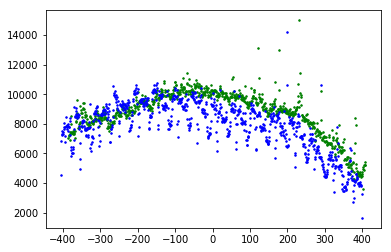

In [125]:
#plt.errorbar(df_s_w_st_topic.index.values, df_s_w_st_topic.mean_w_all, df_s_w_st_topic.std_1,linestyle='None')
plt.plot(df_b_w_st_topic.index.values, df_b_w_st_topic.mean_w_all,".g",linewidth = 1,ms=3)
plt.plot(df_s_w_st_topic.index.values, df_s_w_st_topic.mean_w_all,".b",linewidth = 1,ms=3)

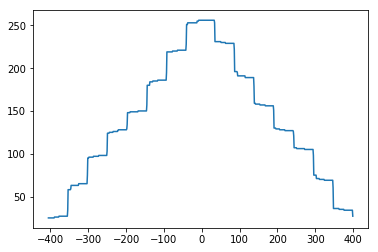

In [126]:
df_s_w_st_topic["count"].plot()

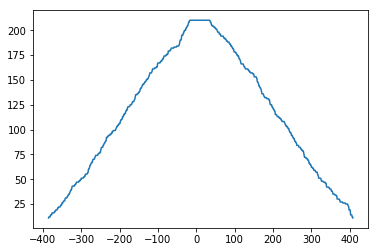

In [127]:
df_b_w_st_topic["count"].plot()

In [128]:
df_b_w_st_topic.loc[-1]

count           210.000000
count_all      1288.000000
mean_w        10100.136529
mean_w_all    10189.738354
std_1           559.258317
Name: -1, dtype: float64

In [129]:
df_b_w_st_topic.loc[0]

count           210.000000
count_all      1289.000000
mean_w         9996.635548
mean_w_all    10038.502715
std_1           555.145052
Name: 0, dtype: float64

# Remove intersection topics



In [130]:
sc_topic_aw_not_inter=defaultdict()
for k,v in sc_topic_aw3.iteritems():
    sc_topic_aw_not_inter[k]=[i for i in v if i not in intersection_topic]

df_s_w_aw2=df_s_w_aw.copy()   
df_s_w_aw2[['all_topics_len','topics_at_time','views_mean',
    "views_sem","views_list"]]= df_s_w_aw2.apply(lambda x: views_topic_mean_count(x,df_s_topic_new,
                                                                                 sc_topic_aw_not_inter), axis=1)

834
805
<class 'pandas.core.frame.DataFrame'>
Int64Index: 805 entries, -405 to 399
Data columns (total 5 columns):
count         805 non-null int64
count_all     805 non-null int64
mean_w        805 non-null float64
mean_w_all    805 non-null float64
std_1         805 non-null float64
dtypes: float64(3), int64(2)
memory usage: 37.7 KB


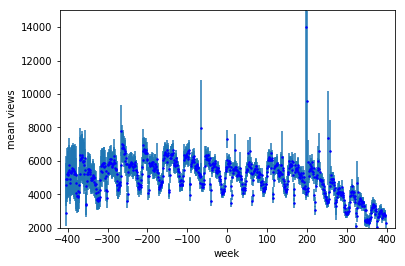

In [131]:
g=df_s_w_aw2.groupby("week")
s_w_st_dict_topic2=defaultdict()
for week_name,series in g:
    concatenated = []
    for l in series.views_list.values:
        concatenated.extend(l) 
    #print concatenated
    s_w_st_dict_topic2[week_name]={"mean_w":series.views_mean.mean(), "std_1":series.views_mean.sem(),
                           "count":series[~series.views_mean.isnull()].views_mean.count(),
                                "mean_w_all":np.mean(list(set(concatenated))),"count_all": len(set(concatenated)) }

df_s_w_st_topic2=pd.DataFrame.from_dict(s_w_st_dict_topic2,orient="index")
print len(df_s_w_st_topic2)
df_s_w_st_topic2=df_s_w_st_topic2[df_s_w_st_topic2["count"]>10]
print len(df_s_w_st_topic2)
df_s_w_st_topic2.info()


plt.errorbar(df_s_w_st_topic2.index.values, df_s_w_st_topic2.mean_w, df_s_w_st_topic2.std_1,linestyle='None')
plt.plot(df_s_w_st_topic2.index.values, df_s_w_st_topic2.mean_w,".b",linewidth = 1,ms=3)
plt.xlim(-420,420)
plt.ylim(2000,15000)
plt.xlabel("week")
plt.ylabel("mean views");

In [132]:
sc_topic_naw_not_inter=defaultdict()
for k,v in sc_topic_naw3.iteritems():
    sc_topic_naw_not_inter[k]=[i for i in v if i not in intersection_topic]
    
df_s_w_naw2=df_s_w_naw.copy()       
df_s_w_naw2[['all_topics_len','topics_at_time','views_mean',
            "views_sem","views_list"]]= df_s_w_naw2.apply(lambda x: views_topic_mean_count(x,df_b_topic_new,
                                                                                           sc_topic_naw_not_inter), axis=1)

805
805
<class 'pandas.core.frame.DataFrame'>
Int64Index: 786 entries, -380 to 405
Data columns (total 5 columns):
count         786 non-null int64
count_all     786 non-null int64
mean_w        786 non-null float64
mean_w_all    786 non-null float64
std_1         786 non-null float64
dtypes: float64(3), int64(2)
memory usage: 36.8 KB


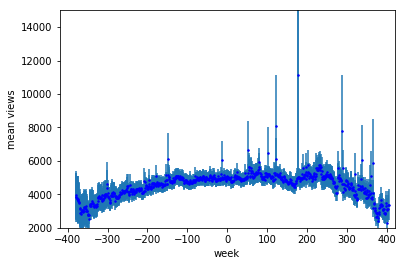

In [133]:
g=df_s_w_naw2.groupby("week")
s_b_st_dict_topic2=defaultdict()
for week_name,series in g:
    concatenated = []
    for l in series.views_list.values:
        concatenated.extend(l) 
    #print concatenated
    s_b_st_dict_topic2[week_name]={"mean_w":series.views_mean.mean(), "std_1":series.views_mean.sem(),
                           "count":series[~series.views_mean.isnull()].views_mean.count(),
                                "mean_w_all":np.mean(list(set(concatenated))),"count_all": len(set(concatenated)) }

df_b_w_st_topic2=pd.DataFrame.from_dict(s_b_st_dict_topic2,orient="index")
print len(df_s_w_st_topic2)
df_b_w_st_topic2=df_b_w_st_topic2[df_b_w_st_topic2["count"]>10]
print len(df_s_w_st_topic2)
df_b_w_st_topic2.info()


plt.errorbar(df_b_w_st_topic2.index.values, df_b_w_st_topic2.mean_w, df_b_w_st_topic2.std_1,linestyle='None')
plt.plot(df_b_w_st_topic2.index.values, df_b_w_st_topic2.mean_w,".b",linewidth = 1,ms=3)
plt.xlim(-420,420)
plt.ylim(2000,15000)
plt.xlabel("week")
plt.ylabel("mean views");

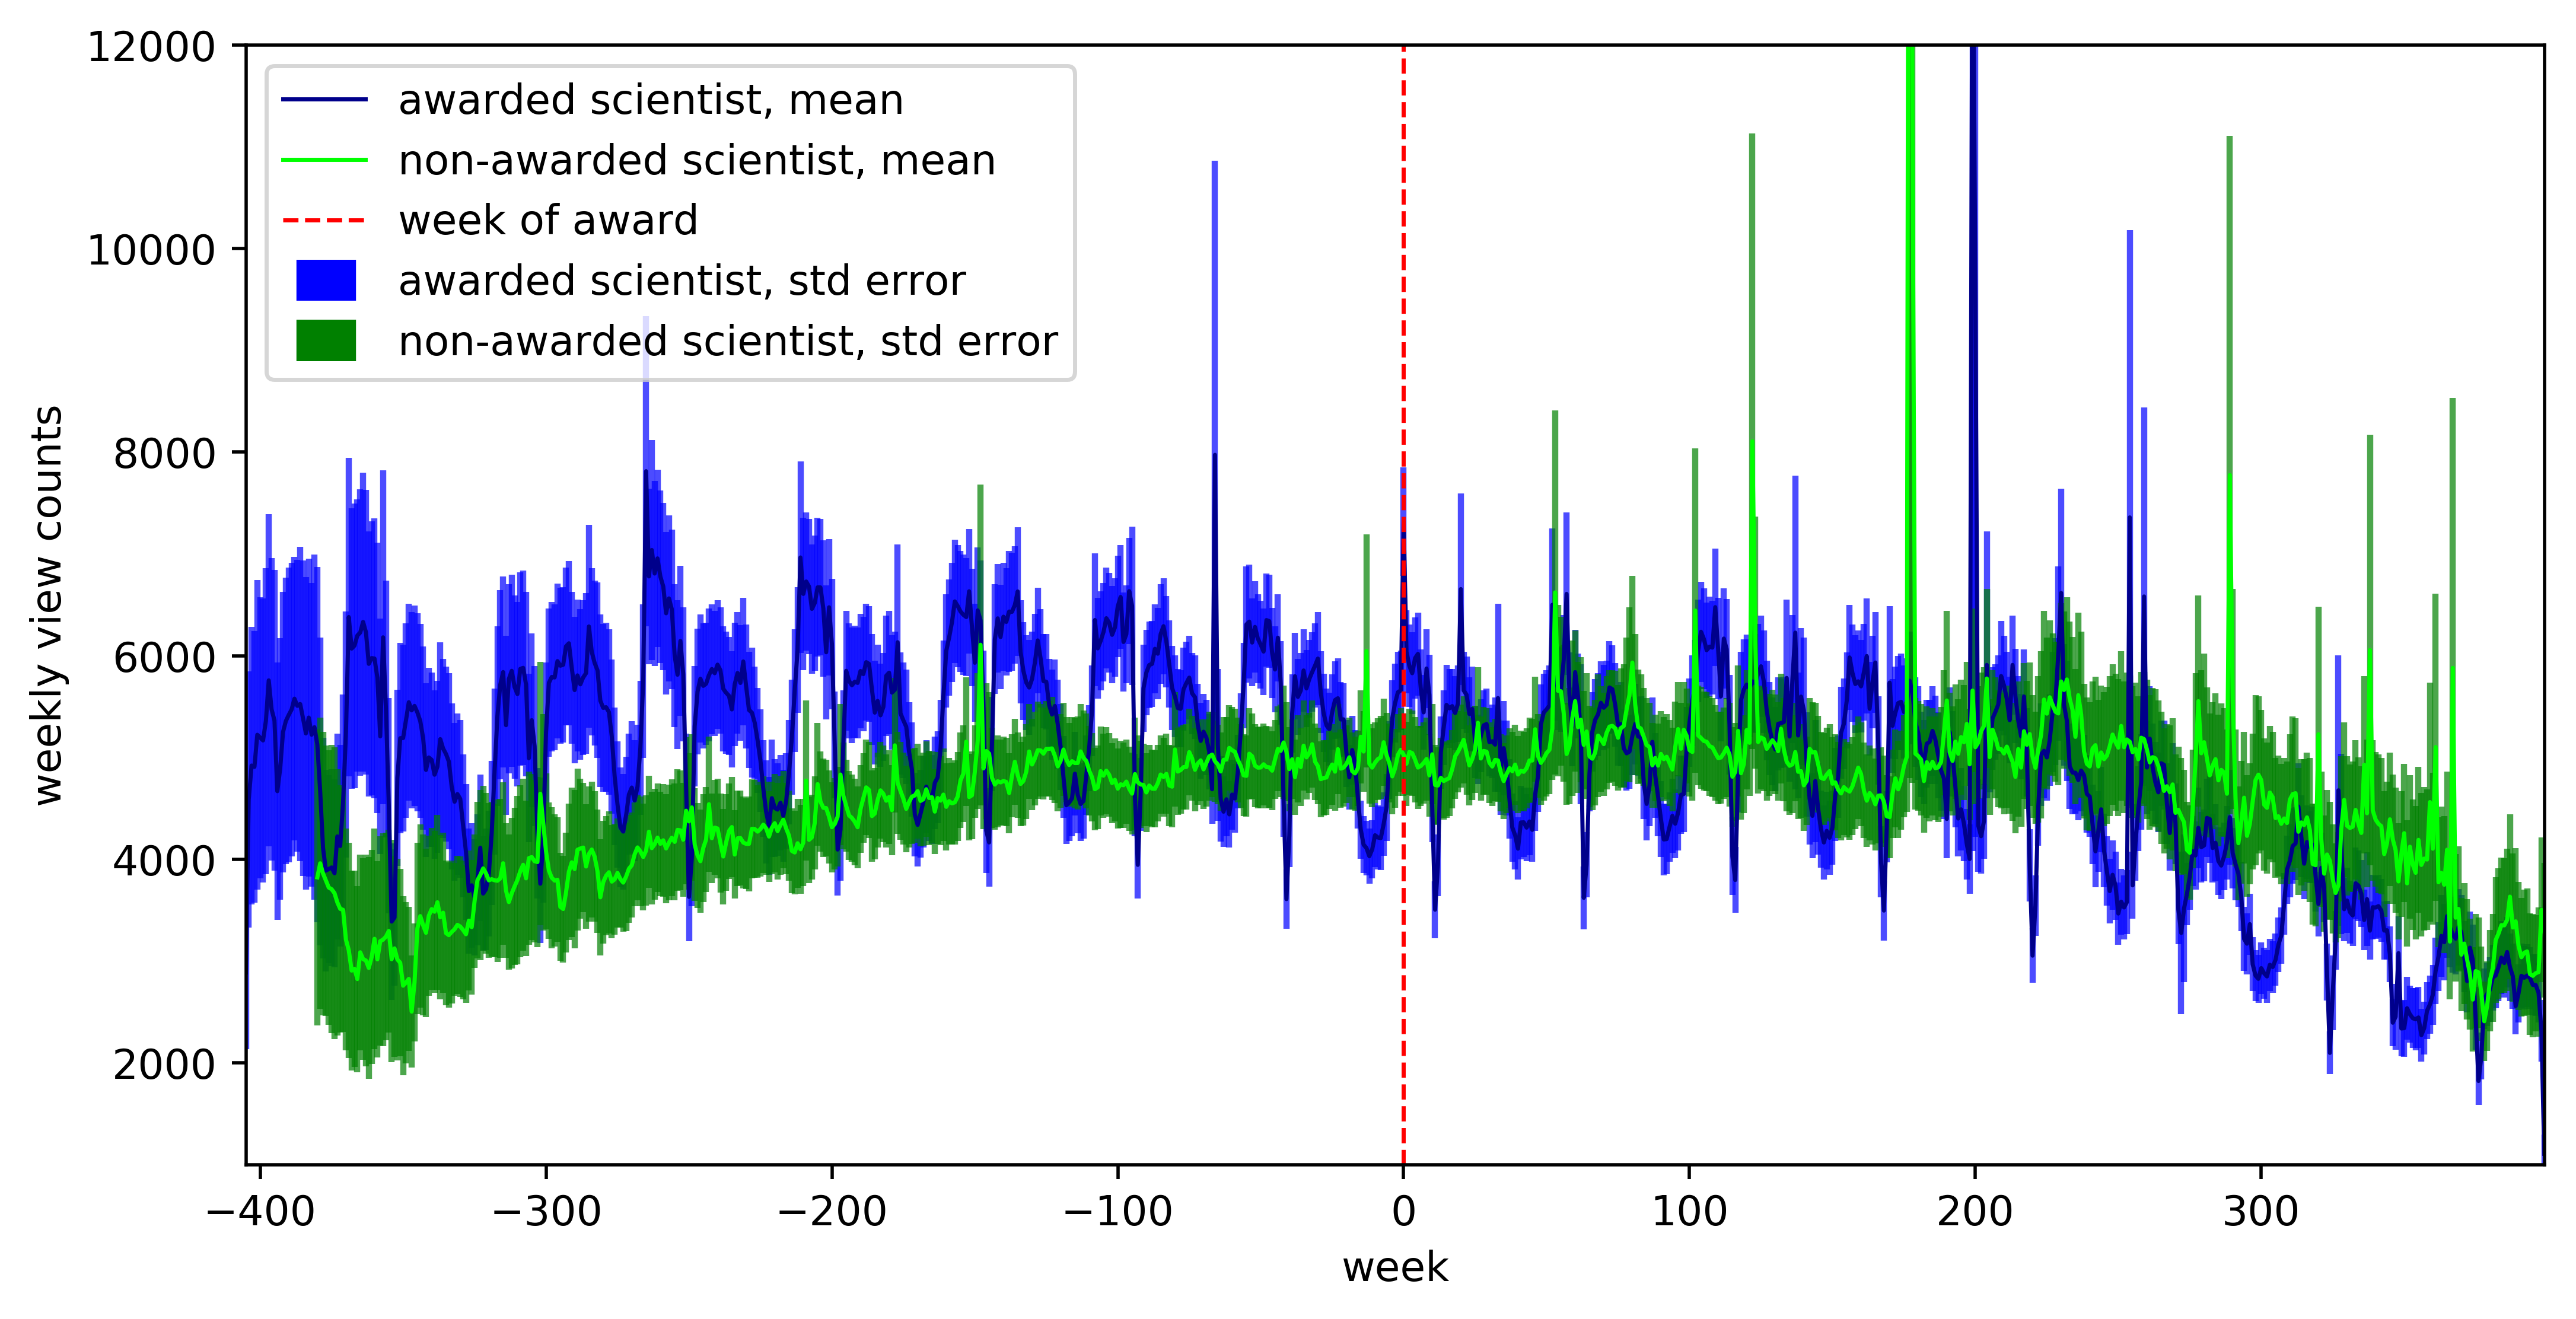

In [141]:
fig, (ax0) = plt.subplots(ncols=1, sharey=True,figsize=[10,5],dpi=500)

ax0.errorbar(df_s_w_st_topic2.index.values, df_s_w_st_topic2.mean_w, df_s_w_st_topic2.std_1,c="b",alpha=0.7,#lw=2,
             linestyle='None',label="awarded scientist, std error")#,label='_nolegend_')
ax0.plot(df_s_w_st_topic2.index.values, df_s_w_st_topic2.mean_w,c="darkblue",linewidth = 1,ms=4,
         label="awarded scientist, mean")
ax0.set_xlim(df_s_w_st_topic2.iloc[0].name,df_s_w_st_topic2.iloc[-1].name)
ax0.set_ylim(1000,12000)
ax0.set_xlabel("week")
ax0.set_ylabel("weekly view counts")


ax0.errorbar(df_b_w_st_topic2.index.values, df_b_w_st_topic2.mean_w, df_b_w_st_topic2.std_1,c="green",alpha=0.7,#lw=2,
             linestyle='None',label="non-awarded scientist, std error")#label='_nolegend_'
ax0.plot(df_b_w_st_topic2.index.values, df_b_w_st_topic2.mean_w,c="lime",linewidth = 1,ms=4,
         label="non-awarded scientist, mean")
ax0.plot([0,0],[1000,20000],"r--",label="week of award",linewidth = 1)
leg=ax0.legend(loc=2,handler_map={ErrorbarContainer: HandlerErrorbar(numpoints=15,xpad=0.1)})
for lh in leg.legendHandles: 
    lh.set_alpha(1)

plt.subplots_adjust(wspace=0.03, hspace=0.03)
plt.show()

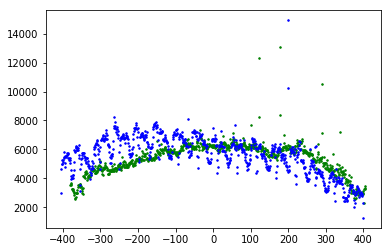

In [135]:
plt.plot(df_b_w_st_topic2.index.values, df_b_w_st_topic2.mean_w_all,".g",linewidth = 1,ms=3)
plt.plot(df_s_w_st_topic2.index.values, df_s_w_st_topic2.mean_w_all,".b",linewidth = 1,ms=3)

#get views of article

https://stackoverflow.com/questions/5323589/how-to-use-wikipedia-api-to-get-the-page-view-statistics-of-a-particular-page-in

https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Foo/daily/20151010/20151015

https://wikimedia.org/api/rest_v1/#/
    

https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_per_article_project_access_agent_article_granularity_start_end


https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia.org/all-access/all-agents/Ruslan_Medzhitov/daily/20150101/20160101

only last 2 years

#find neighboors of these articles:
https://en.wikipedia.org/w/api.php?action=query&titles=Liao_Shijun&prop=links&redirects&pllimit=500
    
    
https://en.wikipedia.org/w/api.php?action=query&prop=revisions&format=json&rvprop=content|ids&titles=Bioglass&rvstartid=779572435&rvlimit=1

description: https://www.mediawiki.org/wiki/API:Revisions 


https://en.wikipedia.org/w/api.php?action=query&format=json&prop=&list=backlinks&indexpageids=1&titles=%C4%90%C3%A0m_Thanh_S%C6%A1n&bllimit=500&blredirect=1&redirects=1&converttitles=1&bltitle=%C4%90%C3%A0m_Thanh_S%C6%A1n


In [144]:
empty_articles

[u'Ruslan_Medzhitov',
 u'Liao_Shijun',
 u'Michael_Boehnke',
 u'Achim_M%C3%BCller',
 u'Albert-L%C3%A1szl%C3%B3_Barab%C3%A1si',
 u'Andrew_H._Van_de_Ven',
 u'Kim_Kimoon',
 u'Olivier_Blanchard',
 u'Fran%C3%A7ois_Diederich',
 u'Marc_A._Kastner',
 u'Jean-Michel_Sav%C3%A9ant',
 u'Axel_D._Becke',
 u'Ivan_K._Schuller',
 u'Horst_St%C3%B6cker',
 u'Sharon_Ann_Hunt',
 u'Paul_Volberding',
 u'Daniel_Rios',
 u'Pan_Jianwei',
 u'Tomas_H%C3%B6kfelt',
 u'C._N._R._Rao',
 u'G%C3%A1bor_A._Somorjai',
 u'Thomas_J.R._Hughes',
 u'Jose_Baselga',
 u'Michael_L._Tushman',
 u'Bruce_D._Walker',
 u'G%C3%A9rard_F%C3%A9rey',
 u'Claire_Berger',
 u'Robert_J._Birgeneau',
 u'%C5%BDeljko_Reiner',
 u'Andrew_B_Bernard',
 u'Gon%C3%A7alo_Abecasis',
 u'Joan_Massagu%C3%A9_Sol%C3%A9',
 u'Rodney_J._Bartlett',
 u'Joann_E._Manson',
 u'Edward_R._Dougherty',
 u'Robert_Lusch',
 u'Luis_Oro',
 u'Daron_Acemo%C4%9Flu',
 u'Jean-Luc_Br%C3%A9das',
 u'Jean_Fr%C3%A9chet',
 u'G%C3%A9rald_Bastard',
 u'Stuart_A._Rice',
 u'Keith_Usherwood_Ingold',
 u'

In [260]:
from wikitools import wiki, api
import wikipedia
import urllib, json,urllib2
import re, urlparse
import pprint
import mwparserfromhell
from mwparserfromhell.nodes import Wikilink
import ast


def send_request(language, title, revisions_first=False): 
    k = 0            
    site = wiki.Wiki("https://" + language + ".wikipedia.org/w/api.php")
    textdict = {}
    text = ''
    wikicode = ''
    linklist = []
    try:
        params = {'action':'parse', 'page':title, 'prop':'wikitext'}
        if revisions_first:
            params = {'action':'query',
                'titles': title,
                'prop':'revisions',
                'rvprop':'content|ids',
                'rvlimit':'1',
                'rvstart':'2016-07-28T23:59:00Z',
                'rvdir':'older',
                "redirects":1}
            req = api.APIRequest(site, params) 
            res=req.query(querycontinue=False)
            textdict = res['query']['pages'].values()[0]["revisions"][0]
        else:
            
            res = req.query(querycontinue=False)
            textdict = res['parse']['wikitext'] 
        text = textdict['*']
        wikicode = mwparserfromhell.parse(text)
        filtered_code = wikicode.filter_wikilinks()
        for node in filtered_code: 
            link = node.title
            if ":" not in link:
                if link is not None:
                    strlink = link.encode("utf-8")
                    strlink = strlink.decode("utf-8")
                    if strlink not in linklist:
                        linklist.append(strlink)
        if title not in linklist:
            linklist.append(title)
        return linklist
    except:
        print 'Catched exeption'
        k+=1
        print title
        
def clean_up(cat_list, stop_list):
    if not cat_list:
        return True
    for item in cat_list:
        if "Government of" in item:
            return True
        if "legislative speakers" in item:
            return True
        if "football forwards" in item:
            return True
        if "women academics" in item:
            return True
        if "Disambiguation pages" in item:
            return True
        word_list = item.rstrip().replace("(","").replace(")","").split(' ')
        for word in word_list:
            word = word.lower()
            if word in stop_list:
                return True
    return False

def get_category(language, neighbor): 
    cat_list = []
    neighbor = urllib.quote_plus(neighbor.encode("utf-8"))
    site= "https://en.wikipedia.org/w/api.php?action=query&format=json&prop=categories&list=&indexpageids=1&redirects=1&cllimit=500&titles=%s" %neighbor
    hdr = {'User-Agent': 'Mozilla/5.0'}
    req = urllib2.Request(site,headers=hdr)
    try:
        page = urllib2.urlopen(req)
    except urllib2.HTTPError, e:
        print e.fp.read()
    res = page.read()    
    res = ast.literal_eval(res)
    if 'pages' in res['query']:
        for pidkey in  res['query']['pages']:      
            if 'categories' in res['query']['pages'][pidkey]:
                for key in res['query']['pages'][pidkey]['categories']:
                    cat = key["title"]
                    cat = cat.rstrip().split(':')[-1]
                    cat_list.append(cat)
    return cat_list
#send_request("en", "Liao_Shijun")

In [262]:
#Liao_Shijun
#Ruslan_Medzhitov
#Michael_Boehnke
#u'%C4%90%C3%A0m_Thanh_S%C6%A1n'
i=0

base_dir="C:\\Users\\zagovooa\\GitHub\\scientists-analysis\\"
with open(base_dir+"data\\neighbors\\stop_list.txt", "r") as f:
    stop_list = f.read().split(',')
Dump = {}
stop_list.extend(["surnames", "communes", "ministers","medals","musicians","dancers","banks"])

for title_name in empty_articles:
    print title_name
    if title_name=="Joann_E._Manson":
        title_name_decoded="JoAnn_E._Manson"
    else:
        title_name_decoded=urllib.unquote(title_name.encode('utf8')).decode("utf-8")
    all_neighbors=send_request("en",title_name_decoded,revisions_first=True)
    #print all_neighbors
    clean_list=[]
    for neighbor in all_neighbors:
        if "Ministry of"  in neighbor:
            continue
        if u'ISI Web of Knowledge' in neighbor:
            continue
        cat_list= get_category("en", neighbor)
        state = clean_up(cat_list, stop_list)
        if state == False:
            clean_list.append(neighbor)
    clean_list=map(lambda e : e.upper()[0]+ e[1:].split("#",1)[0], clean_list)
    clean_list=list(set(clean_list))
    Dump.update({title_name:clean_list})
    
with open('data/baseline_neighbors_list_additional.json', 'w') as outfile:
    json.dump(Dump, outfile,indent=4)

Ruslan_Medzhitov
Liao_Shijun
Michael_Boehnke
Achim_M%C3%BCller
Albert-L%C3%A1szl%C3%B3_Barab%C3%A1si
Andrew_H._Van_de_Ven
Kim_Kimoon
Olivier_Blanchard
Fran%C3%A7ois_Diederich
Marc_A._Kastner
Jean-Michel_Sav%C3%A9ant
Axel_D._Becke
Ivan_K._Schuller
Horst_St%C3%B6cker
Sharon_Ann_Hunt
Paul_Volberding
Daniel_Rios
Pan_Jianwei
Tomas_H%C3%B6kfelt
C._N._R._Rao
G%C3%A1bor_A._Somorjai
Thomas_J.R._Hughes
Jose_Baselga
Michael_L._Tushman
Bruce_D._Walker
G%C3%A9rard_F%C3%A9rey
Claire_Berger
Robert_J._Birgeneau
%C5%BDeljko_Reiner
Andrew_B_Bernard
Gon%C3%A7alo_Abecasis
Joan_Massagu%C3%A9_Sol%C3%A9
Rodney_J._Bartlett
Joann_E._Manson
Edward_R._Dougherty
Robert_Lusch
Luis_Oro
Daron_Acemo%C4%9Flu
Jean-Luc_Br%C3%A9das
Jean_Fr%C3%A9chet
G%C3%A9rald_Bastard
Stuart_A._Rice
Keith_Usherwood_Ingold
Bernhard_Keimer
Chen_Guanrong
Yang_Huanming
Nicholas_C._Handy
Stephen_L._Buchwald
Younan_Xia
Juan_Mart%C3%ADn_Maldacena
Paul_Ridker
Henri_Berestycki
Michael_I._Jordan
K%C3%A1ri_Stef%C3%A1nsson
Elias_James_Corey
John_A.

In [304]:
topics_new=[]
[topics_new.extend([i.encode("utf-8").replace(" ","_") for i in v] ) for k,v in Dump.iteritems()]
topics_new=list(set(topics_new))
print len(topics_new)
print len(set(topics_new)-set(df_b_topic_new.index))
topics_new_in_b=list(set(topics_new)-set(df_b_topic_new.index)) ### new topics we need views for them



361
277


In [ ]:

# Daniel Rios -> remove from scientists; it is not a page about scientist